In [56]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
from pandas_datareader import data as pdr
import yfinance as yf
import seaborn as sns
yf.pdr_override()

In [57]:
capital = 1e5
start_date = dt.datetime(2004,11,1)
end_date = dt.datetime(2023,11,1)

spy = pdr.get_data_yahoo("SPY", start = start_date, end = end_date)
Y = np.log(spy["Adj Close"]).diff(1).shift(-1)
Y.name = "Y_pred"
Y

[*********************100%***********************]  1 of 1 completed


Date
2004-11-01    0.000352
2004-11-02    0.012515
2004-11-03    0.013562
2004-11-04    0.006244
2004-11-05   -0.001450
                ...   
2023-10-25   -0.012047
2023-10-26   -0.004543
2023-10-27    0.011885
2023-10-30    0.006261
2023-10-31         NaN
Name: Y_pred, Length: 4783, dtype: float64

In [58]:
# Loading Algorithm

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression

# Regularization
from sklearn.linear_model import Lasso #because we are selecting features.
from sklearn.linear_model import ElasticNet

# Decision Tree
from sklearn.tree import DecisionTreeRegressor #worst performer because there is no pruning?

# ENSEMBLE

## Bagging (bootstrap aggregation) #likely to overfit too because its underlying uses decision tree 
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor

## Boosting
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor


# for cross-validation
from sklearn.model_selection import cross_val_score #perf, mean, variance and std error
from sklearn.model_selection import KFold # we can tune it as hyperparameter
from sklearn.model_selection import GridSearchCV

# for assessment
from sklearn import metrics
from sklearn.metrics import mean_squared_error

# for Feature Selection
from sklearn.feature_selection import chi2, f_regression
from sklearn.feature_selection import SelectKBest

#import dependency for time series modelling

import statsmodels.tsa.arima.model as stats
import statsmodels.api as sm

from pandas.plotting import scatter_matrix #plot of correlation matrix and kernel density plotting

# for Pre-processing (Feature Engineering)
from sklearn.preprocessing import StandardScaler


# ALTERNATIVE APPROACH TO GET MORE FEATURES

In [55]:
capital = 1e5
start_date = dt.datetime(2004,11,1)
end_date = dt.datetime(2023,11,1)

spy = pdr.get_data_yahoo("SPY", start = start_date, end = end_date)
Y = np.log(spy["Adj Close"]).diff(1).shift(-1)
Y.name = "Y_pred"

ticker = "^TNX"

tnx_data = yf.download(ticker, start=start_date, end=end_date)

X0 = np.log(tnx_data["Adj Close"])
X0 = X0.ffill()
X0.name = "10years futures"

X1 = np.log(spy["Volume"])
X2 =\
(pd.concat([Y.
            diff(i) 
            for i in [3,6,12]], 
                   axis = 1
          )
 #.dropna()
)
X2.columns = ["SPY_3", "SPY_6", "SPY_12"]

X3 =\
(
    pd.concat([X1.shift(i)
               #.diff(i) 
               for i in [3,6,12]],
                      axis =1
             )
)
X3.columns = ["Volume_3", "Volume_6", "Volume_12"]

X =\
(
        pd.concat([X0, X1, X2, X3],
                 axis = 1)
)

#no trading signal for the first 12 days
X_traintest = X.iloc[12:]
Y_traintest = Y.iloc[12:]

X_traintest = X_traintest.ffill()


#interpreting Y returns in binary signal
Y_traintest_binary = (Y_traintest > 0).astype(int)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [5]:
X_traintest

10years futures     Volume     SPY_3     SPY_6    SPY_12  \
Date                                                                   
2004-11-17         1.421662  17.813601 -0.001105  0.000579  0.000996   
2004-11-18         1.415125  17.276683 -0.003994 -0.018760 -0.023694   
2004-11-19         1.434132  17.809602 -0.001162 -0.003101 -0.008804   
2004-11-22         1.426716  17.441456  0.000176 -0.000930 -0.004720   
2004-11-23         1.431268  17.552437  0.013546  0.009552  0.003817   
...                     ...        ...       ...       ...       ...   
2023-10-25         1.599993  18.361177 -0.010312  0.001368 -0.017238   
2023-10-26         1.577947  18.561805 -0.012054  0.004282 -0.008631   
2023-10-27         1.577947  18.491770  0.026341  0.024249  0.018000   
2023-10-30         1.584120  18.276380  0.018308  0.007995  0.011254   
2023-10-31         1.584120  18.193343  0.018308  0.007995  0.011254   

             Volume_3   Volume_6  Volume_12  
Date                                         
2004-11-17  17.833401  17.614546  17.418857  
2004-11-18  17.379334  17.628054  17.844605  
2004-11-19  17.505107  17.449490  18.158799  
2004-11-22  17.813601  17.833401  17.829193  
2004-11-23  17.276683  17.379334  17.963194  
...               ...        ...        ...  
2023-10-25  18.634548  18.137319  18.202206  
2023-10-26  18.337681  18.354111  18.179975  
2023-10-27  18.179427  18.613967  17.949904  
2023-10-30  18.361177  18.634548  18.211862  
2023-10-31  18.561805  18.337681  18.370893  

[4771 rows x 8 columns]

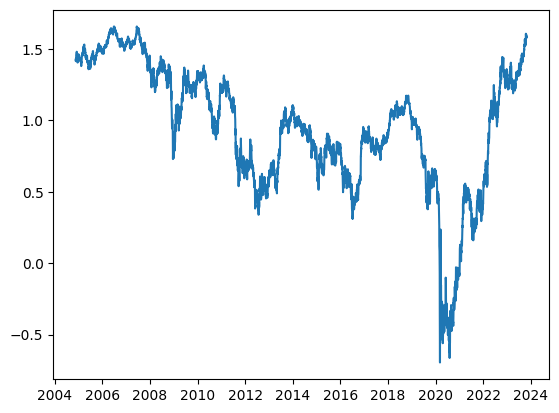

In [6]:
plt.plot(X_traintest['10years futures'])

In [7]:
X_traintest.describe()

10years futures       Volume        SPY_3        SPY_6       SPY_12  \
count      4771.000000  4771.000000  4771.000000  4771.000000  4771.000000   
mean          0.949562    18.485200     0.000006    -0.000003    -0.000014   
std           0.449800     0.594471     0.017087     0.017530     0.017018   
min          -0.695149    16.541401    -0.133988    -0.165887    -0.142857   
25%           0.676255    18.038105    -0.007520    -0.007547    -0.007763   
50%           0.982453    18.408187    -0.000337    -0.000368    -0.000342   
75%           1.307522    18.886602     0.007141     0.007141     0.007185   
max           1.657847    20.585183     0.161981     0.202618     0.135072   

          Volume_3     Volume_6    Volume_12  
count  4771.000000  4771.000000  4771.000000  
mean     18.484730    18.484225    18.483457  
std       0.594907     0.595339     0.595927  
min      16.541401    16.541401    16.541401  
25%      18.036886    18.035614    18.033281  
50%      18.407938    18.407802    18.405829  
75%      18.886602    18.886602    18.886602  
max      20.585183    20.585183    20.585183

In [8]:
Y_traintest

Date
2004-11-17    0.001349
2004-11-18   -0.011179
2004-11-19    0.004758
2004-11-22    0.001524
2004-11-23    0.002367
                ...   
2023-10-25   -0.012047
2023-10-26   -0.004543
2023-10-27    0.011885
2023-10-30    0.006261
2023-10-31         NaN
Name: Y_pred, Length: 4771, dtype: float64

In [9]:
X_traintest.isna().any()

10years futures    False
Volume             False
SPY_3              False
SPY_6              False
SPY_12             False
Volume_3           False
Volume_6           False
Volume_12          False
dtype: bool

In [10]:
 Y_traintest.shift(-1)

Date
2004-11-17   -0.011179
2004-11-18    0.004758
2004-11-19    0.001524
2004-11-22    0.002367
2004-11-23   -0.000760
                ...   
2023-10-25   -0.004543
2023-10-26    0.011885
2023-10-27    0.006261
2023-10-30         NaN
2023-10-31         NaN
Name: Y_pred, Length: 4771, dtype: float64

In [11]:
# Engineering more features
# Uses F-statistics to determine model significance

from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree=3)

index_ = Y_traintest.shift(-1).dropna().index 

X_poly = poly.fit_transform(X_traintest.loc[index_])


from sklearn.feature_selection import SelectKBest, f_regression
#(R-squared / (1 - R-squared)) * ((n - k - 1) / k)

selector = SelectKBest(score_func=f_regression, k=10) #marginal improvement from when k = 8. big improvement from k = 5

#we are shifting the Y values because we need to train the model for a 1 day look ahead
X_selected = selector.fit_transform(X_poly, Y_traintest.shift(-1).loc[index_]) #Y_traintest_binary

X_selected

array([[ 0.01032021,  0.01033168,  0.18384016, ...,  0.18198792,
         0.17996612,  0.17975454],
       [-0.324102  , -0.32602768, -5.59940743, ..., -5.74723339,
        -5.81783525, -5.82948331],
       [-0.05523413, -0.05428978, -0.9836978 , ..., -0.94732892,
        -0.98583714, -0.94431908],
       ...,
       [ 0.02511368,  0.02548758,  0.46111664, ...,  0.46227637,
         0.4639302 ,  0.44994137],
       [ 0.07948454,  0.0785248 ,  1.47537654, ...,  1.44125298,
         1.42757896,  1.44254435],
       [ 0.44840785,  0.44083382,  8.29185472, ...,  8.20566612,
         7.91292472,  8.40180501]])

In [12]:
#get the features name used. Volume could be a cross-product or of a higher power

X_columns = selector.get_feature_names_out()

In [13]:
X_columns

array(['x19', 'x32', 'x83', 'x96', 'x97', 'x98', 'x139', 'x140', 'x141',
       'x142'], dtype=object)

In [14]:
X_selected_df = pd.DataFrame(X_selected, columns = X_columns, index = X_traintest.iloc[:-2].index)

In [15]:
X_selected_df

x19       x32       x83       x96       x97       x98  \
Date                                                                     
2004-11-17  0.010320  0.010332  0.183840  0.184044  0.181786  0.179766   
2004-11-18 -0.324102 -0.326028 -5.599407 -5.632677 -5.713287 -5.783472   
2004-11-19 -0.055234 -0.054290 -0.983698 -0.966879 -0.963807 -1.002985   
2004-11-22 -0.016216 -0.016562 -0.282832 -0.288866 -0.289187 -0.289119   
2004-11-23  0.167657  0.165023  2.942794  2.896562  2.913772  3.011661   
...              ...       ...       ...       ...       ...       ...   
2023-10-23 -0.054195 -0.054243 -0.993806 -0.994697 -0.995606 -0.979085   
2023-10-24 -0.261970 -0.268232 -4.762470 -4.876307 -4.751816 -4.858158   
2023-10-25  0.025114  0.025488  0.461117  0.467982  0.455495  0.457124   
2023-10-26  0.079485  0.078525  1.475377  1.457562  1.458868  1.445027   
2023-10-27  0.448408  0.440834  8.291855  8.151798  8.346649  8.048878   

                x139      x140      x141      x142  
Date                                                
2004-11-17  0.184249  0.181988  0.179966  0.179755  
2004-11-18 -5.666144 -5.747233 -5.817835 -5.829483  
2004-11-19 -0.950348 -0.947329 -0.985837 -0.944319  
2004-11-22 -0.295030 -0.295358 -0.295288 -0.295686  
2004-11-23  2.851056  2.867996  2.964347  2.885037  
...              ...       ...       ...       ...  
2023-10-23 -0.995588 -0.996498 -0.979962 -0.997409  
2023-10-24 -4.992864 -4.865398 -4.974282 -4.741186  
2023-10-25  0.474950  0.462276  0.463930  0.449941  
2023-10-26  1.439963  1.441253  1.427579  1.442544  
2023-10-27  8.014106  8.205666  7.912925  8.401805  

[4769 rows x 10 columns]

In [16]:
#from sklearn.linear_model import Ridge
#from sklearn.linear_model import Lasso

#between 0 to 1 where 0 is Ridge and 1 is Lasso
penalty_ = 0.0

#linear_regression2 = LinearRegression()
elastic_net = ElasticNet(alpha=0.1, l1_ratio=penalty_)
#ridge_model = Ridge(alpha=1.0)
index_ = X_selected_df.index
elastic_net.fit(X_selected_df, Y_traintest.shift(-1).loc[index_])
print("intercept is {:.3f} and coefficients are {}".format(elastic_net.intercept_, elastic_net.coef_))

EN_pred_train2 = elastic_net.predict(X_selected_df)
print(EN_pred_train2)

#continuous predictions are turned into binary signal or 1 and 0 

Y_pred_binary2 = (EN_pred_train2 > 0.0).astype(int)
Y_pred_binary2

logreg_sk2 = LogisticRegression(penalty='elasticnet', l1_ratio=penalty_, solver = "saga")
logreg_sk2.fit(X_selected_df, Y_pred_binary2)
print("intercept is {:.3f} and coefficients are {}".format(logreg_sk2.intercept_[0], logreg_sk2.coef_[0]))

Y_pred_logistic2 = logreg_sk2.predict(X_selected_df)

print("Name of features used: {}".format(elastic_net.feature_names_in_))
print(" ")
print("Accuracy :", metrics.accuracy_score(Y_traintest_binary.iloc[:-2], Y_pred_logistic2))
print(" ")
print("Precision :", metrics.precision_score(Y_traintest_binary.iloc[:-2],Y_pred_logistic2))
print(" ")
print("Recall :", metrics.recall_score(Y_traintest_binary.iloc[:-2],Y_pred_logistic2)) 

intercept is 0.000 and coefficients are [ 2.42098518e-05  3.08715484e-05 -9.55176360e-04 -7.49012716e-04
 -1.10084874e-04  7.70898564e-04 -3.25508806e-04  6.14568063e-05
  7.89626011e-04  3.09846585e-04]
[ 3.21345838e-04  1.17759327e-03  5.40434223e-04 ...  2.58876773e-04
  1.74630101e-05 -1.60168947e-03]
intercept is 1.854 and coefficients are [-0.00880387 -0.00787859 -0.18738776 -0.17058811 -0.16106305 -0.14921308
 -0.1533316  -0.14376326 -0.13182001 -0.13424729]
Name of features used: ['x19' 'x32' 'x83' 'x96' 'x97' 'x98' 'x139' 'x140' 'x141' 'x142']
 
Accuracy : 0.32270916334661354
 
Precision : 0.4036668738346799
 
Recall : 0.49770114942528737


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.487e-01, tolerance: 7.079e-05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


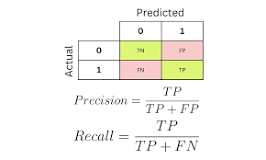

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


[Text(0.5, 0, 'predicted values'),
 Text(0, 0.5, 'target values'),
 Text(0.5, 1.0, 'Predicted vs Actual Responses')]

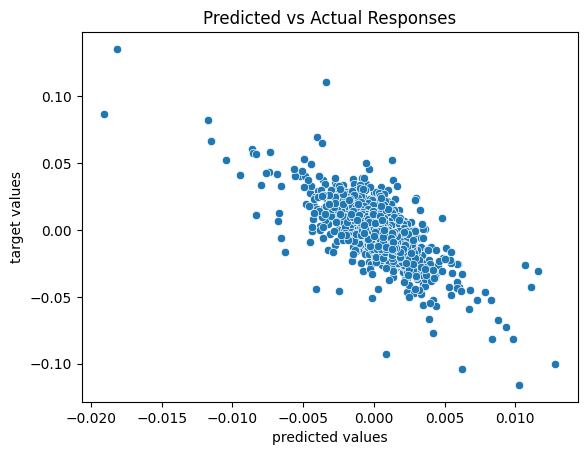

In [17]:
#linear correlation is expected of a plot between in-sample test and y_pred 

ax = sns.scatterplot(x=EN_pred_train2, y= Y_traintest.iloc[:-2])
ax.set(xlabel='predicted values', ylabel='target values',title="Predicted vs Actual Responses")

In [18]:
#notice that this shape is unconventional. it should have a gradient of +1 and it is showing -1 now.

In [19]:
Y_pred_logistic2_df = pd.DataFrame(Y_pred_logistic2, index = X_selected_df.index)

In [20]:
X_selected_df

x19       x32       x83       x96       x97       x98  \
Date                                                                     
2004-11-17  0.010320  0.010332  0.183840  0.184044  0.181786  0.179766   
2004-11-18 -0.324102 -0.326028 -5.599407 -5.632677 -5.713287 -5.783472   
2004-11-19 -0.055234 -0.054290 -0.983698 -0.966879 -0.963807 -1.002985   
2004-11-22 -0.016216 -0.016562 -0.282832 -0.288866 -0.289187 -0.289119   
2004-11-23  0.167657  0.165023  2.942794  2.896562  2.913772  3.011661   
...              ...       ...       ...       ...       ...       ...   
2023-10-23 -0.054195 -0.054243 -0.993806 -0.994697 -0.995606 -0.979085   
2023-10-24 -0.261970 -0.268232 -4.762470 -4.876307 -4.751816 -4.858158   
2023-10-25  0.025114  0.025488  0.461117  0.467982  0.455495  0.457124   
2023-10-26  0.079485  0.078525  1.475377  1.457562  1.458868  1.445027   
2023-10-27  0.448408  0.440834  8.291855  8.151798  8.346649  8.048878   

                x139      x140      x141      x142  
Date                                                
2004-11-17  0.184249  0.181988  0.179966  0.179755  
2004-11-18 -5.666144 -5.747233 -5.817835 -5.829483  
2004-11-19 -0.950348 -0.947329 -0.985837 -0.944319  
2004-11-22 -0.295030 -0.295358 -0.295288 -0.295686  
2004-11-23  2.851056  2.867996  2.964347  2.885037  
...              ...       ...       ...       ...  
2023-10-23 -0.995588 -0.996498 -0.979962 -0.997409  
2023-10-24 -4.992864 -4.865398 -4.974282 -4.741186  
2023-10-25  0.474950  0.462276  0.463930  0.449941  
2023-10-26  1.439963  1.441253  1.427579  1.442544  
2023-10-27  8.014106  8.205666  7.912925  8.401805  

[4769 rows x 10 columns]

In [21]:
X_traintest3 = X.copy()
X_traintest3["signal"] = Y_pred_logistic2_df
X_traintest3["signal"].iloc[:13] = 0

In [22]:
X_traintest3["signal"]

Date
2004-11-01    0.0
2004-11-02    0.0
2004-11-03    0.0
2004-11-04    0.0
2004-11-05    0.0
             ... 
2023-10-25    1.0
2023-10-26    1.0
2023-10-27    0.0
2023-10-30    NaN
2023-10-31    NaN
Name: signal, Length: 4783, dtype: float64

In [23]:
X_traintest3

10years futures     Volume     SPY_3     SPY_6    SPY_12  \
Date                                                                   
2004-11-01         1.408545  17.418857       NaN       NaN       NaN   
2004-11-02         1.404871  17.844605       NaN       NaN       NaN   
2004-11-03         1.403643  18.158799       NaN       NaN       NaN   
2004-11-04         1.403151  17.829193  0.005892       NaN       NaN   
2004-11-05         1.431746  17.963194 -0.013965       NaN       NaN   
...                     ...        ...       ...       ...       ...   
2023-10-25         1.599993  18.361177 -0.010312  0.001368 -0.017238   
2023-10-26         1.577947  18.561805 -0.012054  0.004282 -0.008631   
2023-10-27         1.577947  18.491770  0.026341  0.024249  0.018000   
2023-10-30         1.584120  18.276380  0.018308  0.007995  0.011254   
2023-10-31         1.584120  18.193343       NaN       NaN       NaN   

             Volume_3   Volume_6  Volume_12  signal  
Date                                                 
2004-11-01        NaN        NaN        NaN     0.0  
2004-11-02        NaN        NaN        NaN     0.0  
2004-11-03        NaN        NaN        NaN     0.0  
2004-11-04  17.418857        NaN        NaN     0.0  
2004-11-05  17.844605        NaN        NaN     0.0  
...               ...        ...        ...     ...  
2023-10-25  18.634548  18.137319  18.202206     1.0  
2023-10-26  18.337681  18.354111  18.179975     1.0  
2023-10-27  18.179427  18.613967  17.949904     0.0  
2023-10-30  18.361177  18.634548  18.211862     NaN  
2023-10-31  18.561805  18.337681  18.370893     NaN  

[4783 rows x 9 columns]

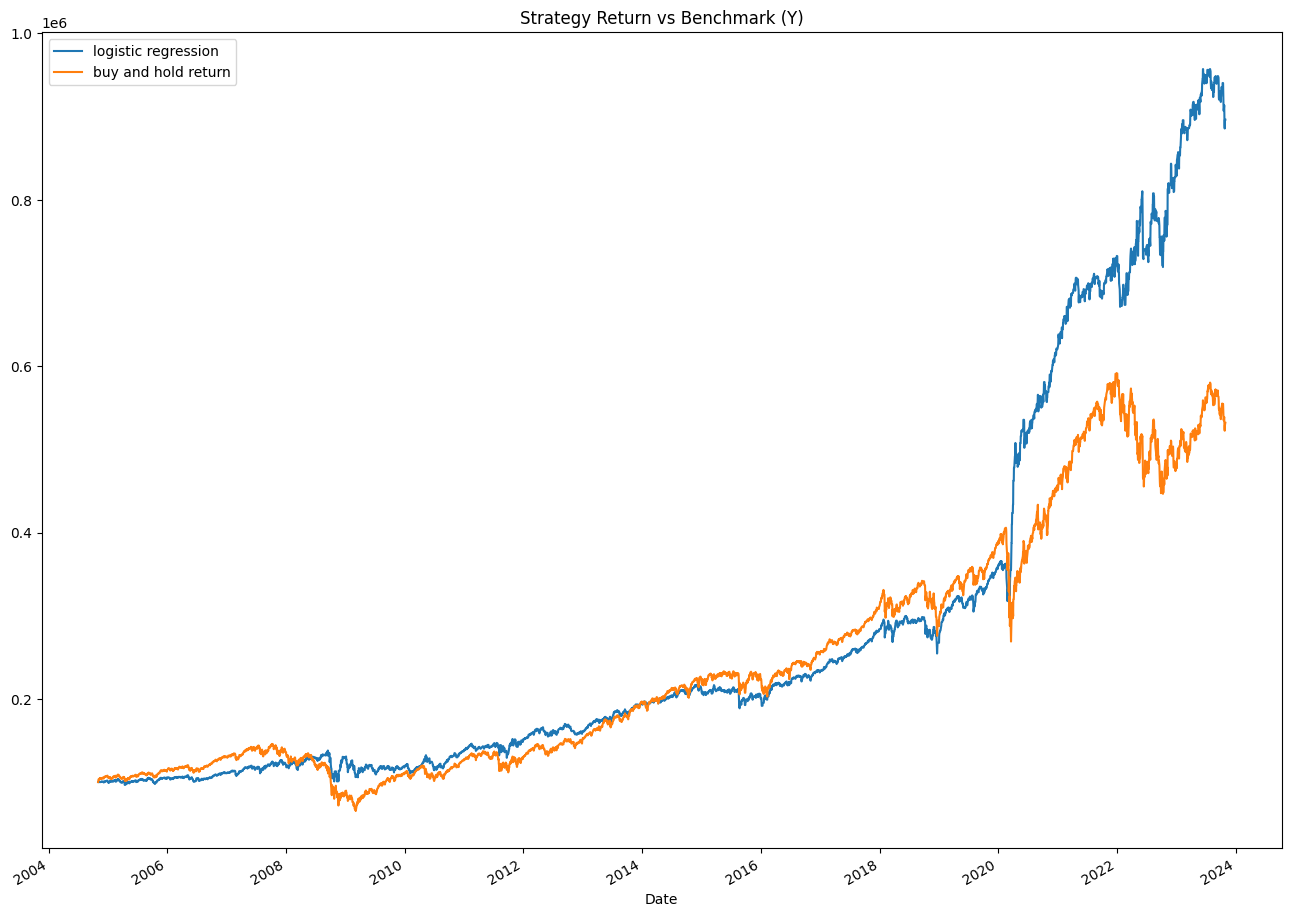

In [24]:
X_traintest3["strategy_return"] = X_traintest3["signal"].shift(1) * Y
fig,ax = plt.subplots(nrows = 1, ncols = 1, figsize = [16,12])
#((X_traintest3["strategy_return"] + 1).cumprod() * capital).plot(ax=ax, label = "logistic regression")
(X_traintest3["strategy_return"].cumsum().apply(np.exp) * capital).plot(ax=ax, label = "logistic regression")
#((1+Y).cumprod() * capital).plot(ax=ax, label = "simple return")
(Y.cumsum().apply(np.exp) * capital).plot(ax=ax, label = "buy and hold return")

# Add legend
ax.legend()

# Add title
ax.set_title('Strategy Return vs Benchmark (Y)')

# Show the plot
plt.show()
#capital * (1 + X_traintest3["strategy_return"]).cumprod().plot(figsize=[16,12])

In [25]:
cumu_ret = X_traintest3["strategy_return"].cumsum().apply(np.exp).iloc[-4]

In [26]:
X_traintest3["strategy_return"].cumsum().apply(np.exp)

Date
2004-11-01         NaN
2004-11-02    1.000000
2004-11-03    1.000000
2004-11-04    1.000000
2004-11-05    1.000000
                ...   
2023-10-25    8.896953
2023-10-26    8.856625
2023-10-27    8.962513
2023-10-30    8.962513
2023-10-31         NaN
Name: strategy_return, Length: 4783, dtype: float64

In [27]:
cumu_ret

8.856625036955762

In [28]:
X_traintest3["strategy_return"].cumsum().apply(np.exp)

Date
2004-11-01         NaN
2004-11-02    1.000000
2004-11-03    1.000000
2004-11-04    1.000000
2004-11-05    1.000000
                ...   
2023-10-25    8.896953
2023-10-26    8.856625
2023-10-27    8.962513
2023-10-30    8.962513
2023-10-31         NaN
Name: strategy_return, Length: 4783, dtype: float64

In [29]:
X_traintest3["signal"].value_counts()

signal
1.0    3217
0.0    1564
Name: count, dtype: int64

In [30]:
#what if we can short?

In [31]:
signal = X_traintest3["signal"].copy()
short_signal = (signal == 0) * -1 
signals = short_signal + signal

signals.iloc[:12] = 0
signals.value_counts()
#X_traintest3["signal"].iloc[:12] = 0
#X_traintest3["signal"].value_counts()


signal
 1.0    3217
-1.0    1552
 0.0      12
Name: count, dtype: int64

In [32]:
X_traintest3_copy = X_traintest3.copy()
X_traintest3_copy["signal"] = signals

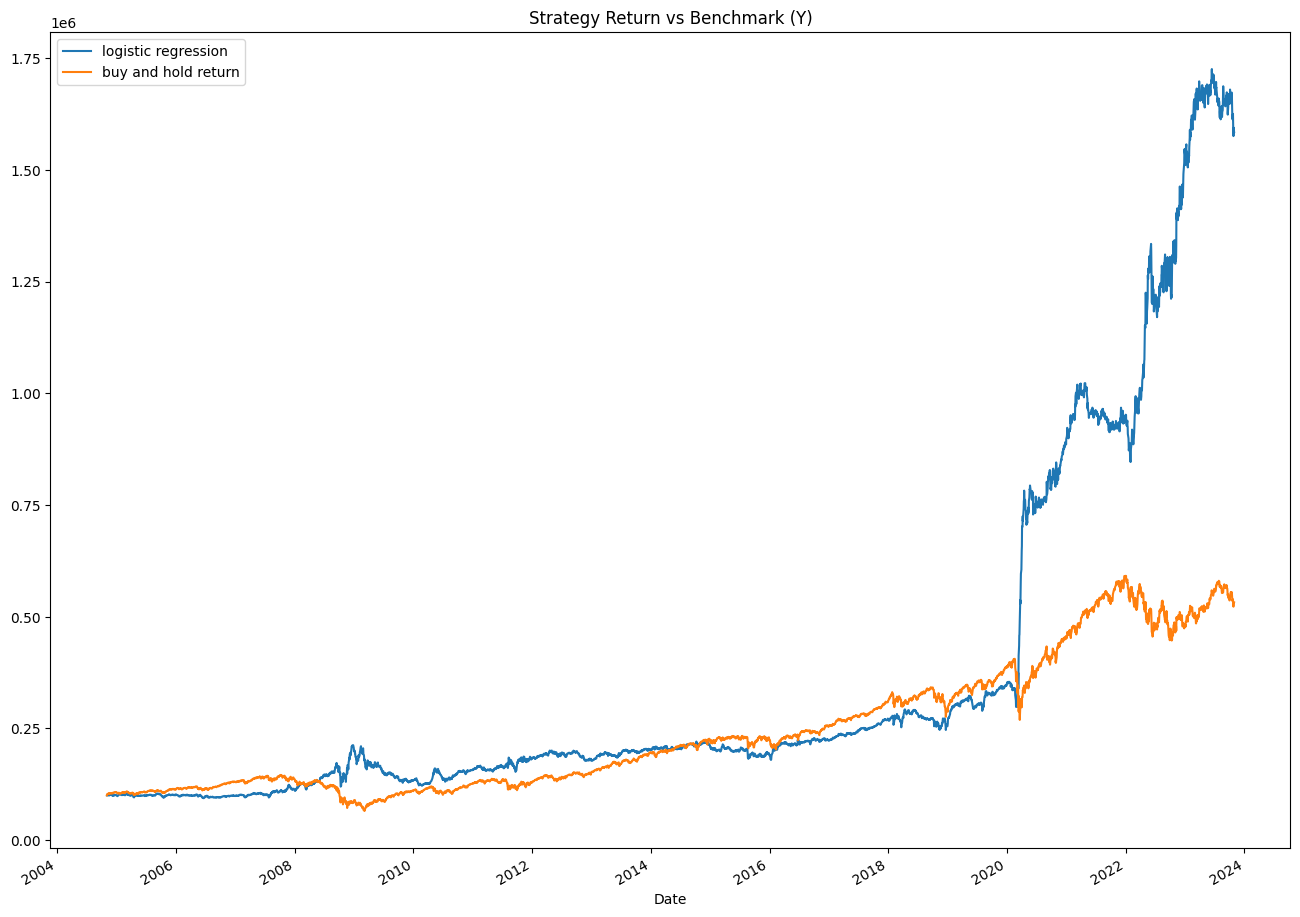

In [33]:
X_traintest3["strategy_return"] = X_traintest3_copy["signal"].shift(1) * Y

fig,ax = plt.subplots(nrows = 1, ncols = 1, figsize = [16,12])

(X_traintest3["strategy_return"].cumsum().apply(np.exp) * capital).plot(ax=ax, label = "logistic regression")

(Y.cumsum().apply(np.exp) * capital).plot(ax=ax, label = "buy and hold return")

# Add legend
ax.legend()

# Add title
ax.set_title('Strategy Return vs Benchmark (Y)')

# Show the plot
plt.show()


In [34]:
#cumu_ret_w_short = ((X_traintest3["strategy_return"] + 1).cumprod() * capital).iloc[-3]

In [35]:
cumu_ret_w_short = X_traintest3["strategy_return"].cumsum().apply(np.exp).iloc[-4]
X_traintest3["strategy_return"].cumsum().apply(np.exp)

Date
2004-11-01          NaN
2004-11-02     1.000000
2004-11-03     1.000000
2004-11-04     1.000000
2004-11-05     1.000000
                ...    
2023-10-25    15.826165
2023-10-26    15.754428
2023-10-27    15.942785
2023-10-30    15.843285
2023-10-31          NaN
Name: strategy_return, Length: 4783, dtype: float64

In [36]:
X_traintest3["strategy_return"].cumsum().apply(np.exp)

Date
2004-11-01          NaN
2004-11-02     1.000000
2004-11-03     1.000000
2004-11-04     1.000000
2004-11-05     1.000000
                ...    
2023-10-25    15.826165
2023-10-26    15.754428
2023-10-27    15.942785
2023-10-30    15.843285
2023-10-31          NaN
Name: strategy_return, Length: 4783, dtype: float64

In [37]:
cumu_ret_w_short

15.75442839247994

In [38]:
(cumu_ret_w_short - cumu_ret)/ max(cumu_ret_w_short, cumu_ret)

0.4378326641680447

In [39]:
(cumu_ret_w_short - cumu_ret)/ cumu_ret

0.7788297829864006

# with optimization of the decision threshold value and best k of feature engineering and alpha in elastic net

In [40]:
X_traintest

10years futures     Volume     SPY_3     SPY_6    SPY_12  \
Date                                                                   
2004-11-17         1.421662  17.813601 -0.001105  0.000579  0.000996   
2004-11-18         1.415125  17.276683 -0.003994 -0.018760 -0.023694   
2004-11-19         1.434132  17.809602 -0.001162 -0.003101 -0.008804   
2004-11-22         1.426716  17.441456  0.000176 -0.000930 -0.004720   
2004-11-23         1.431268  17.552437  0.013546  0.009552  0.003817   
...                     ...        ...       ...       ...       ...   
2023-10-25         1.599993  18.361177 -0.010312  0.001368 -0.017238   
2023-10-26         1.577947  18.561805 -0.012054  0.004282 -0.008631   
2023-10-27         1.577947  18.491770  0.026341  0.024249  0.018000   
2023-10-30         1.584120  18.276380  0.018308  0.007995  0.011254   
2023-10-31         1.584120  18.193343  0.018308  0.007995  0.011254   

             Volume_3   Volume_6  Volume_12  
Date                                         
2004-11-17  17.833401  17.614546  17.418857  
2004-11-18  17.379334  17.628054  17.844605  
2004-11-19  17.505107  17.449490  18.158799  
2004-11-22  17.813601  17.833401  17.829193  
2004-11-23  17.276683  17.379334  17.963194  
...               ...        ...        ...  
2023-10-25  18.634548  18.137319  18.202206  
2023-10-26  18.337681  18.354111  18.179975  
2023-10-27  18.179427  18.613967  17.949904  
2023-10-30  18.361177  18.634548  18.211862  
2023-10-31  18.561805  18.337681  18.370893  

[4771 rows x 8 columns]

In [41]:
#transform X_selected into dataframe

X_selected_df = pd.DataFrame(X_selected, columns = X_columns, index = X_traintest.iloc[:-2].index)
X_selected_df

x19       x32       x83       x96       x97       x98  \
Date                                                                     
2004-11-17  0.010320  0.010332  0.183840  0.184044  0.181786  0.179766   
2004-11-18 -0.324102 -0.326028 -5.599407 -5.632677 -5.713287 -5.783472   
2004-11-19 -0.055234 -0.054290 -0.983698 -0.966879 -0.963807 -1.002985   
2004-11-22 -0.016216 -0.016562 -0.282832 -0.288866 -0.289187 -0.289119   
2004-11-23  0.167657  0.165023  2.942794  2.896562  2.913772  3.011661   
...              ...       ...       ...       ...       ...       ...   
2023-10-23 -0.054195 -0.054243 -0.993806 -0.994697 -0.995606 -0.979085   
2023-10-24 -0.261970 -0.268232 -4.762470 -4.876307 -4.751816 -4.858158   
2023-10-25  0.025114  0.025488  0.461117  0.467982  0.455495  0.457124   
2023-10-26  0.079485  0.078525  1.475377  1.457562  1.458868  1.445027   
2023-10-27  0.448408  0.440834  8.291855  8.151798  8.346649  8.048878   

                x139      x140      x141      x142  
Date                                                
2004-11-17  0.184249  0.181988  0.179966  0.179755  
2004-11-18 -5.666144 -5.747233 -5.817835 -5.829483  
2004-11-19 -0.950348 -0.947329 -0.985837 -0.944319  
2004-11-22 -0.295030 -0.295358 -0.295288 -0.295686  
2004-11-23  2.851056  2.867996  2.964347  2.885037  
...              ...       ...       ...       ...  
2023-10-23 -0.995588 -0.996498 -0.979962 -0.997409  
2023-10-24 -4.992864 -4.865398 -4.974282 -4.741186  
2023-10-25  0.474950  0.462276  0.463930  0.449941  
2023-10-26  1.439963  1.441253  1.427579  1.442544  
2023-10-27  8.014106  8.205666  7.912925  8.401805  

[4769 rows x 10 columns]

In [42]:
#Feature Engineering

from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import SelectKBest, f_regression

# poly = PolynomialFeatures(degree=3)

# index_ = Y_traintest.shift(-1).dropna().index 

# X_poly = poly.fit_transform(X_traintest.loc[index_])


# from sklearn.feature_selection import SelectKBest, f_regression
# #(R-squared / (1 - R-squared)) * ((n - k - 1) / k)

# selector = SelectKBest(score_func=f_regression, k=10) #marginal improvement from when k = 8. big improvement from k = 5

# #we are shifting the Y values because we need to train the model for a 1 day look ahead
# X_selected = selector.fit_transform(X_poly, Y_traintest.shift(-1).loc[index_]) #Y_traintest_binary

# X_columns = selector.get_feature_names_out()

# #transform X_selected into dataframe

# X_selected_df = pd.DataFrame(X_selected, columns = X_columns, index = X_traintest.iloc[:-2].index)

# #initiate dictionary to hold data from df.loc[:year]
# df_dict = {}
# columns = X_selected_df.columns 
# X_selected_df = X_selected_df.ffill()




#initiate dictionary to hold data from df.loc[:year]
df_dict = {}

years_in_data = pd.unique(X_selected_df.index.year)

for year_ in years_in_data:
    
    #dont need mask because our data are complete but lets do it anyway for completeness of code
    mask = X_traintest.columns[X_traintest.apply(lambda col: col.loc[X_traintest.index.year == year_].isna().mean() < 0.3)]
    
    X_traintest_to_year = X_traintest.loc[:str(year_), mask].copy()
    
    
    #Feature scaling, consideration of not removing mean so that the values wont go into negative
#     X_traintest_to_year =\
#     (
#         X_traintest_to_year
#         /
#         X_traintest_to_year.max()
#     )
    
    Y_traintest_to_year = Y_traintest.loc[:str(year_)]
    
    poly = PolynomialFeatures(degree=3)
    
    #we are shifting the Y values because we need to train the model for a 1 day look ahead
    index_ =\
    (Y_traintest_to_year
     .shift(-1)
     .dropna()
     .index 
    )

    X_poly = poly.fit_transform(X_traintest_to_year.loc[index_])  
    #(R-squared / (1 - R-squared)) * ((n - k - 1) / k)

    selector = SelectKBest(score_func=f_regression, k=10) 
    
    X_selected = selector.fit_transform(X_poly, Y_traintest.shift(-1).loc[index_]) #Y_traintest_binary

    X_columns = selector.get_feature_names_out()

    #transform X_selected into dataframe

    X_selected_df = pd.DataFrame(X_selected, columns = X_columns, index = index_)

    #make sure no missing values
    X_selected_df = X_selected_df.ffill()
    
    #columns = X_selected_df.columns 
    
    df_dict[year_] = X_selected_df

In [43]:
df_dict[2004]

x18         x23       x28         x59       x82       x91  \
Date                                                                         
2004-11-17 -0.019693  310.292565 -0.019473  441.130999 -0.350802 -0.351192   
2004-11-18 -0.069006  308.295587 -0.070409  436.276721 -1.192190 -1.199273   
2004-11-19 -0.020699  323.400981 -0.020281  463.799603 -0.368644 -0.362341   
2004-11-22  0.003065  310.967071  0.003134  443.661778  0.053466  0.054607   
2004-11-23  0.237764  315.297826  0.235420  451.275603  4.173345  4.107781   
2004-11-24 -0.094960  298.341043 -0.096602  427.789247 -1.634020 -1.691196   
2004-11-26 -0.100946  291.618620 -0.108616  421.123952 -1.671210 -1.760638   
2004-11-29 -0.030268  316.139927 -0.029159  463.324411 -0.542822 -0.531276   
2004-11-30  0.214702  310.577333  0.214834  457.173931  3.821407  3.694485   
2004-12-01  0.095907  316.105897  0.094370  466.542754  1.699999  1.587794   
2004-12-02 -0.024172  311.308649 -0.023686  461.023968 -0.432987 -0.433503   
2004-12-03 -0.206091  309.992966 -0.200258  449.990075 -3.649607 -3.668142   
2004-12-06 -0.176469  308.405843 -0.168749  445.511736 -3.055200 -3.128003   
2004-12-07  0.115425  306.966255  0.116505  442.489579  2.050826  2.067553   
2004-12-08  0.068007  313.401144  0.068785  444.793138  1.196734  1.204310   
2004-12-09  0.185721  312.640149  0.183653  445.748374  3.329071  3.215377   
2004-12-10  0.050431  310.382102  0.051085  442.155788  0.891772  0.896035   
2004-12-13 -0.000808  300.567280 -0.000819  427.812220 -0.014110 -0.014215   
2004-12-14 -0.004573  290.404677 -0.004514  412.014988 -0.080218 -0.081973   
2004-12-15 -0.163475  316.699180 -0.164478  444.999138 -2.886839 -2.890746   
2004-12-16 -0.180706  316.101174 -0.179052  452.500946 -3.209306 -3.156430   
2004-12-17 -0.008923  320.385376 -0.008849  460.313610 -0.161280 -0.156518   
2004-12-20  0.145781  316.508731  0.145892  454.141405  2.575896  2.574380   
2004-12-21  0.157523  306.624084  0.158909  437.686365  2.727485  2.797579   
2004-12-22  0.008532  298.916951  0.008669  429.042268  0.147316  0.154221   
2004-12-23 -0.166219  303.114566 -0.172058  436.291305 -2.835677 -2.937027   
2004-12-27  0.052606  302.934983  0.054272  441.230794  0.905605  0.910867   
2004-12-28  0.012536  304.175357  0.013353  443.037423  0.212733  0.216447   
2004-12-29  0.002971  299.476204  0.003100  438.348789  0.050315  0.050684   
2004-12-30 -0.128345  294.561974 -0.131778  427.106951 -2.164363 -2.209432   

                 x92      x124      x125      x127  
Date                                                
2004-11-17 -0.346882 -0.351582 -0.347267 -0.343006  
2004-11-18 -1.216437 -1.206399 -1.223664 -1.241176  
2004-11-19 -0.361190 -0.356146 -0.355014 -0.353886  
2004-11-22  0.054668  0.055772  0.055834  0.055896  
2004-11-23  4.132188  4.043246  4.067270  4.091436  
2004-11-24 -1.662282 -1.750373 -1.720447 -1.691032  
2004-11-26 -1.798204 -1.854851 -1.894427 -1.934848  
2004-11-29 -0.522929 -0.519975 -0.511806 -0.503765  
2004-11-30  3.823759  3.571778  3.696758  3.826112  
2004-12-01  1.672757  1.482994  1.562350  1.645952  
2004-12-02 -0.424282 -0.434019 -0.424787 -0.415752  
2004-12-03 -3.546310 -3.686770 -3.564319 -3.445936  
2004-12-06 -2.921545 -3.202542 -2.991163 -2.793737  
2004-12-07  2.070016  2.084416  2.086899  2.089384  
2004-12-08  1.210426  1.211934  1.218088  1.224274  
2004-12-09  3.291997  3.105566  3.179569  3.255336  
2004-12-10  0.903343  0.900318  0.907661  0.915064  
2004-12-13 -0.014305 -0.014321 -0.014411 -0.014503  
2004-12-14 -0.079174 -0.083767 -0.080907 -0.078144  
2004-12-15 -2.904564 -2.894658 -2.908494 -2.922397  
2004-12-16 -3.179936 -3.104425 -3.127544 -3.150835  
2004-12-17 -0.159944 -0.151898 -0.155222 -0.158619  
2004-12-20  2.577864  2.572865  2.576347  2.579833  
2004-12-21  2.751486  2.869474  2.822197  2.775698  
2004-12-22  0.149668  0.161450  0.156684  0.152058  
2004-12-23 -2.935298 -3.041999 -3.040208 -3.038419  
2004-12-27  0.934276  0.916160  0.93

In [44]:
# Model Specification

penalty_ = 0.0

def fit_and_predict(df_dict,Y_traintest_series,penalty_):
    params_dict = {}
    
    for year_ in years_in_data:
        
        X_index = df_dict[year_].index 
        Y_traintest_series_fraction = Y_traintest_series.loc[X_index]

        elastic_net = ElasticNet(alpha=0.01, l1_ratio=penalty_)

        elastic_net.fit(df_dict[year_], Y_traintest_series_fraction)
        print("intercept is {:.3f} and coefficients are {}".format(elastic_net.intercept_, elastic_net.coef_))

        EN_pred_train2 = elastic_net.predict(df_dict[year_])


        #continuous predictions are turned into binary signal or 1 and 0 
        Y_pred_binary2 = (EN_pred_train2 > 0.0).astype(int)


        logreg_sk2 = LogisticRegression(penalty='elasticnet', l1_ratio=penalty_, solver = "saga")
        logreg_sk2.fit(df_dict[year_], Y_pred_binary2)
        print("intercept is {:.3f} and coefficients are {}".format(logreg_sk2.intercept_[0], logreg_sk2.coef_[0]))
        

        Y_pred_logistic2 = logreg_sk2.predict(df_dict[year_])

        Y_pred_logistic2_df = pd.DataFrame(Y_pred_logistic2, index = df_dict[year_].index)

        params_dict[f"EN_pred_{year_}"] = EN_pred_train2
        params_dict[f"binary_pred_{year_}"] = Y_pred_binary2
        params_dict[f"logistic_pred_{year_}"] = Y_pred_logistic2_df

        params_dict[f"Accuracy_{year_}"] = metrics.accuracy_score(Y_traintest_binary.loc[X_index], Y_pred_logistic2)
        params_dict[f"Precision_{year_}"] = metrics.precision_score(Y_traintest_binary.loc[X_index],Y_pred_logistic2)
        params_dict[f"Recall_{year_}"] = metrics.recall_score(Y_traintest_binary.loc[X_index],Y_pred_logistic2)
                                                            
        print("Name of features used: {}".format(elastic_net.feature_names_in_))
        print(" ")
        print("Accuracy :", metrics.accuracy_score(Y_traintest_binary.loc[X_index], Y_pred_logistic2))
        print(" ")
        print("Precision :", metrics.precision_score(Y_traintest_binary.loc[X_index],Y_pred_logistic2))
        print(" ")
        print("Recall :", metrics.recall_score(Y_traintest_binary.loc[X_index],Y_pred_logistic2))
        
        #long only
        
        
        X_traintest3 = X.copy()
        X_traintest3["signal"] = Y_pred_logistic2_df
        X_traintest3["signal"].iloc[:12] = 0
        
#             X_traintest3 = df_dict[year_].copy()
#             X_traintest3["signal"] = Y_pred_logistic2_df
#             X_traintest3["signal"].iloc[:13] = 0

#             signal = X_traintest3["signal"].copy()
#             short_signal = (signal == 0) * -1 
#             signals = short_signal + signal
#             signals.iloc[:12] = 0

#             X_traintest3_copy = X_traintest3.copy()
#             X_traintest3_copy["signal"] = signals
        

        X_traintest3["strategy_return"] = X_traintest3["signal"].shift(1) * Y
        fig,ax = plt.subplots(nrows = 1, ncols = 1, figsize = [16,12])

        (X_traintest3["strategy_return"].cumsum().apply(np.exp) * capital).plot(ax=ax, label = "logistic regression")

        (Y.loc[X_index].cumsum().apply(np.exp) * capital).plot(ax=ax, label = "buy and hold return")

        ax.legend()
        ax.set_title('Strategy Return vs Benchmark (Y)')
        plt.show()
    
    return params_dict, X_traintest3

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.102e-04, tolerance: 6.962e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


intercept is -0.039 and coefficients are [-1.53986361e-04  6.22301899e-05 -2.31674849e-04  4.58922916e-05
  2.23770310e-03  9.05241389e-04  3.67849949e-04 -1.09068031e-03
 -9.85396258e-04 -9.58854056e-04]
intercept is -0.000 and coefficients are [ 0.00075187 -0.00471181  0.00075478  0.00396557  0.01312332  0.01316976
  0.01316953  0.01322556  0.01322039  0.01322501]
Name of features used: ['x18' 'x23' 'x28' 'x59' 'x82' 'x91' 'x92' 'x124' 'x125' 'x127']
 
Accuracy : 0.6333333333333333
 
Precision : 0.6333333333333333
 
Recall : 1.0


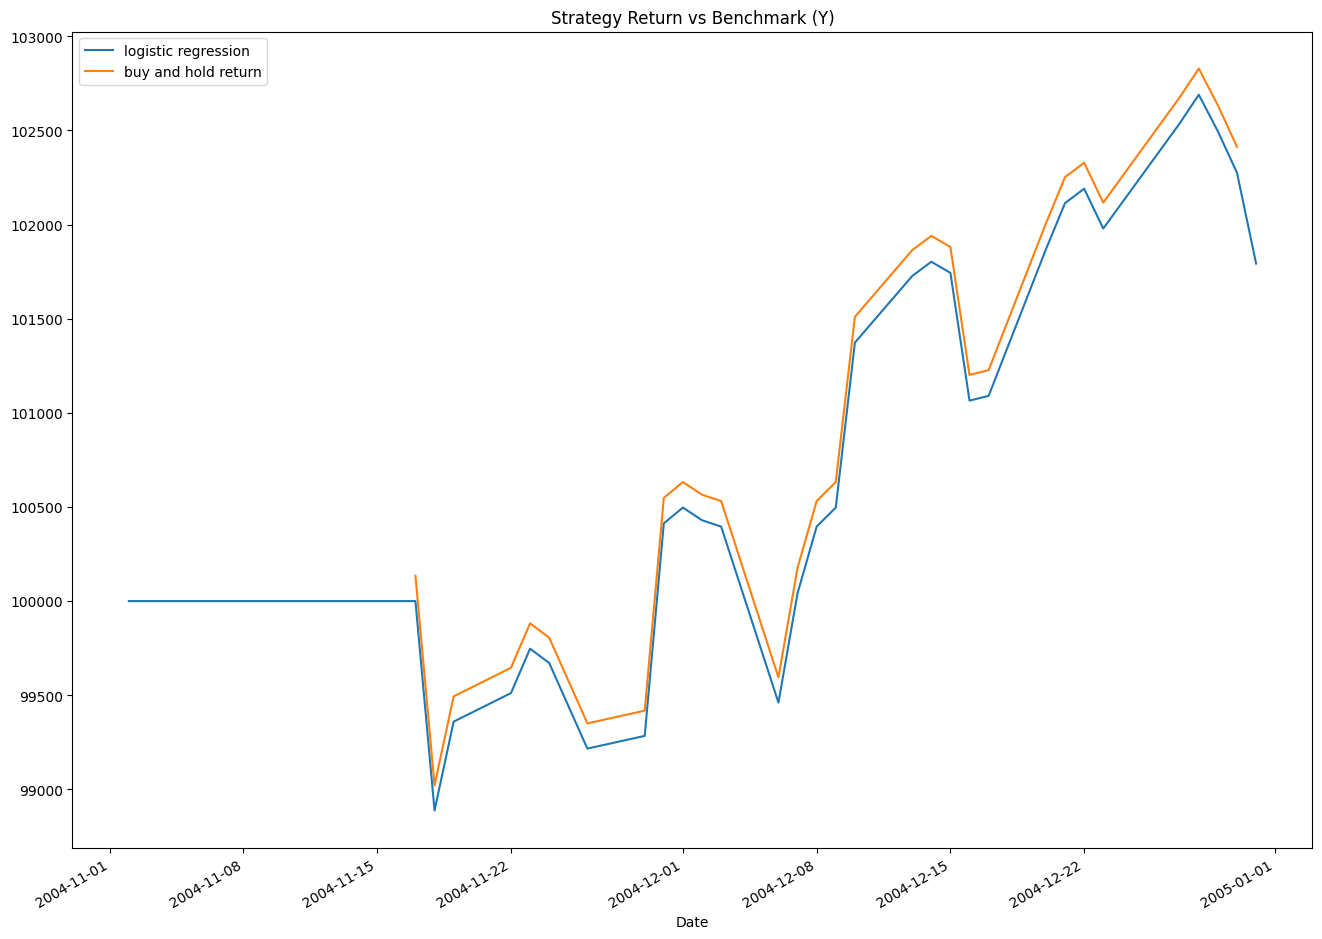

intercept is 0.000 and coefficients are [ 6.66956547e-06  9.10918355e-05 -1.20616699e-05  1.19283748e-04
 -1.39243642e-04  1.35764816e-03 -1.66413448e-07 -1.12079964e-07
 -8.92073317e-08 -1.57955186e-03]
intercept is 4.919 and coefficients are [-8.10092272e-03 -1.06946019e-01 -1.13488808e-02 -1.38503920e-01
 -1.49953971e-01 -1.83348438e+00  2.51503849e-06 -2.29237350e-07
 -1.28378230e-06 -1.97375366e+00]
Name of features used: ['x13' 'x36' 'x49' 'x56' 'x72' 'x100' 'x109' 'x110' 'x115' 'x149']
 
Accuracy : 0.34397163120567376
 
Precision : 0.42487046632124353
 
Recall : 0.5256410256410257


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.728e-03, tolerance: 1.158e-06 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


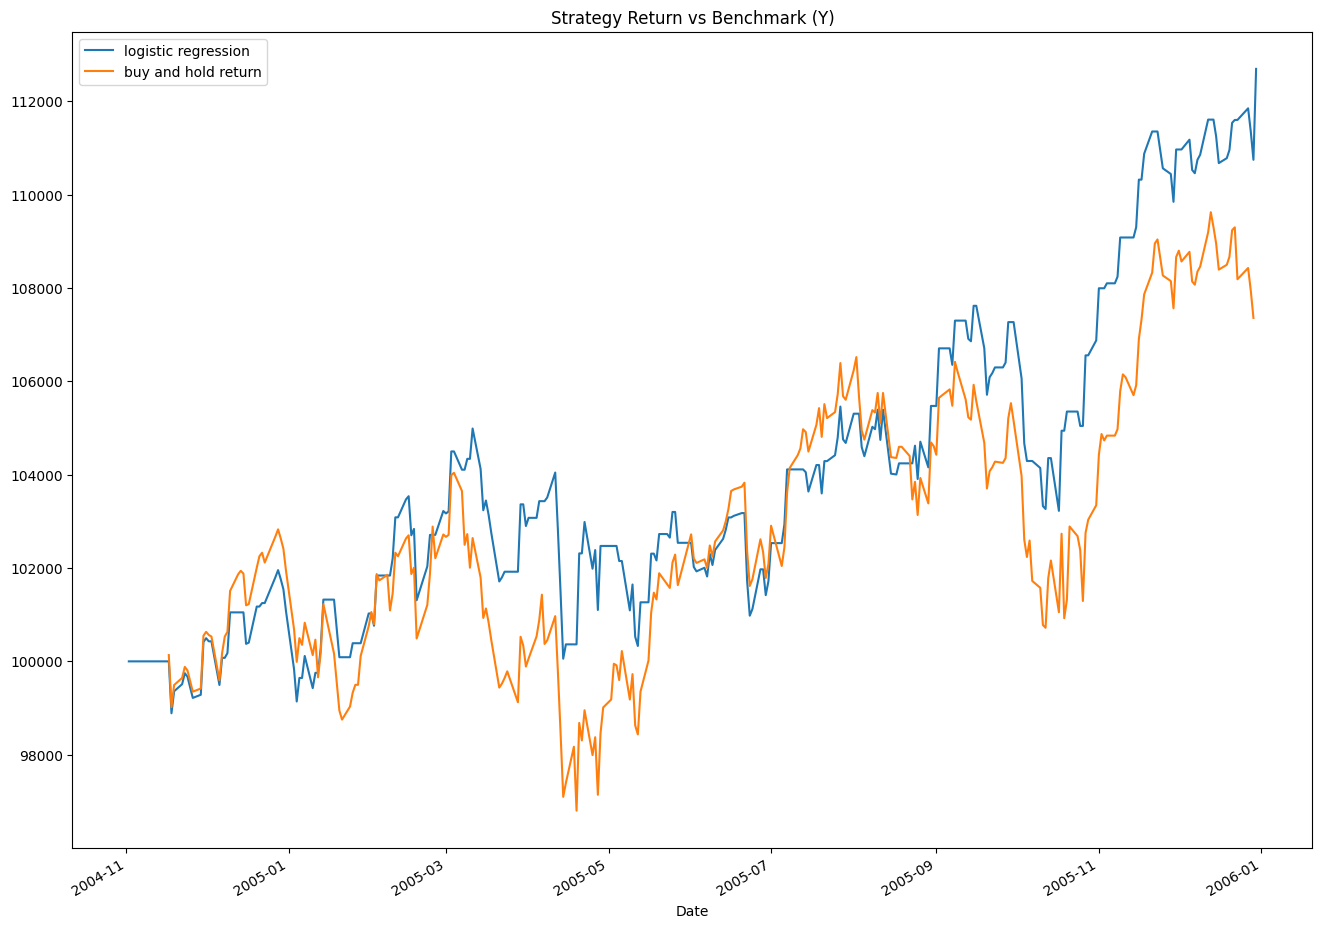

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.053e-02, tolerance: 2.124e-06 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


intercept is -0.008 and coefficients are [-3.61073221e-04 -2.53969340e-04  2.72805309e-04 -2.00312979e-07
 -1.24130975e-07 -1.45668849e-07 -1.39325300e-07  1.57676308e-05
 -3.87181784e-07 -1.38415804e-05]
intercept is -0.000 and coefficients are [-9.62739415e-05 -6.97039842e-04 -1.04250749e-03 -3.44870824e-11
 -6.20143361e-12  1.97156829e-11  2.06677142e-11  5.61015479e-03
 -4.87660540e-03 -3.88982577e-04]
Name of features used: ['x6' 'x39' 'x41' 'x109' 'x110' 'x111' 'x115' 'x155' 'x156' 'x157']
 
Accuracy : 0.551594746716698
 
Precision : 0.5551330798479087
 
Recall : 0.9831649831649831


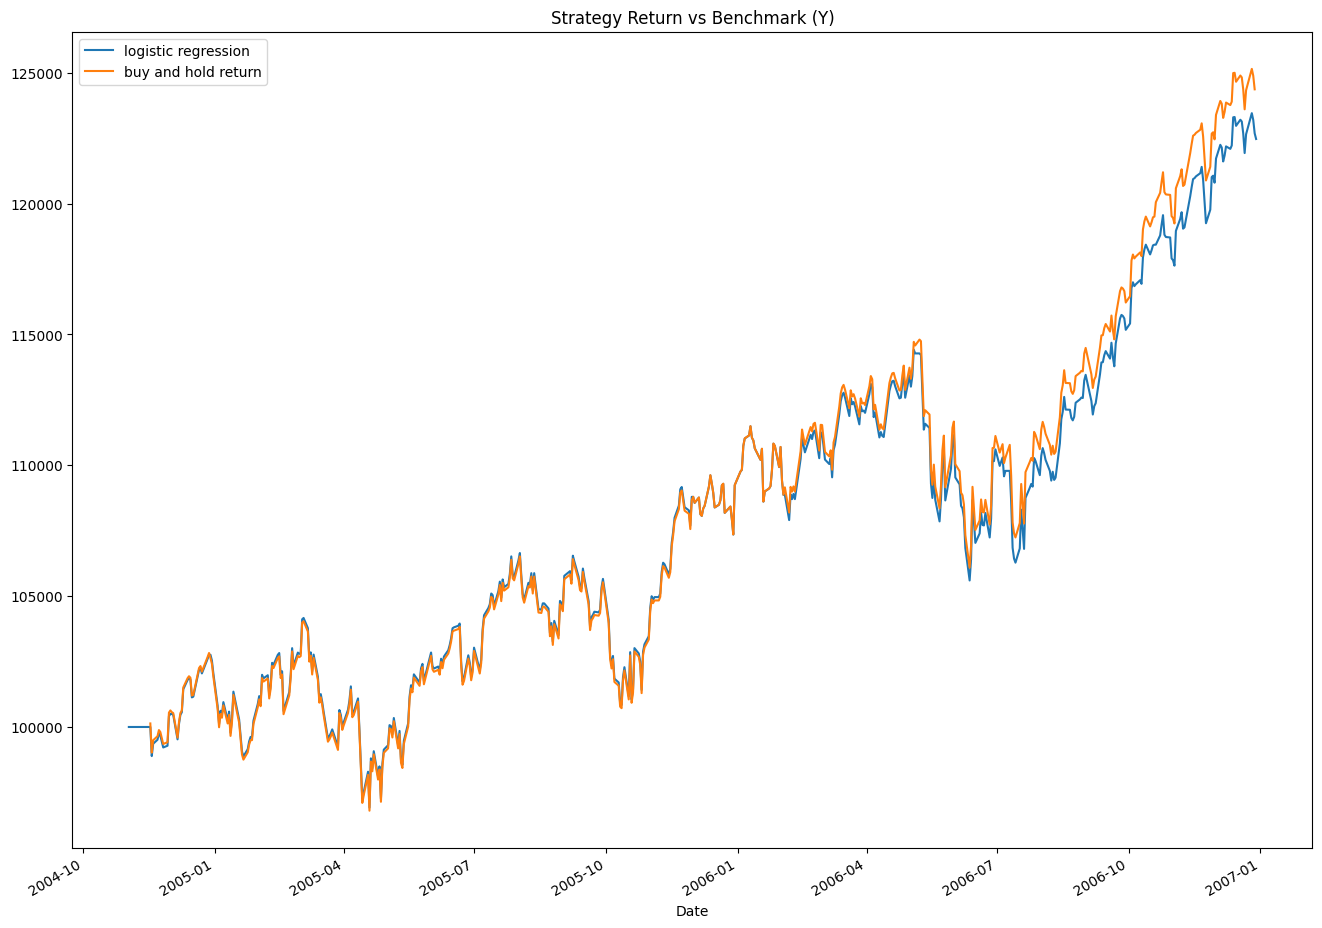

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.298e-02, tolerance: 4.655e-06 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


intercept is 0.000 and coefficients are [ 1.68425547e-04  5.28947021e-05 -1.10311095e-04  3.45715611e-04
 -2.37726254e-07 -1.89042593e-07  4.19598939e-04 -1.09968635e-03
 -1.58250987e-03  1.68873792e-03]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


intercept is 3.797 and coefficients are [-2.41817108e-02 -2.75207973e-02 -3.55944568e-02 -4.65515009e-01
 -1.01359590e-07 -2.13186857e-07 -4.04771630e-01 -5.01568846e-01
 -5.98381709e-01 -3.70204627e-01]
Name of features used: ['x56' 'x72' 'x73' 'x101' 'x111' 'x116' 'x149' 'x150' 'x152' 'x153']
 
Accuracy : 0.3635204081632653
 
Precision : 0.44405594405594406
 
Recall : 0.5839080459770115


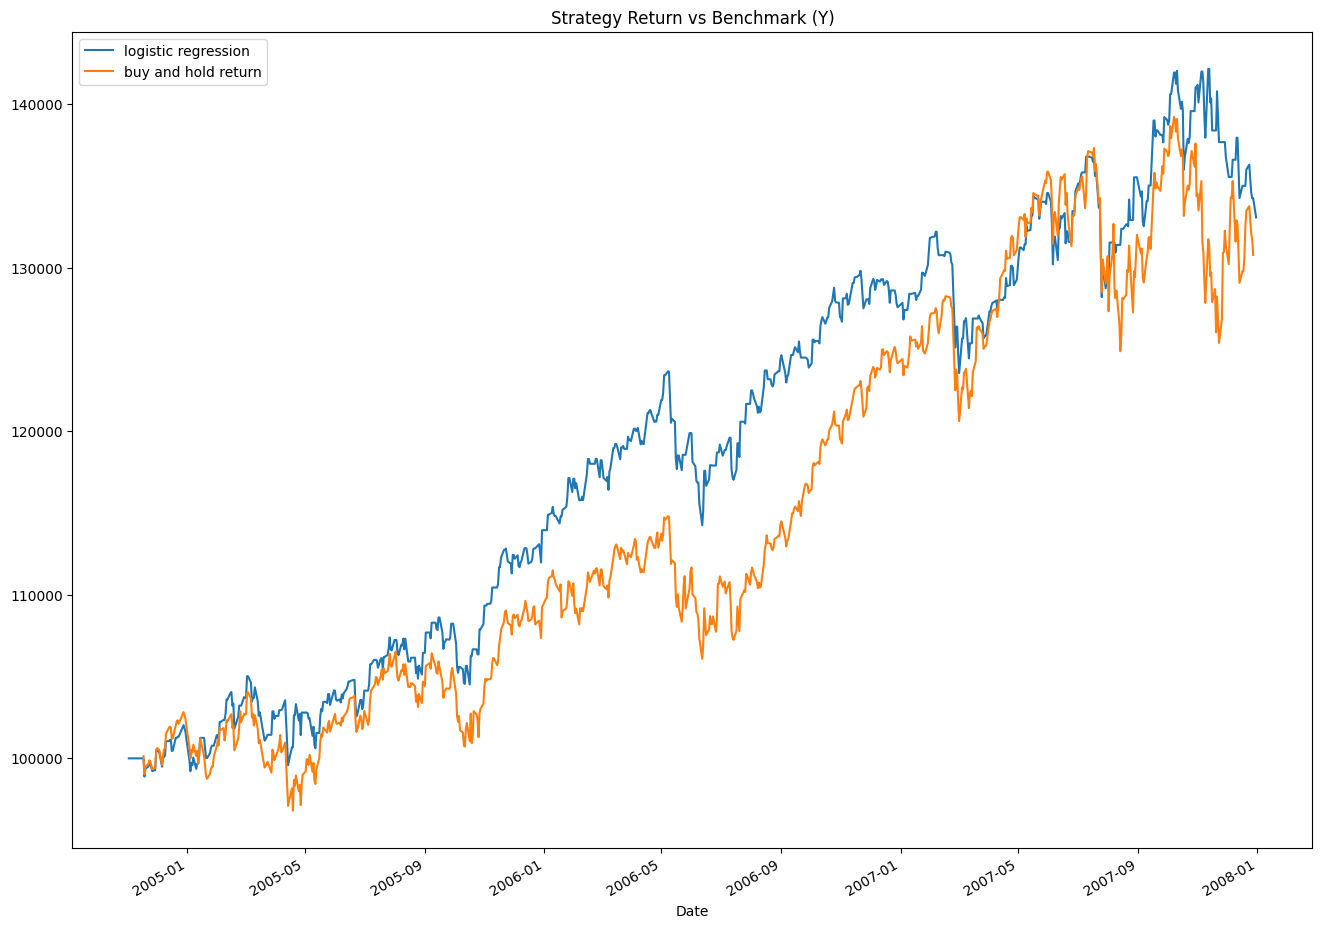

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.076e-01, tolerance: 2.176e-05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


intercept is 0.000 and coefficients are [-0.00030633 -0.00039696 -0.00011281 -0.00606567 -0.00163652 -0.00614226
 -0.00614009 -0.00612274 -0.00166413 -0.00166646]
intercept is 0.580 and coefficients are [-0.13075993 -0.17622164 -0.08873248 -2.52972424 -1.29012011 -2.53226361
 -2.52648294 -2.52416983 -1.29169908 -1.28332734]
Name of features used: ['x30' 'x66' 'x67' 'x94' 'x95' 'x132' 'x133' 'x134' 'x136' 'x138']
 
Accuracy : 0.5438765670202508
 
Precision : 0.5436507936507936
 
Recall : 0.9768270944741533


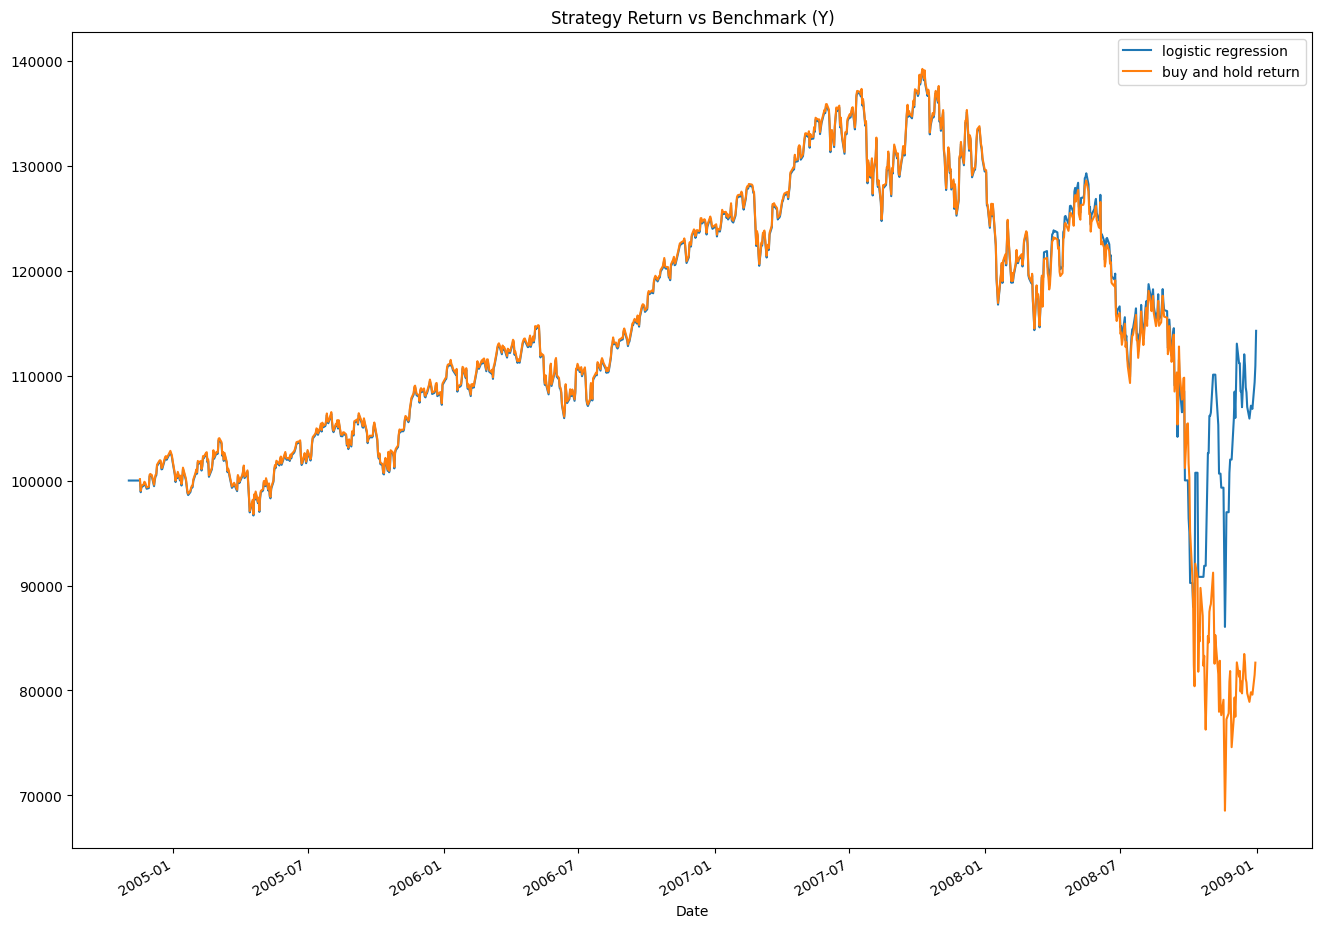

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.416e-01, tolerance: 2.878e-05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


intercept is 0.000 and coefficients are [-0.00024781  0.00035245 -0.00032776 -0.00488935 -0.00496462 -0.00497963
 -0.00495017 -0.00061348  0.00015835  0.00025626]
intercept is 0.925 and coefficients are [-0.00233299 -0.02793052 -0.00297963 -0.04610067 -0.0463619  -0.04656706
 -0.04621982 -0.37767872 -0.36910033 -0.36124756]
Name of features used: ['x30' 'x36' 'x66' 'x94' 'x132' 'x133' 'x134' 'x149' 'x150' 'x152']
 
Accuracy : 0.26764934057408846
 
Precision : 0.3416230366492147
 
Recall : 0.3717948717948718


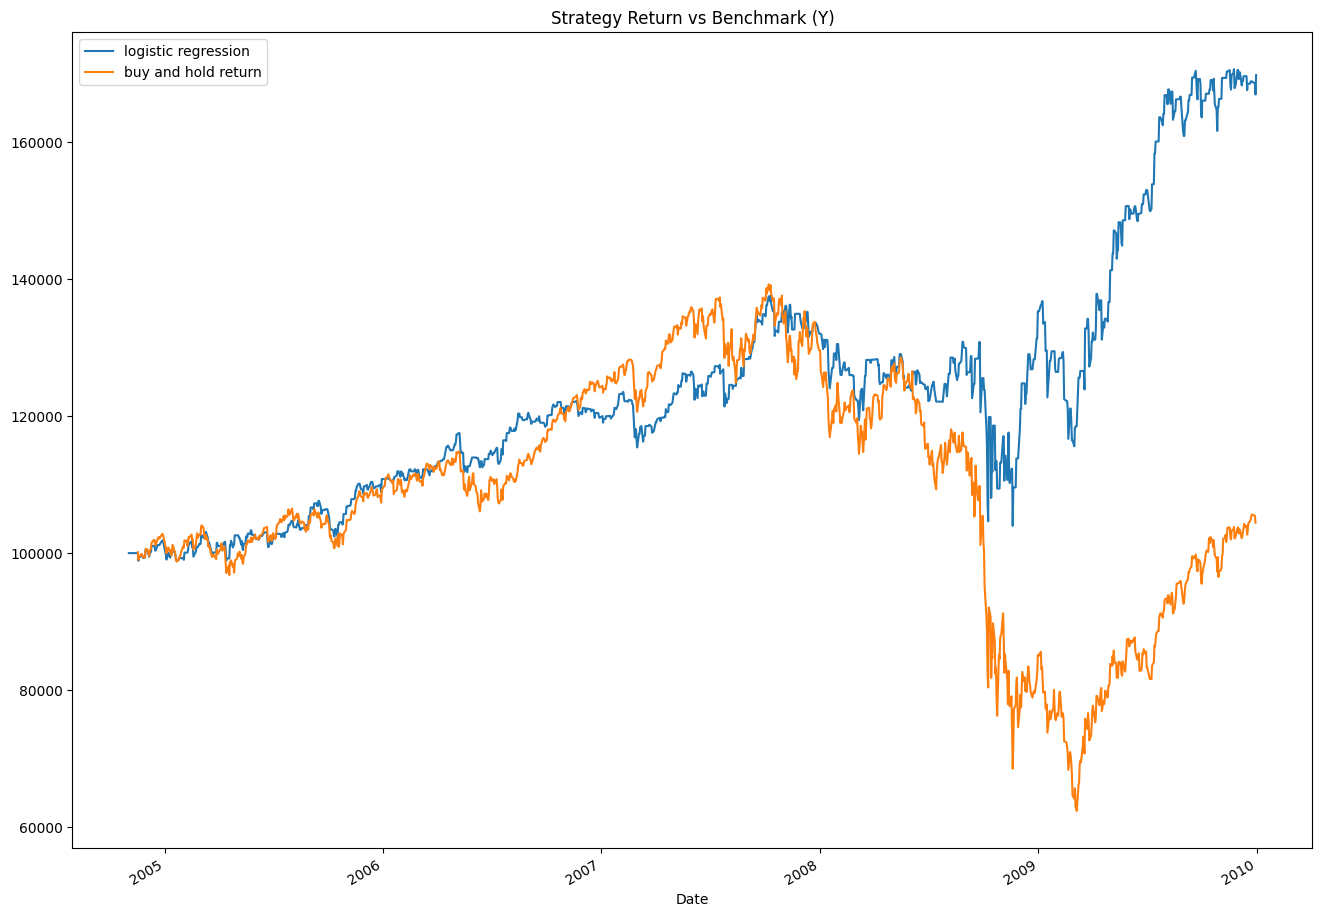

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.578e-01, tolerance: 3.197e-05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


intercept is 0.000 and coefficients are [-0.00021352  0.00040914 -0.00028308 -0.00421576 -0.00428112 -0.00429526
 -0.00427059 -0.0009182   0.00029572  0.00043843]
intercept is 1.304 and coefficients are [-0.00274254 -0.02737679 -0.00349802 -0.05410821 -0.05437854 -0.05487193
 -0.05422105 -0.36447207 -0.31028282 -0.25566817]
Name of features used: ['x30' 'x36' 'x66' 'x94' 'x132' 'x133' 'x134' 'x149' 'x150' 'x152']
 
Accuracy : 0.31343283582089554
 
Precision : 0.39520958083832336
 
Recall : 0.4669811320754717


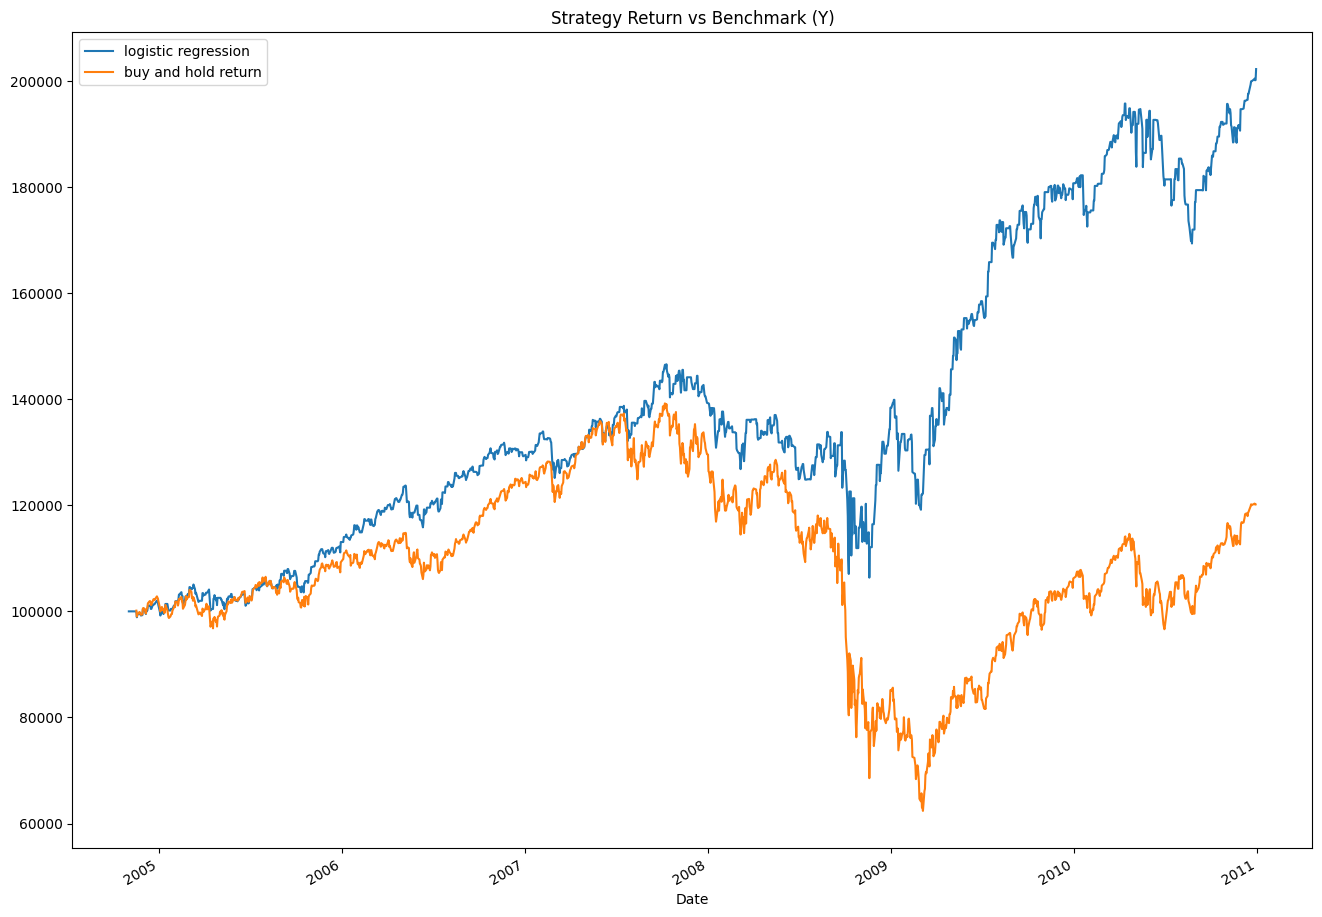

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.839e-01, tolerance: 3.730e-05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


intercept is 0.000 and coefficients are [-0.00018281  0.00035598 -0.00024884 -0.00360713  0.00136454 -0.00367019
 -0.00369251 -0.00366581 -0.00236386  0.00081158]
intercept is 1.534 and coefficients are [-0.00184412 -0.02514821 -0.00218894 -0.03641785 -0.40180305 -0.03660311
 -0.03695547 -0.03637291 -0.46414097 -0.40994913]
Name of features used: ['x30' 'x36' 'x66' 'x94' 'x100' 'x132' 'x133' 'x134' 'x149' 'x150']
 
Accuracy : 0.301728945900725
 
Precision : 0.38141592920353984
 
Recall : 0.4380081300813008


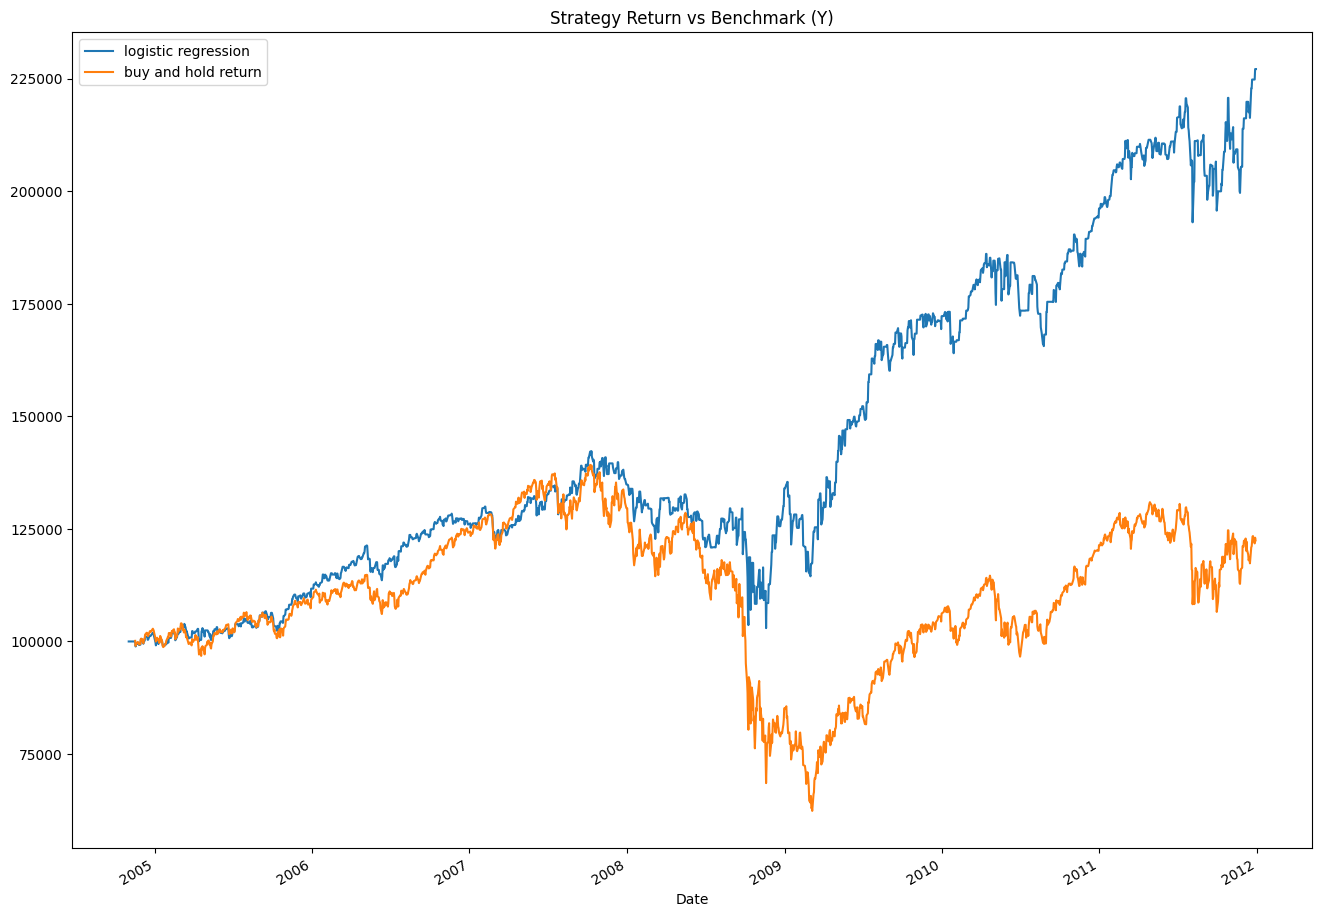

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.922e-01, tolerance: 3.895e-05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


intercept is 0.000 and coefficients are [-0.00016699  0.00042792 -0.0002266  -0.00329503  0.00132283 -0.00335129
 -0.00337045 -0.00334552 -0.00242418  0.00091973]
intercept is 1.974 and coefficients are [-0.00180103 -0.02277265 -0.00213933 -0.03561427 -0.36661232 -0.03584221
 -0.03615603 -0.03556122 -0.45840871 -0.37731509]
Name of features used: ['x30' 'x36' 'x66' 'x94' 'x100' 'x132' 'x133' 'x134' 'x149' 'x150']
 
Accuracy : 0.32305433186490456
 
Precision : 0.40534682080924855
 
Recall : 0.5004460303300624


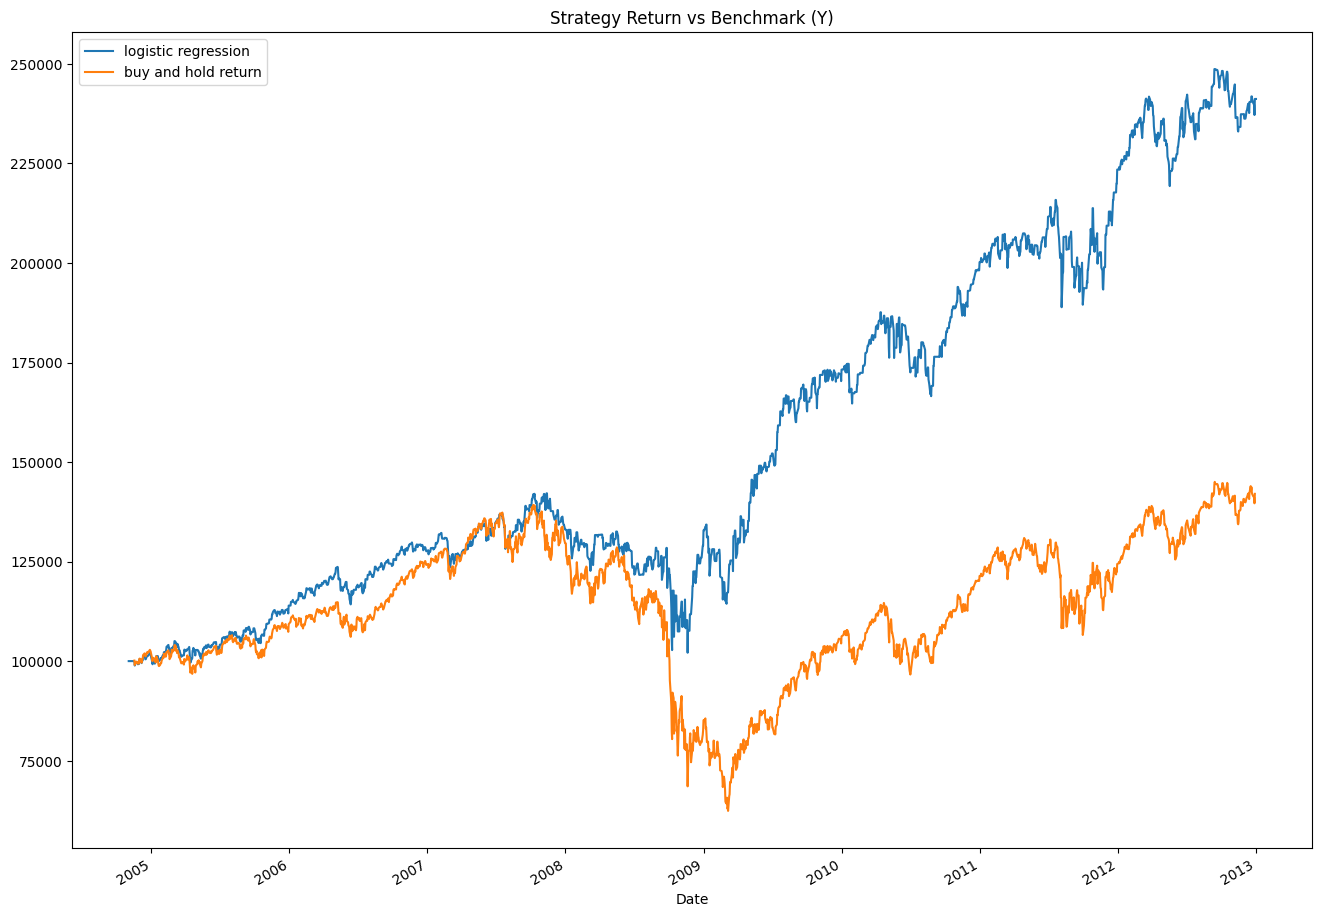

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.983e-01, tolerance: 4.013e-05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


intercept is 0.000 and coefficients are [-0.00015361  0.0004419  -0.00020837 -0.00303224  0.00125005 -0.00308255
 -0.00309981 -0.0030767  -0.00222208  0.0007924 ]
intercept is 2.484 and coefficients are [-0.00166746 -0.01953522 -0.00201172 -0.03295749 -0.34622479 -0.03329862
 -0.03354625 -0.03294811 -0.45007554 -0.3607871 ]
Name of features used: ['x30' 'x36' 'x66' 'x94' 'x100' 'x132' 'x133' 'x134' 'x149' 'x150']
 
Accuracy : 0.34814814814814815
 
Precision : 0.43089921544960774
 
Recall : 0.56353591160221


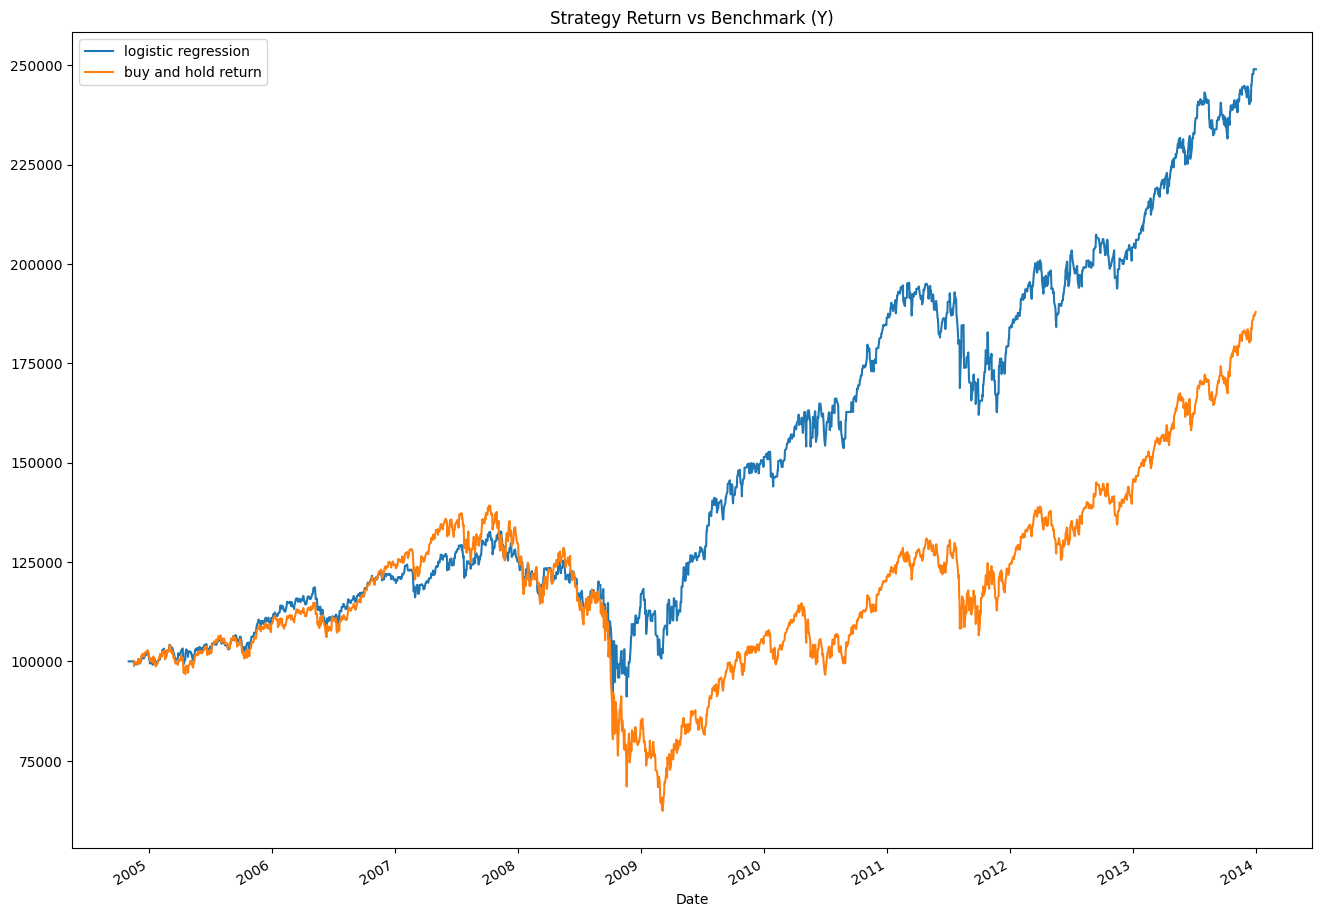

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.047e-01, tolerance: 4.139e-05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


intercept is 0.000 and coefficients are [-0.00014112 -0.00019171 -0.00067067 -0.00278638  0.00128211 -0.00283256
 -0.00284868 -0.00282761 -0.00215677  0.00076509]
intercept is 2.691 and coefficients are [-0.00157021 -0.00188927 -0.04543798 -0.03110096 -0.32710458 -0.03134889
 -0.03164358 -0.03102933 -0.4657427  -0.34666548]
Name of features used: ['x30' 'x66' 'x72' 'x94' 'x100' 'x132' 'x133' 'x134' 'x149' 'x150']
 
Accuracy : 0.364742834707499
 
Precision : 0.44678609062170704
 
Recall : 0.5988700564971752


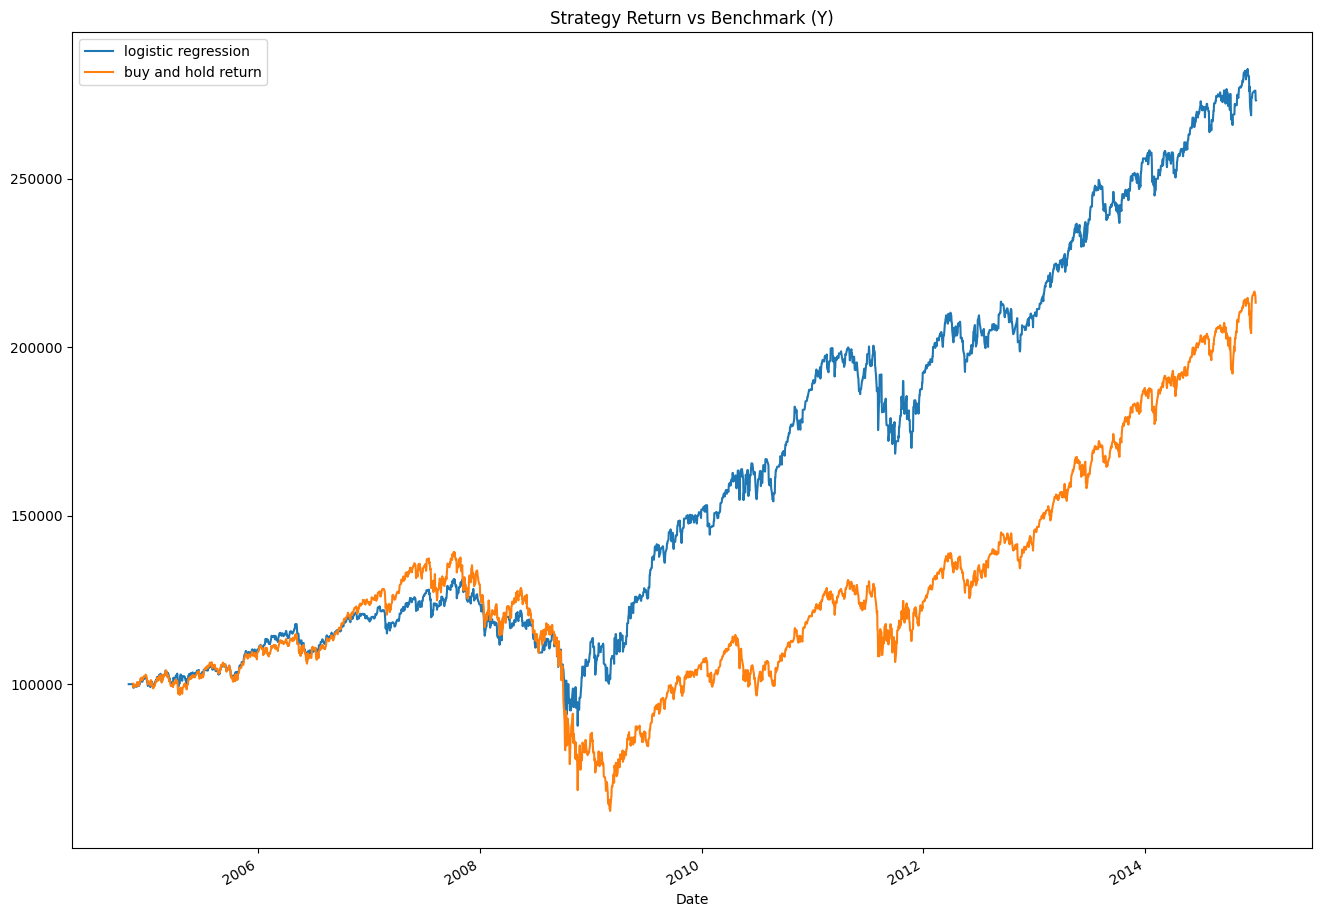

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.170e-01, tolerance: 4.379e-05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


intercept is 0.000 and coefficients are [-0.00012946 -0.00017532 -0.00056954 -0.00037672 -0.00255356 -0.00259516
 -0.0026125  -0.00259188 -0.00110804  0.00101998]
intercept is 3.157 and coefficients are [-0.00257768 -0.0031071  -0.08786352 -0.08009512 -0.05087315 -0.05130549
 -0.05166006 -0.05072311 -0.78747778 -0.65465174]
Name of features used: ['x30' 'x66' 'x72' 'x73' 'x94' 'x132' 'x133' 'x134' 'x149' 'x150']
 
Accuracy : 0.3476241514826724
 
Precision : 0.4292013718765311
 
Recall : 0.5699414443721535


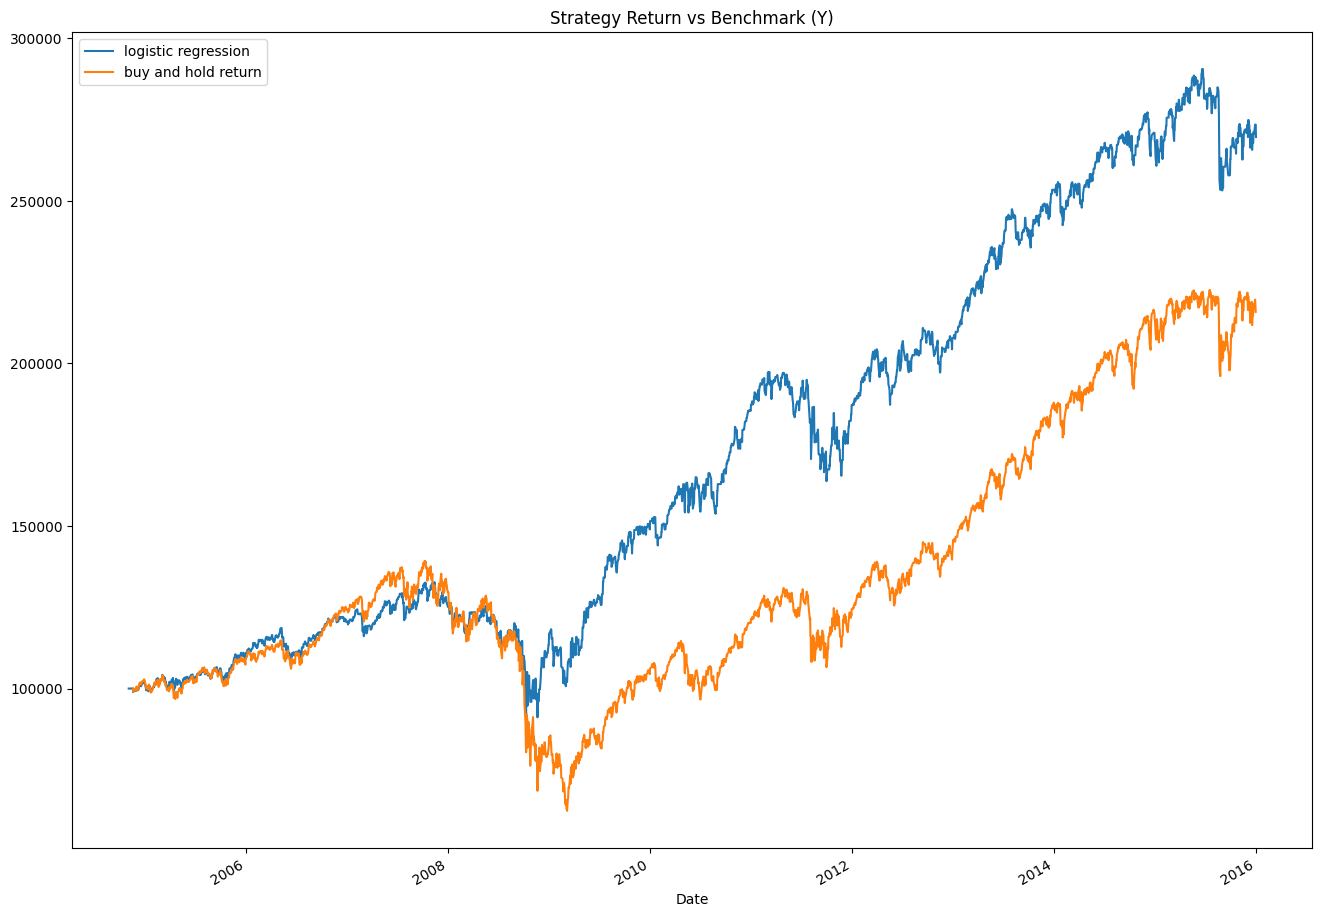

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.255e-01, tolerance: 4.548e-05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


intercept is 0.000 and coefficients are [-0.0001225  -0.00016474 -0.00065574 -0.0004711  -0.00241516 -0.002453
 -0.00246827 -0.00244907 -0.00108825  0.00101098]
intercept is 3.343 and coefficients are [-0.00264526 -0.00322568 -0.13428096 -0.12589132 -0.05216315 -0.05262321
 -0.05299247 -0.05206757 -0.77064438 -0.61576724]
Name of features used: ['x30' 'x66' 'x72' 'x73' 'x94' 'x132' 'x133' 'x134' 'x149' 'x150']
 
Accuracy : 0.36250409701737135
 
Precision : 0.44075207695671187
 
Recall : 0.6021505376344086


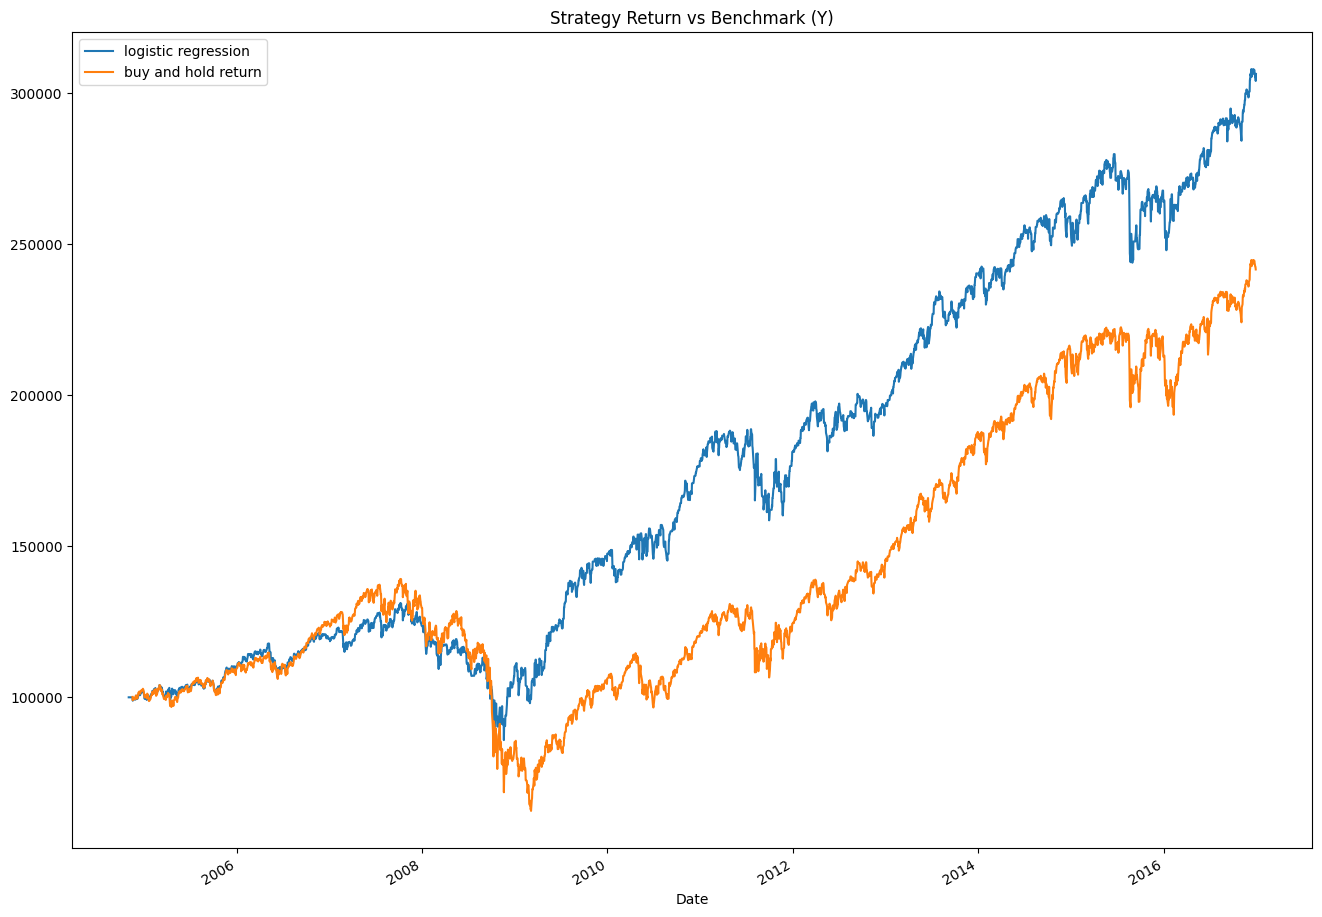

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.278e-01, tolerance: 4.593e-05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


intercept is 0.000 and coefficients are [-0.00011521 -0.00015471 -0.00061058 -0.00043672 -0.00227147 -0.00230647
 -0.00232069 -0.00230263 -0.00107695  0.00099382]
intercept is 3.757 and coefficients are [-0.0022388  -0.00276538 -0.15217027 -0.14431865 -0.04404604 -0.0446124
 -0.04487924 -0.04402124 -0.783004   -0.6332049 ]
Name of features used: ['x30' 'x66' 'x72' 'x73' 'x94' 'x132' 'x133' 'x134' 'x149' 'x150']
 
Accuracy : 0.3855239248940036
 
Precision : 0.45865834633385333
 
Recall : 0.647220693450743


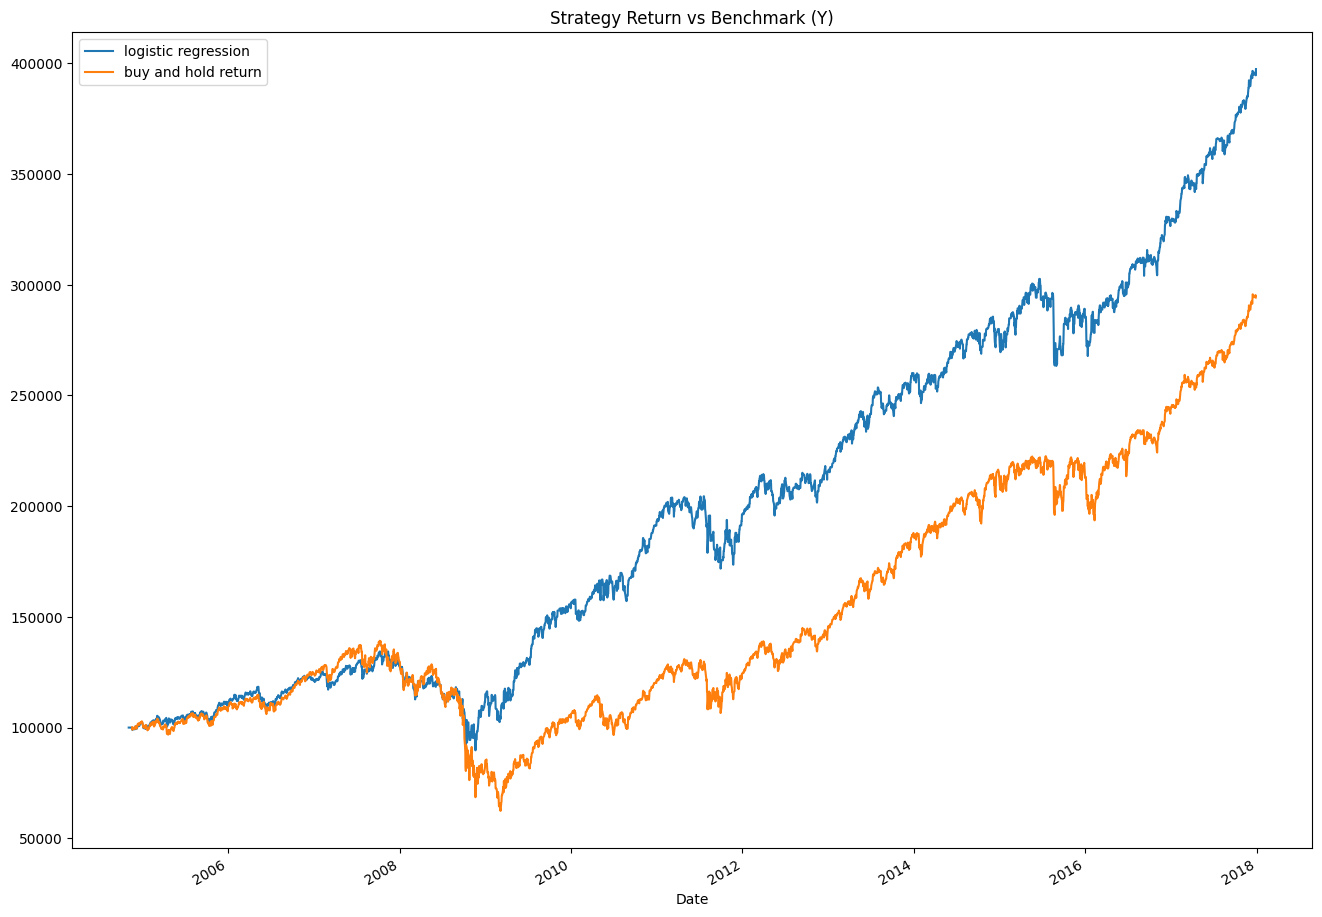

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.425e-01, tolerance: 4.883e-05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


intercept is 0.000 and coefficients are [-1.06647336e-04 -2.30771350e-05 -1.43874441e-04 -5.21084870e-04
 -2.42858060e-04 -2.10430197e-03 -2.13664274e-03 -2.15171522e-03
 -2.13271802e-03 -9.05932543e-05]
intercept is 4.660 and coefficients are [-0.0043657  -0.21561356 -0.00530103 -0.21455352 -0.21582403 -0.08577173
 -0.08673868 -0.08763756 -0.08570118 -1.91221234]
Name of features used: ['x30' 'x56' 'x66' 'x72' 'x73' 'x94' 'x132' 'x133' 'x134' 'x149']
 
Accuracy : 0.37320574162679426
 
Precision : 0.4486846980363097
 
Recall : 0.6210256410256411


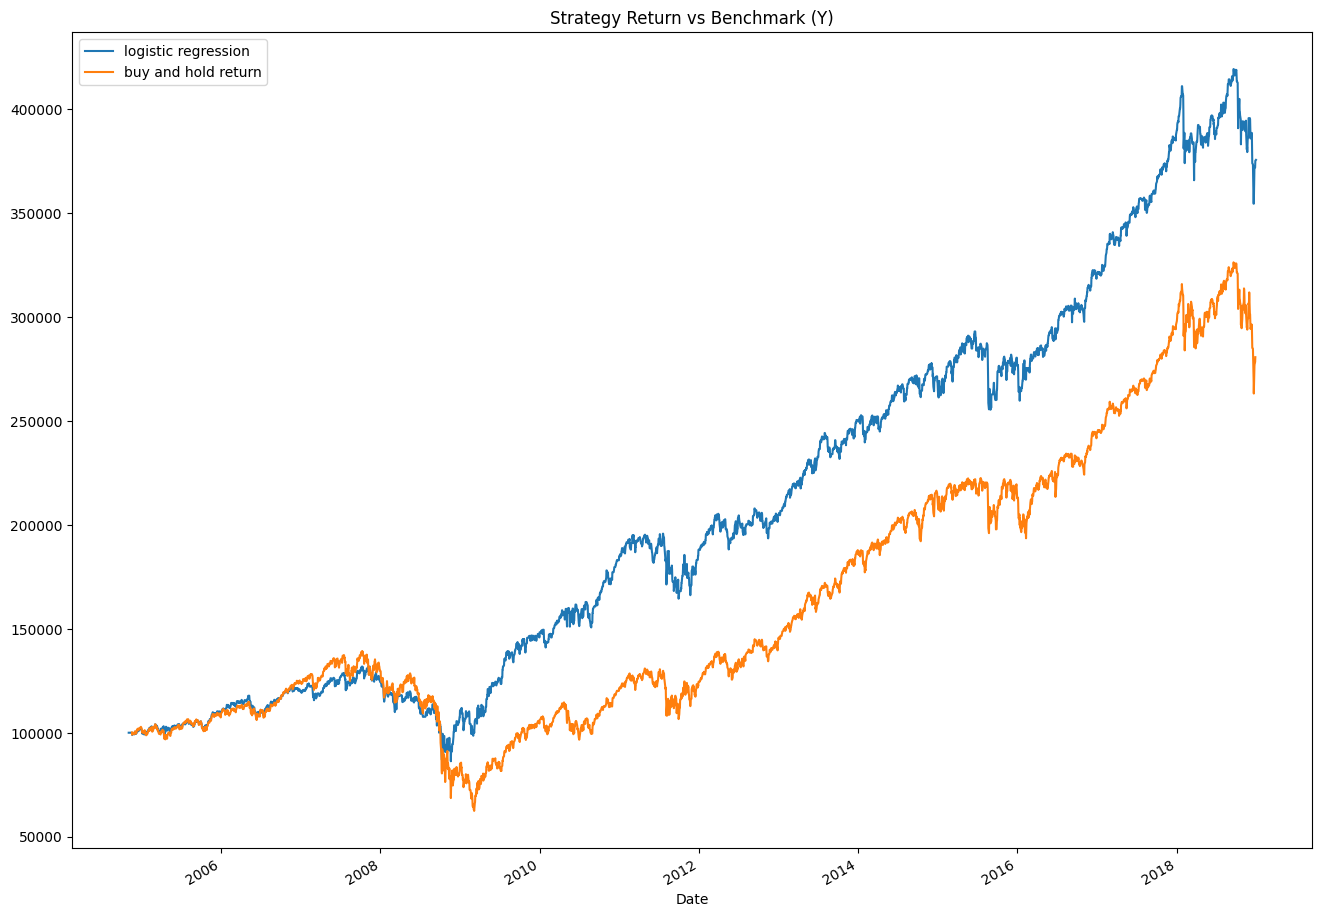

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.504e-01, tolerance: 5.041e-05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


intercept is 0.000 and coefficients are [-1.02086095e-04 -7.06873936e-05 -1.36611132e-04 -5.34233366e-04
 -2.67368841e-04 -2.01267598e-03 -2.04485438e-03 -2.05830634e-03
 -2.03950683e-03 -8.53809443e-05]
intercept is 5.021 and coefficients are [-0.0042288  -0.27226219 -0.0050904  -0.27084735 -0.27092789 -0.08290334
 -0.08397229 -0.08469464 -0.08304058 -1.75985877]
Name of features used: ['x30' 'x56' 'x66' 'x72' 'x73' 'x94' 'x132' 'x133' 'x134' 'x149']
 
Accuracy : 0.3921156373193167
 
Precision : 0.464321608040201
 
Recall : 0.66


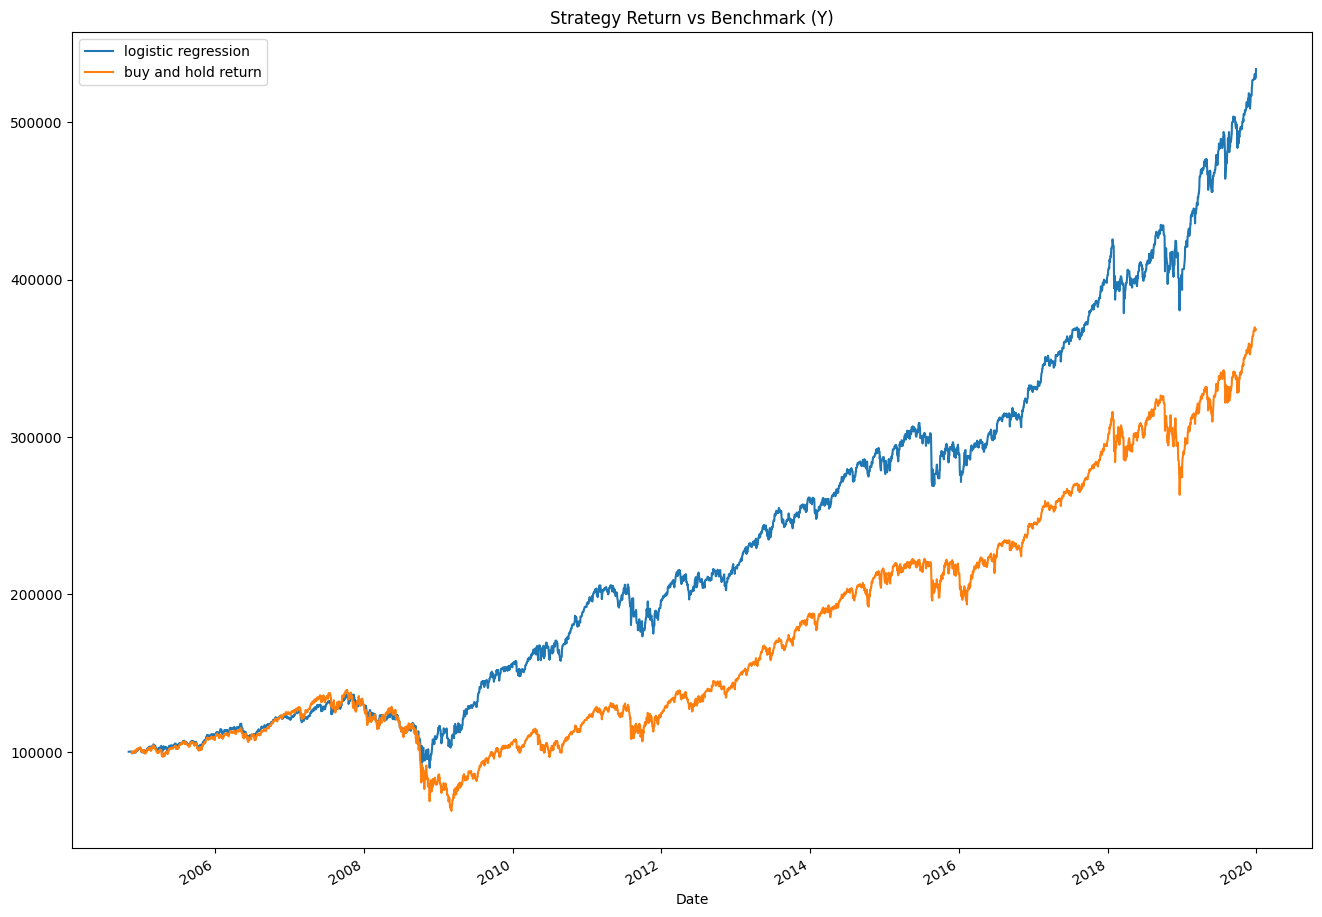

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.017e-01, tolerance: 6.175e-05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


intercept is 0.000 and coefficients are [ 3.75003554e-06  8.74389994e-06 -2.81386413e-03 -2.20322633e-04
  1.12604900e-03  1.64966515e-03 -2.24938230e-03  8.18555112e-04
  1.62996397e-03 -1.57604437e-04]
intercept is 1.730 and coefficients are [-0.00736256 -0.00655646 -0.17182316 -0.15725091 -0.11228519 -0.08645788
 -0.14191052 -0.09720252 -0.07134159 -0.05179412]
Name of features used: ['x19' 'x32' 'x83' 'x96' 'x97' 'x98' 'x139' 'x140' 'x141' 'x142']
 
Accuracy : 0.35411532774765897
 
Precision : 0.43558914462384063
 
Recall : 0.5645592163846839


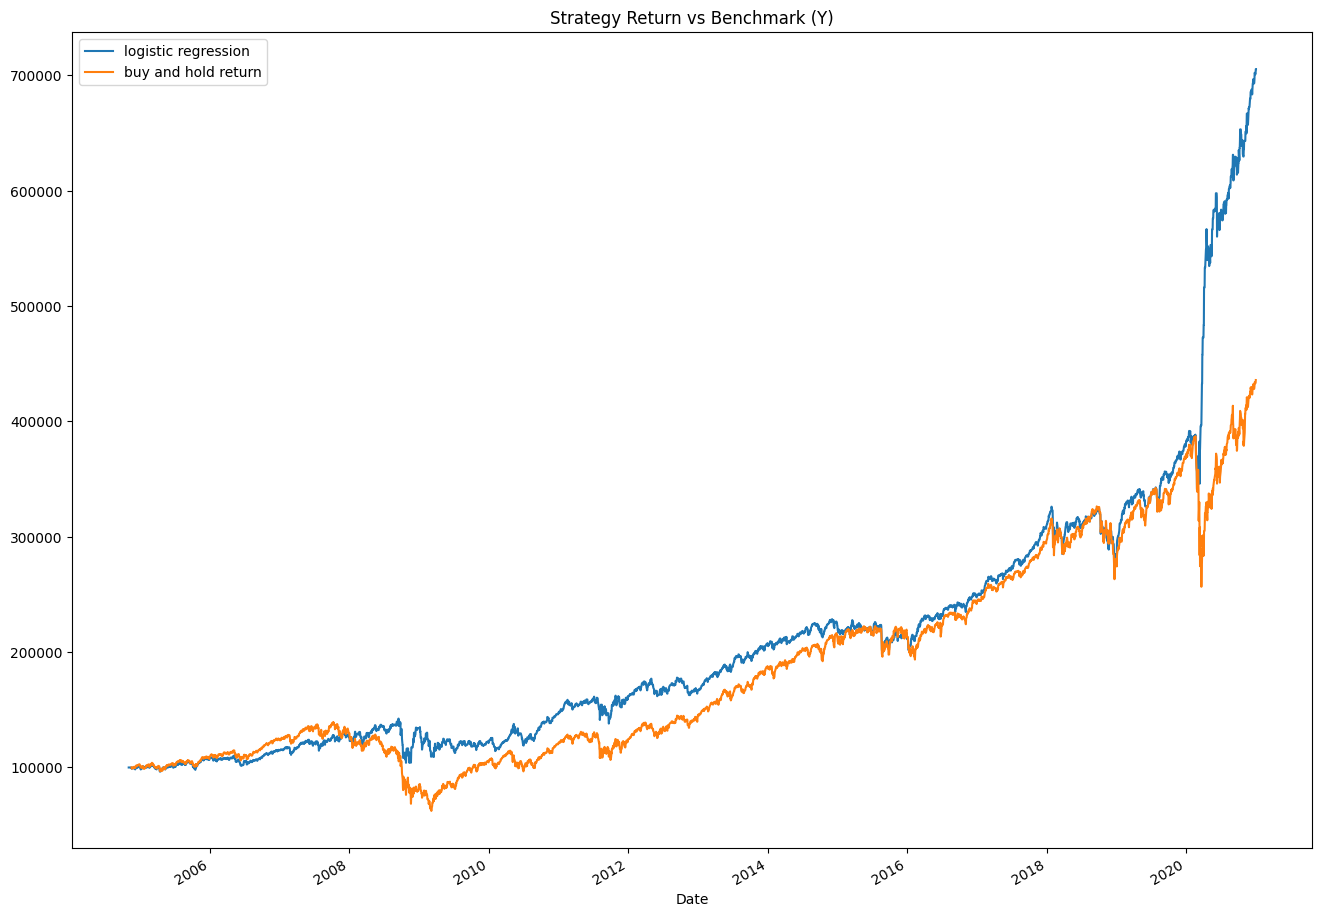

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.102e-01, tolerance: 6.342e-05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


intercept is 0.000 and coefficients are [ 2.21390628e-05  4.19468802e-05 -2.80477175e-03 -1.56773485e-04
  1.05033585e-03  1.64252495e-03 -2.07989961e-03  7.42928738e-04
  1.62194790e-03 -2.32896872e-04]
intercept is 1.860 and coefficients are [-0.00724279 -0.00627287 -0.17368944 -0.15611521 -0.11151704 -0.07863754
 -0.13790457 -0.09347066 -0.0605025  -0.0486149 ]
Name of features used: ['x19' 'x32' 'x83' 'x96' 'x97' 'x98' 'x139' 'x140' 'x141' 'x142']
 
Accuracy : 0.3654292343387471
 
Precision : 0.4460182562165565
 
Recall : 0.592391304347826


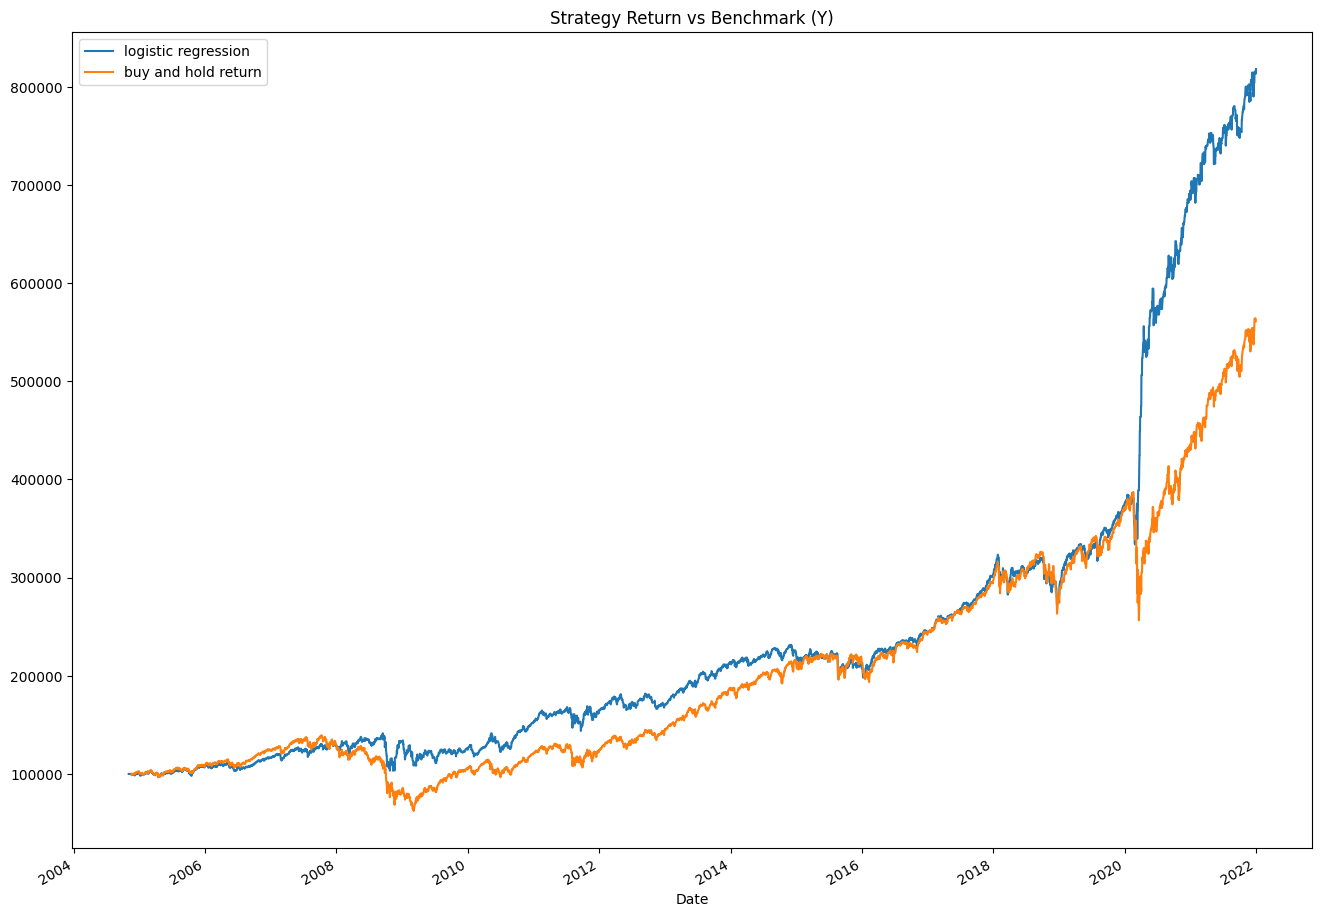

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.400e-01, tolerance: 6.930e-05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


intercept is 0.000 and coefficients are [ 1.31892249e-04  1.67748958e-04 -2.69253075e-03 -5.63045047e-05
  9.27524107e-04  1.65451627e-03 -1.91322056e-03  6.34337829e-04
  1.63877054e-03 -4.05700339e-04]
intercept is 1.818 and coefficients are [-0.00772339 -0.00666196 -0.18001426 -0.16075552 -0.12295923 -0.08267016
 -0.14082497 -0.10315221 -0.06278339 -0.06510703]
Name of features used: ['x19' 'x32' 'x83' 'x96' 'x97' 'x98' 'x139' 'x140' 'x141' 'x142']
 
Accuracy : 0.3488270116202587
 
Precision : 0.4283969465648855
 
Recall : 0.5609756097560976


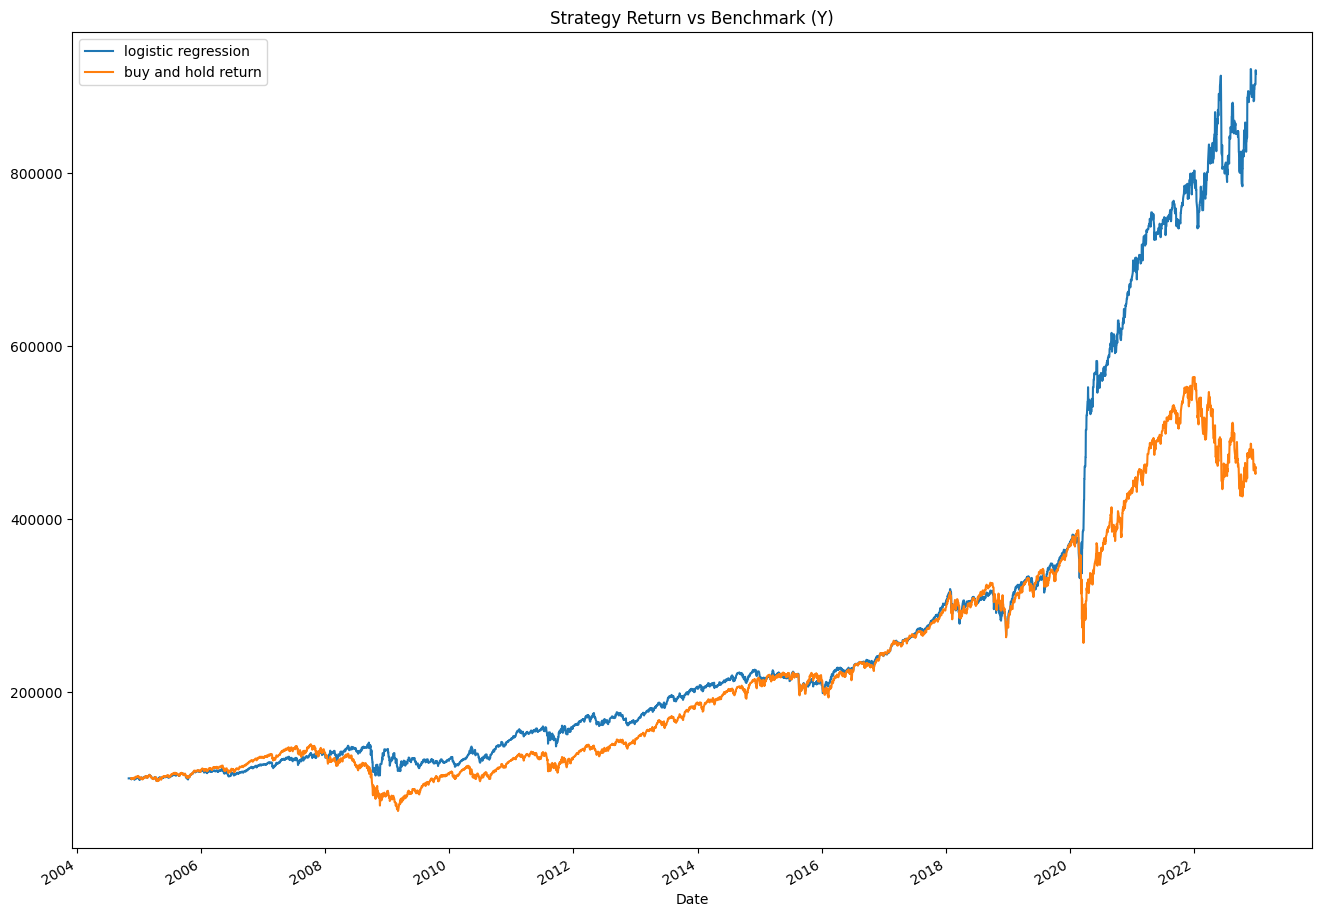

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.475e-01, tolerance: 7.079e-05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


intercept is 0.000 and coefficients are [ 1.55849825e-04  1.95535984e-04 -2.70259028e-03 -4.28496055e-05
  9.12034965e-04  1.65739315e-03 -1.87118469e-03  6.16341962e-04
  1.64123045e-03 -4.21990686e-04]
intercept is 1.873 and coefficients are [-0.00782682 -0.00664786 -0.18434487 -0.1629113  -0.12388901 -0.08202028
 -0.1407873  -0.10191747 -0.05996225 -0.06265772]
Name of features used: ['x19' 'x32' 'x83' 'x96' 'x97' 'x98' 'x139' 'x140' 'x141' 'x142']
 
Accuracy : 0.3493394841685888
 
Precision : 0.4284054603543421
 
Recall : 0.5651340996168582


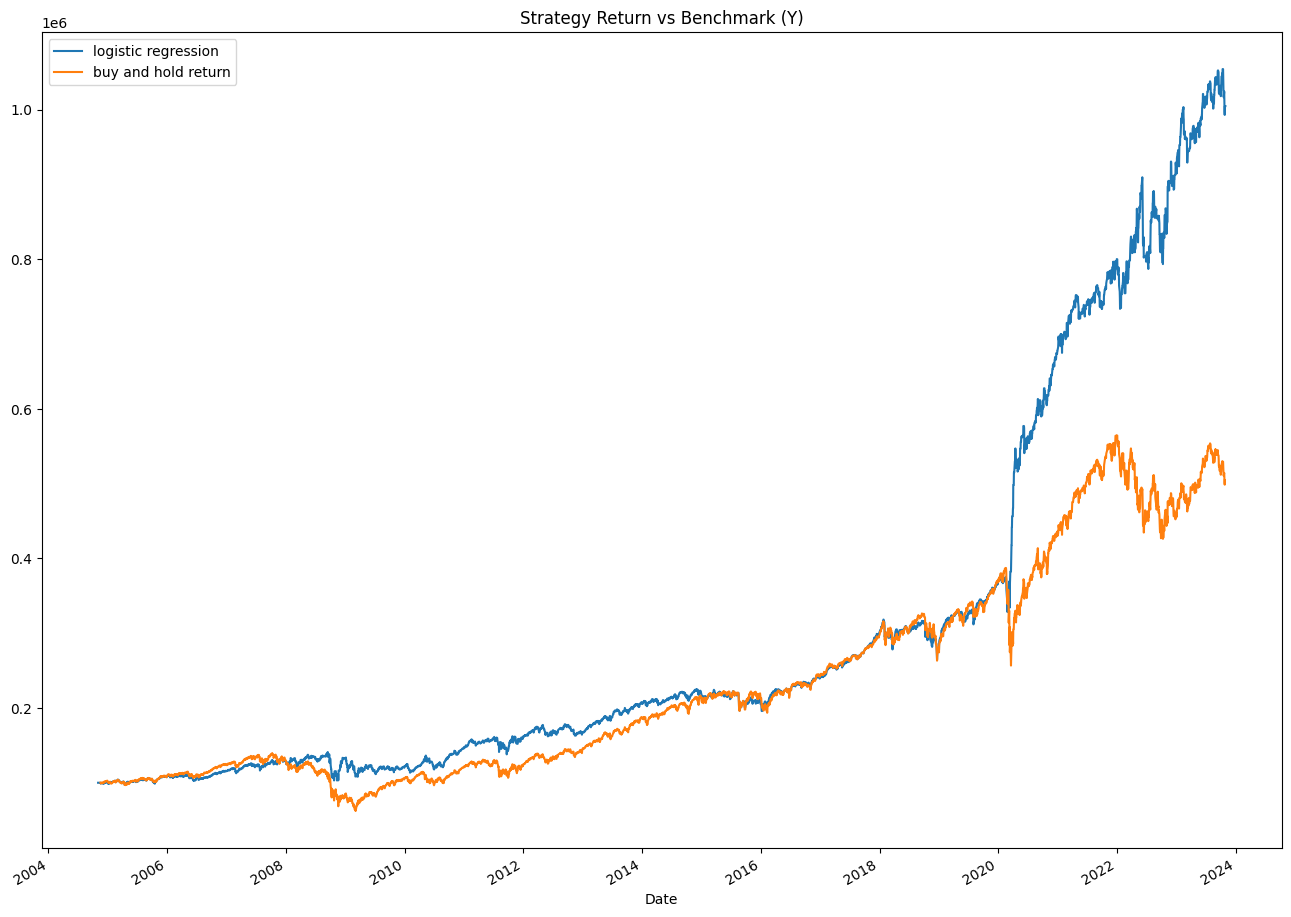

In [45]:
Y_traintest2 = Y_traintest.shift(-1).loc[index_]

params, X_traintest4= fit_and_predict(df_dict,Y_traintest2,penalty_)

In [46]:
(X_traintest4["strategy_return"].cumsum().apply(np.exp))

Date
2004-11-01          NaN
2004-11-02     1.000000
2004-11-03     1.000000
2004-11-04     1.000000
2004-11-05     1.000000
                ...    
2023-10-25     9.974550
2023-10-26     9.929338
2023-10-27    10.048051
2023-10-30    10.048051
2023-10-31          NaN
Name: strategy_return, Length: 4783, dtype: float64

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


[Text(0.5, 0, 'predicted values'),
 Text(0, 0.5, 'target values'),
 Text(0.5, 1.0, 'Predicted vs Actual Responses')]

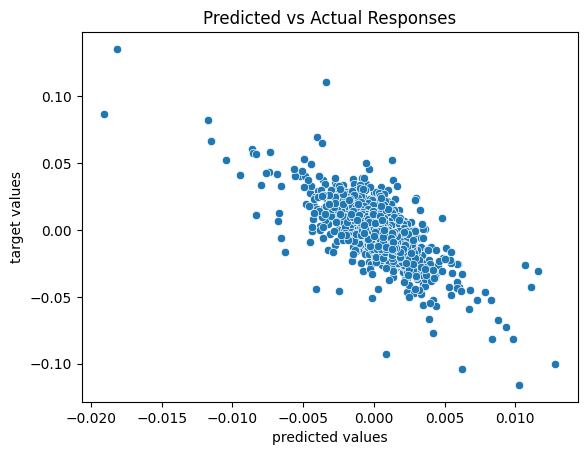

In [47]:
#can turn into a plot function

#linear correlation is expected of a plot between in-sample test and y_pred 
                    #params_dict[]
ax = sns.scatterplot(x=EN_pred_train2, y= Y_traintest.iloc[:-2])
ax.set(xlabel='predicted values', ylabel='target values',title="Predicted vs Actual Responses")

In [48]:
penalty_ = 0.0

def fit_and_predict_w_short(df_dict,Y_traintest_series,penalty_):
    params_dict = {}
    
    for year_ in years_in_data:
        
        X_index = df_dict[year_].index 
        Y_traintest_series_fraction = Y_traintest_series.loc[X_index]

        elastic_net = ElasticNet(alpha=0.02, l1_ratio=penalty_)

        elastic_net.fit(df_dict[year_], Y_traintest_series_fraction)
        print("intercept is {:.3f} and coefficients are {}".format(elastic_net.intercept_, elastic_net.coef_))

        EN_pred_train2 = elastic_net.predict(df_dict[year_])


        #continuous predictions are turned into binary signal or 1 and 0 
        Y_pred_binary2 = (EN_pred_train2 > 0.0).astype(int)


        logreg_sk2 = LogisticRegression(penalty='elasticnet', l1_ratio=penalty_, solver = "saga")
        logreg_sk2.fit(df_dict[year_], Y_pred_binary2)
        print("intercept is {:.3f} and coefficients are {}".format(logreg_sk2.intercept_[0], logreg_sk2.coef_[0]))
        

        Y_pred_logistic2 = logreg_sk2.predict(df_dict[year_])

        Y_pred_logistic2_df = pd.DataFrame(Y_pred_logistic2, index = df_dict[year_].index)

        params_dict[f"EN_pred_{year_}"] = EN_pred_train2
        params_dict[f"binary_pred_{year_}"] = Y_pred_binary2
        params_dict[f"logistic_pred_{year_}"] = Y_pred_logistic2_df

        params_dict[f"Accuracy_{year_}"] = metrics.accuracy_score(Y_traintest_binary.loc[X_index], Y_pred_logistic2)
        params_dict[f"Precision_{year_}"] = metrics.precision_score(Y_traintest_binary.loc[X_index],Y_pred_logistic2)
        params_dict[f"Recall_{year_}"] = metrics.recall_score(Y_traintest_binary.loc[X_index],Y_pred_logistic2)
                                                            
        print("Name of features used: {}".format(elastic_net.feature_names_in_))
        print(" ")
        print("Accuracy :", metrics.accuracy_score(Y_traintest_binary.loc[X_index], Y_pred_logistic2))
        print(" ")
        print("Precision :", metrics.precision_score(Y_traintest_binary.loc[X_index],Y_pred_logistic2))
        print(" ")
        print("Recall :", metrics.recall_score(Y_traintest_binary.loc[X_index],Y_pred_logistic2))
        
        #long and short
        
        X_traintest3 = df_dict[year_].copy()
        X_traintest3["signal"] = Y_pred_logistic2_df
        X_traintest3["signal"].iloc[:13] = 0
        
        signal = X_traintest3["signal"].copy()
        short_signal = (signal == 0) * -1 
        signals = short_signal + signal
        signals.iloc[:12] = 0
        
        X_traintest3_copy = X_traintest3.copy()
        X_traintest3_copy["signal"] = signals
        

        X_traintest3["strategy_return"] = X_traintest3_copy["signal"].shift(1) * Y
        fig,ax = plt.subplots(nrows = 1, ncols = 1, figsize = [16,12])

        (X_traintest3["strategy_return"].cumsum().apply(np.exp) * capital).plot(ax=ax, label = "logistic regression")

        (Y.loc[X_index].cumsum().apply(np.exp) * capital).plot(ax=ax, label = "buy and hold return")

        ax.legend()
        ax.set_title('Strategy Return vs Benchmark (Y)')
        plt.show()
    
    return params_dict, X_traintest3

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.108e-04, tolerance: 6.962e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/var/folders/lh/jjjmlpfs4dlgcn8whsy2chhm0000gn/T/ipykernel_80926/757691479.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation:

intercept is -0.038 and coefficients are [-7.22582544e-05  5.60545176e-05 -1.21584713e-04  4.77659375e-05
  1.17274666e-03  4.37233709e-04  4.24162335e-04 -4.48581840e-04
 -4.84255683e-04 -6.29346763e-04]
intercept is -0.000 and coefficients are [ 0.00075232 -0.00478631  0.00075518  0.00401651  0.01313084  0.01317735
  0.01317616  0.01323333  0.01322711  0.01323086]
Name of features used: ['x18' 'x23' 'x28' 'x59' 'x82' 'x91' 'x92' 'x124' 'x125' 'x127']
 
Accuracy : 0.6333333333333333
 
Precision : 0.6333333333333333
 
Recall : 1.0


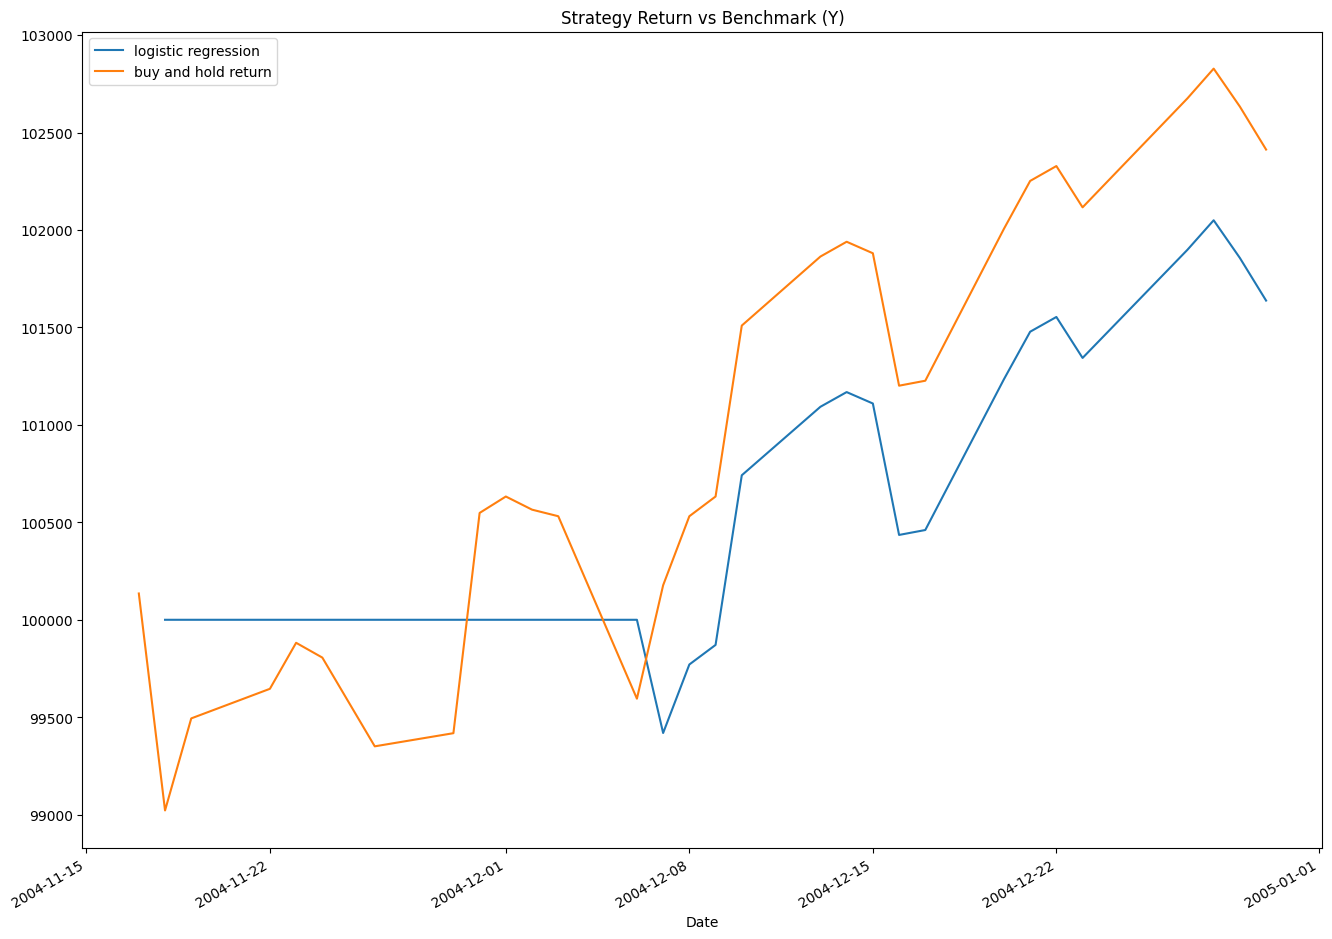

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.732e-03, tolerance: 1.158e-06 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/var/folders/lh/jjjmlpfs4dlgcn8whsy2chhm0000gn/T/ipykernel_80926/757691479.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation:

intercept is 0.000 and coefficients are [ 2.97654941e-06  3.91604149e-05 -6.67759970e-06  5.86635219e-05
 -8.05583778e-05  7.38264911e-04 -8.25871827e-08 -5.59285988e-08
 -4.46683536e-08 -9.56050342e-04]
intercept is 5.118 and coefficients are [-8.05420152e-03 -1.06414812e-01 -1.12758205e-02 -1.40618238e-01
 -1.49156523e-01 -1.86055739e+00  2.07645600e-06 -4.36288826e-07
 -1.54586410e-06 -1.96498839e+00]
Name of features used: ['x13' 'x36' 'x49' 'x56' 'x72' 'x100' 'x109' 'x110' 'x115' 'x149']
 
Accuracy : 0.3475177304964539
 
Precision : 0.42783505154639173
 
Recall : 0.532051282051282


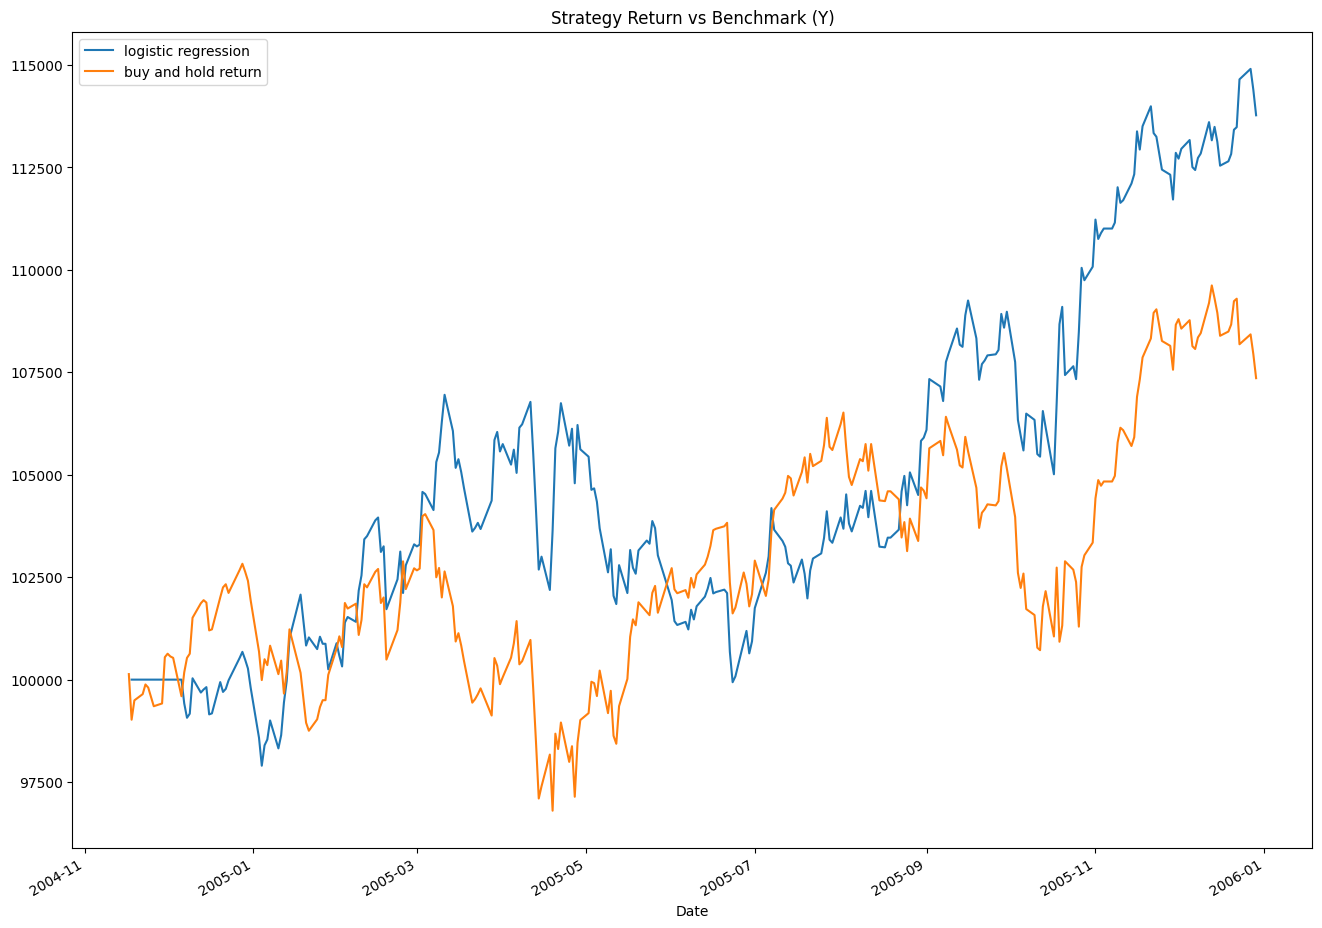

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.053e-02, tolerance: 2.124e-06 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/var/folders/lh/jjjmlpfs4dlgcn8whsy2chhm0000gn/T/ipykernel_80926/757691479.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation:

intercept is -0.009 and coefficients are [-1.84101304e-04 -2.60275484e-04  2.65348192e-04 -1.00157291e-07
 -6.20621363e-08 -7.28328382e-08 -6.96559828e-08  1.56834743e-05
 -3.86068250e-07 -1.34309649e-05]
intercept is -0.000 and coefficients are [-9.64027569e-05 -6.98491687e-04 -1.04266107e-03 -3.41867926e-11
 -5.88505325e-12  1.99291032e-11  2.11733395e-11  5.60298952e-03
 -4.88097745e-03 -3.77014448e-04]
Name of features used: ['x6' 'x39' 'x41' 'x109' 'x110' 'x111' 'x115' 'x155' 'x156' 'x157']
 
Accuracy : 0.551594746716698
 
Precision : 0.5551330798479087
 
Recall : 0.9831649831649831


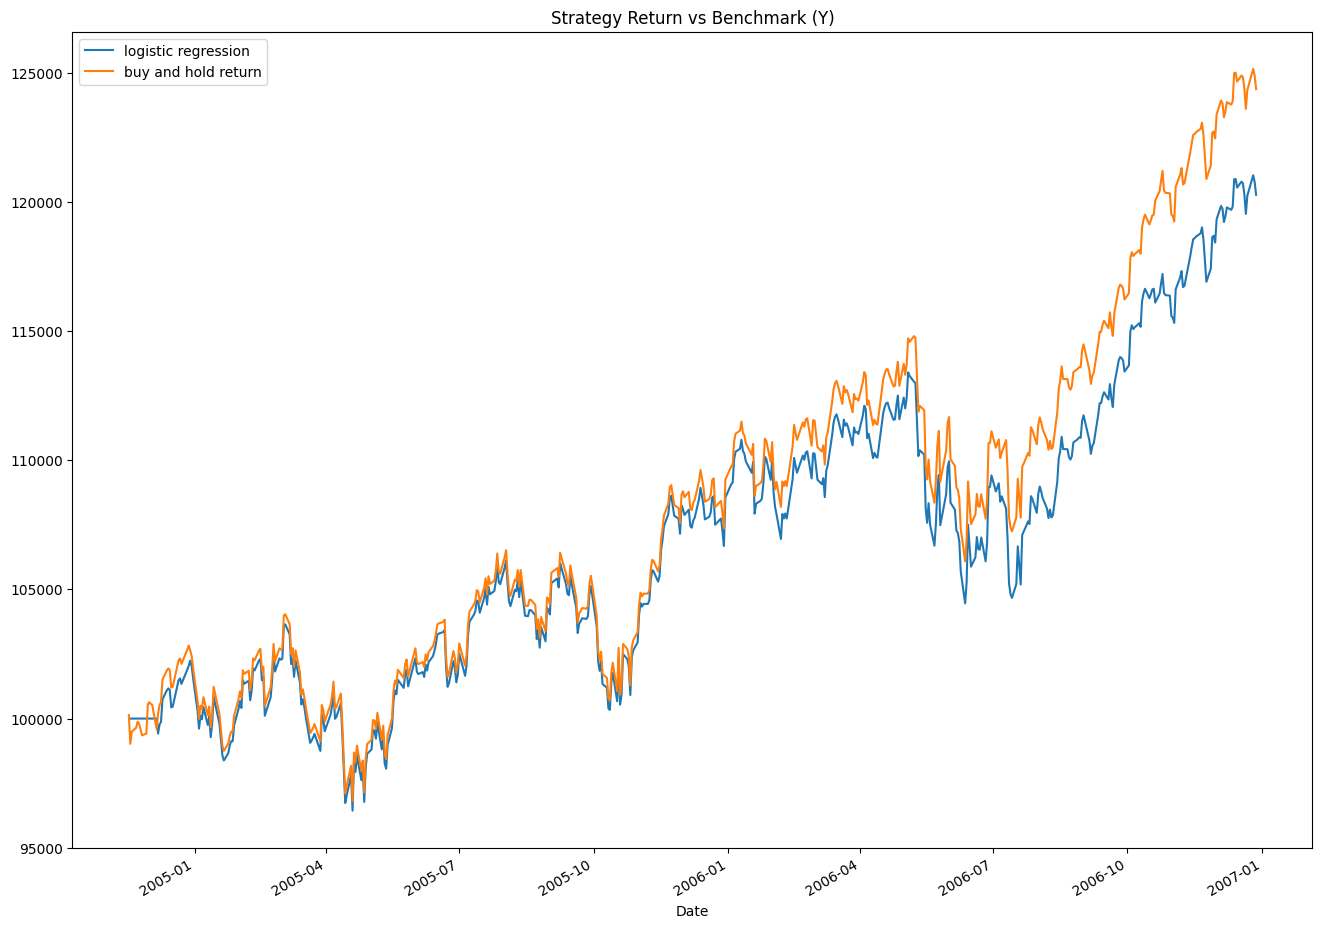

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.299e-02, tolerance: 4.655e-06 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/var/folders/lh/jjjmlpfs4dlgcn8whsy2chhm0000gn/T/ipykernel_80926/757691479.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation:

intercept is 0.000 and coefficients are [ 7.48725462e-05  1.38090933e-05 -6.49264701e-05  3.87161525e-04
 -1.18742098e-07 -9.49203153e-08  4.04600748e-04 -6.84505815e-04
 -1.30526775e-03  9.77810702e-04]
intercept is 3.899 and coefficients are [-3.26770464e-02 -3.26527313e-02 -4.20391433e-02 -5.10734515e-01
 -2.00424327e-07 -3.74038490e-08 -3.93841282e-01 -5.08640493e-01
 -6.22014636e-01 -4.70199573e-01]
Name of features used: ['x56' 'x72' 'x73' 'x101' 'x111' 'x116' 'x149' 'x150' 'x152' 'x153']
 
Accuracy : 0.36096938775510207
 
Precision : 0.44107142857142856
 
Recall : 0.5678160919540229


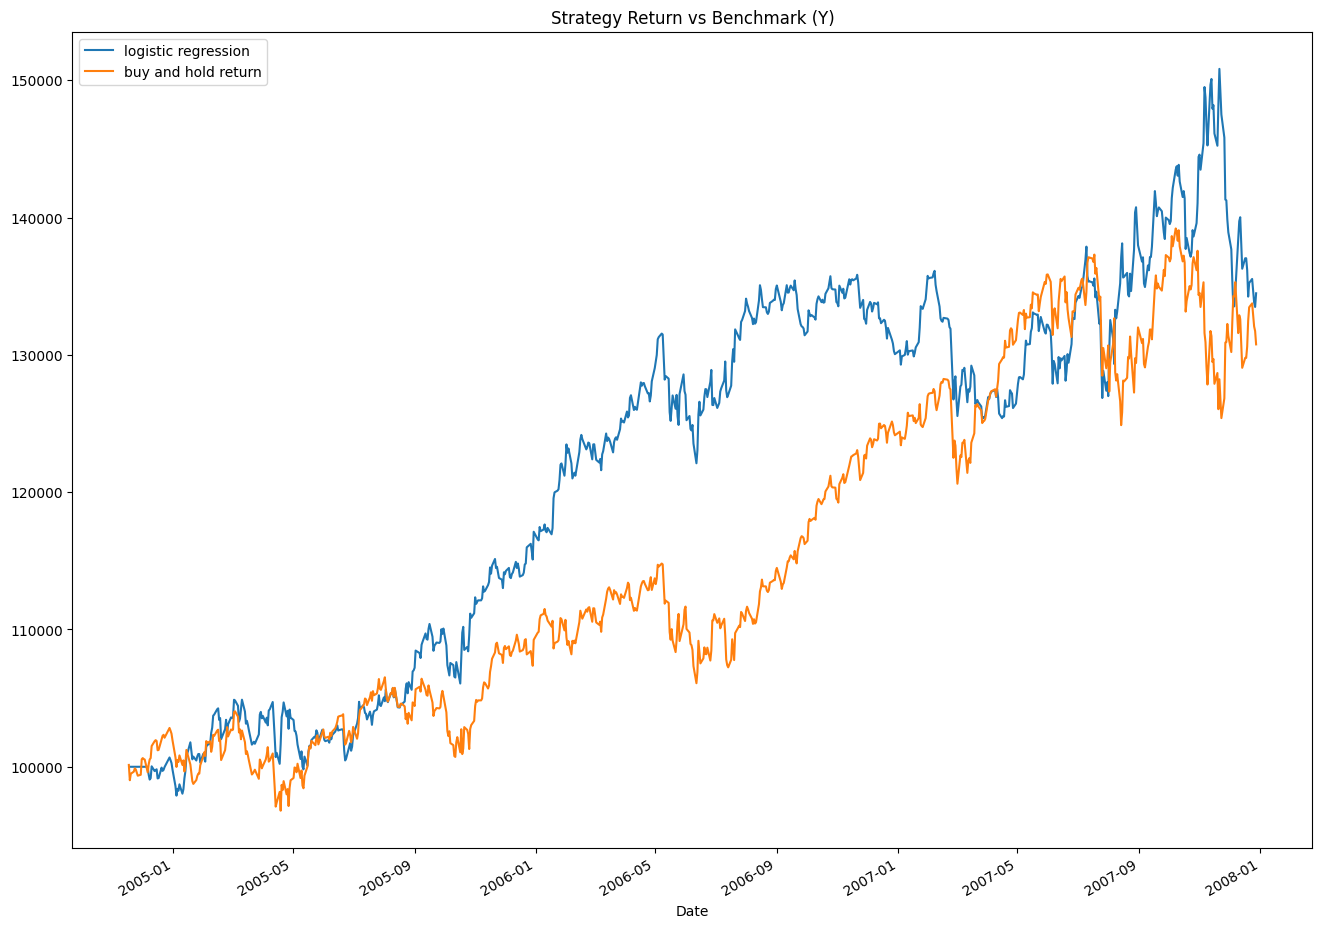

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.081e-01, tolerance: 2.176e-05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics

intercept is -0.000 and coefficients are [-1.83689843e-04 -2.38630317e-04 -7.74100917e-05 -3.64078572e-03
 -1.14229048e-03 -3.67990534e-03 -3.68269033e-03 -3.66510869e-03
 -1.15477734e-03 -1.15285127e-03]
intercept is -5.841 and coefficients are [-0.00052498 -0.00071548 -0.00691219 -0.00974208 -0.10615384 -0.00980653
 -0.01016821 -0.0095344  -0.10558721 -0.10661194]
Name of features used: ['x30' 'x66' 'x67' 'x94' 'x95' 'x132' 'x133' 'x134' 'x136' 'x138']
 
Accuracy : 0.45901639344262296
 
Precision : 0.0
 
Recall : 0.0


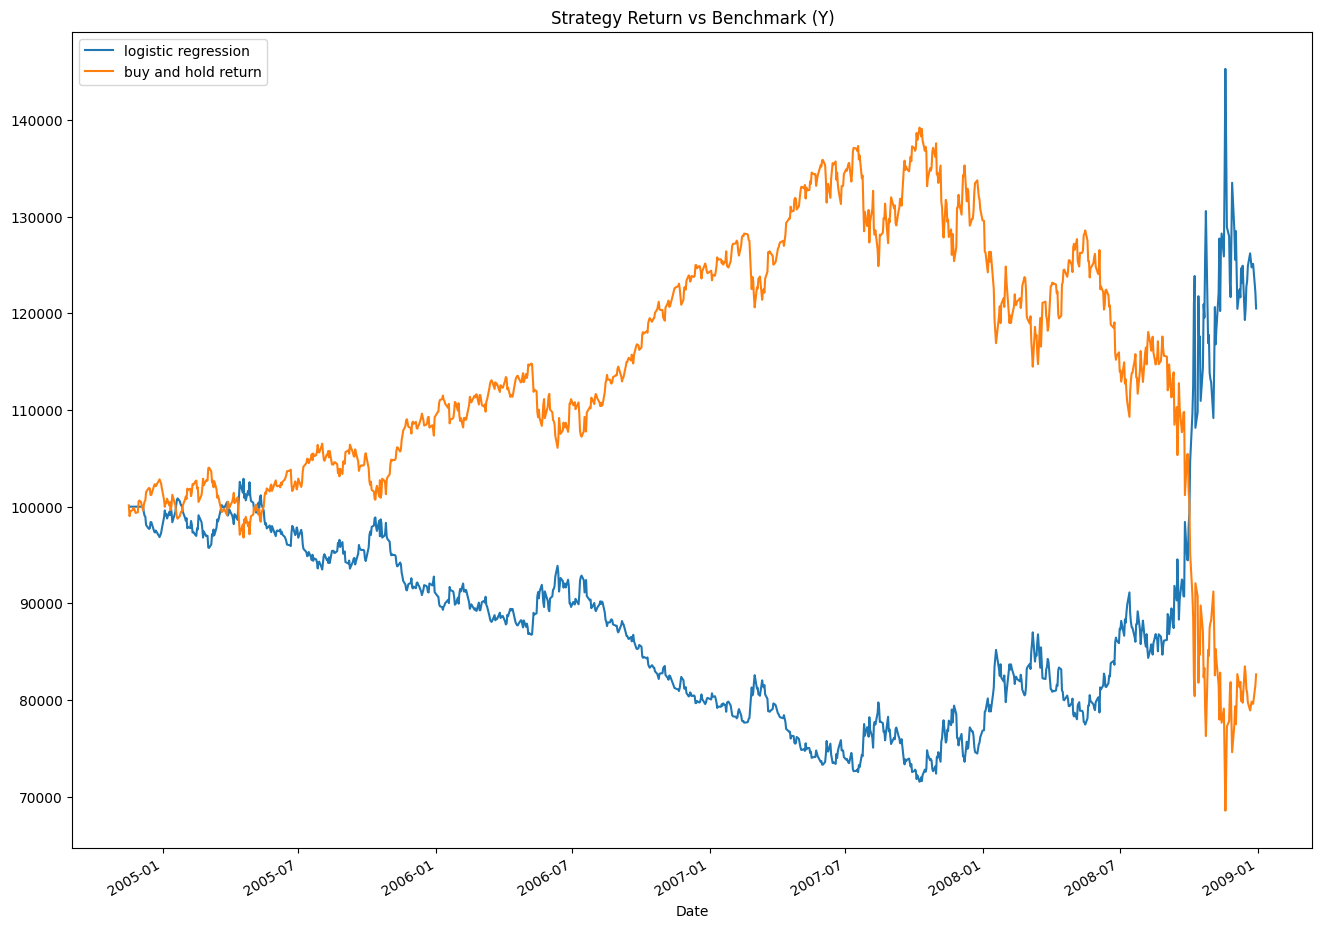

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.420e-01, tolerance: 2.878e-05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/var/folders/lh/jjjmlpfs4dlgcn8whsy2chhm0000gn/T/ipykernel_80926/757691479.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation:

intercept is 0.000 and coefficients are [-0.00014526  0.00018455 -0.00019127 -0.00286901 -0.00290777 -0.00291775
 -0.00289704 -0.00061498  0.00012523  0.00029778]
intercept is 0.801 and coefficients are [-0.00141353 -0.03831627 -0.00179601 -0.02796031 -0.02818281 -0.02846331
 -0.027987   -0.65887947 -0.65047556 -0.64229609]
Name of features used: ['x30' 'x36' 'x66' 'x94' 'x132' 'x133' 'x134' 'x149' 'x150' 'x152']
 
Accuracy : 0.2529092319627618
 
Precision : 0.3174825174825175
 
Recall : 0.32336182336182334


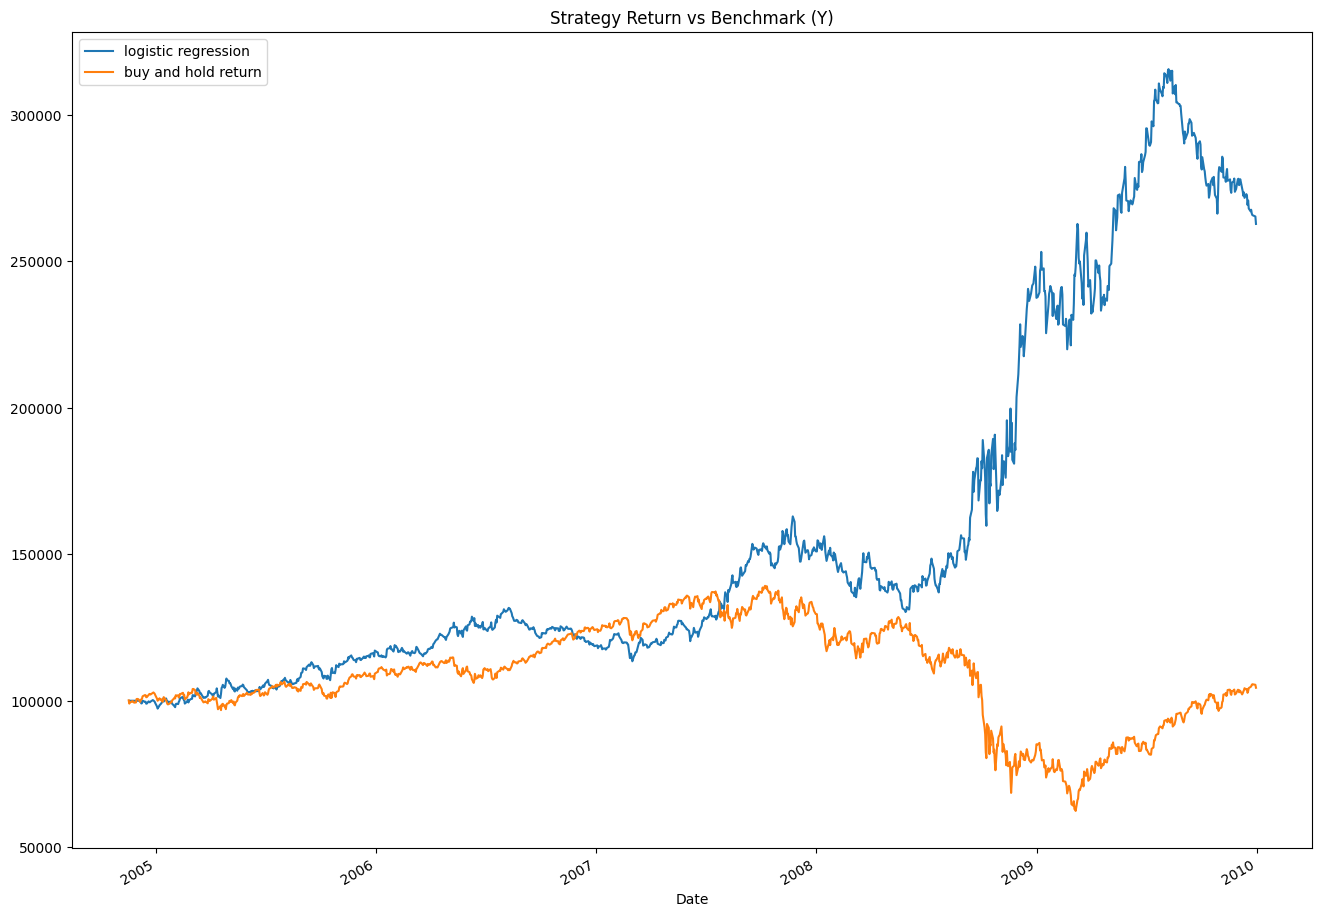

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.581e-01, tolerance: 3.197e-05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/var/folders/lh/jjjmlpfs4dlgcn8whsy2chhm0000gn/T/ipykernel_80926/757691479.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation:

intercept is 0.000 and coefficients are [-0.00012294  0.00021258 -0.00016228 -0.00242934 -0.00246281 -0.0024717
 -0.00245484 -0.00086881  0.00022186  0.00047146]
intercept is 1.451 and coefficients are [-0.00144699 -0.03171471 -0.00183576 -0.02865593 -0.02889633 -0.02916418
 -0.02864866 -0.55707277 -0.54131027 -0.52564281]
Name of features used: ['x30' 'x36' 'x66' 'x94' 'x132' 'x133' 'x134' 'x149' 'x150' 'x152']
 
Accuracy : 0.28617780661907855
 
Precision : 0.3642241379310345
 
Recall : 0.39858490566037735


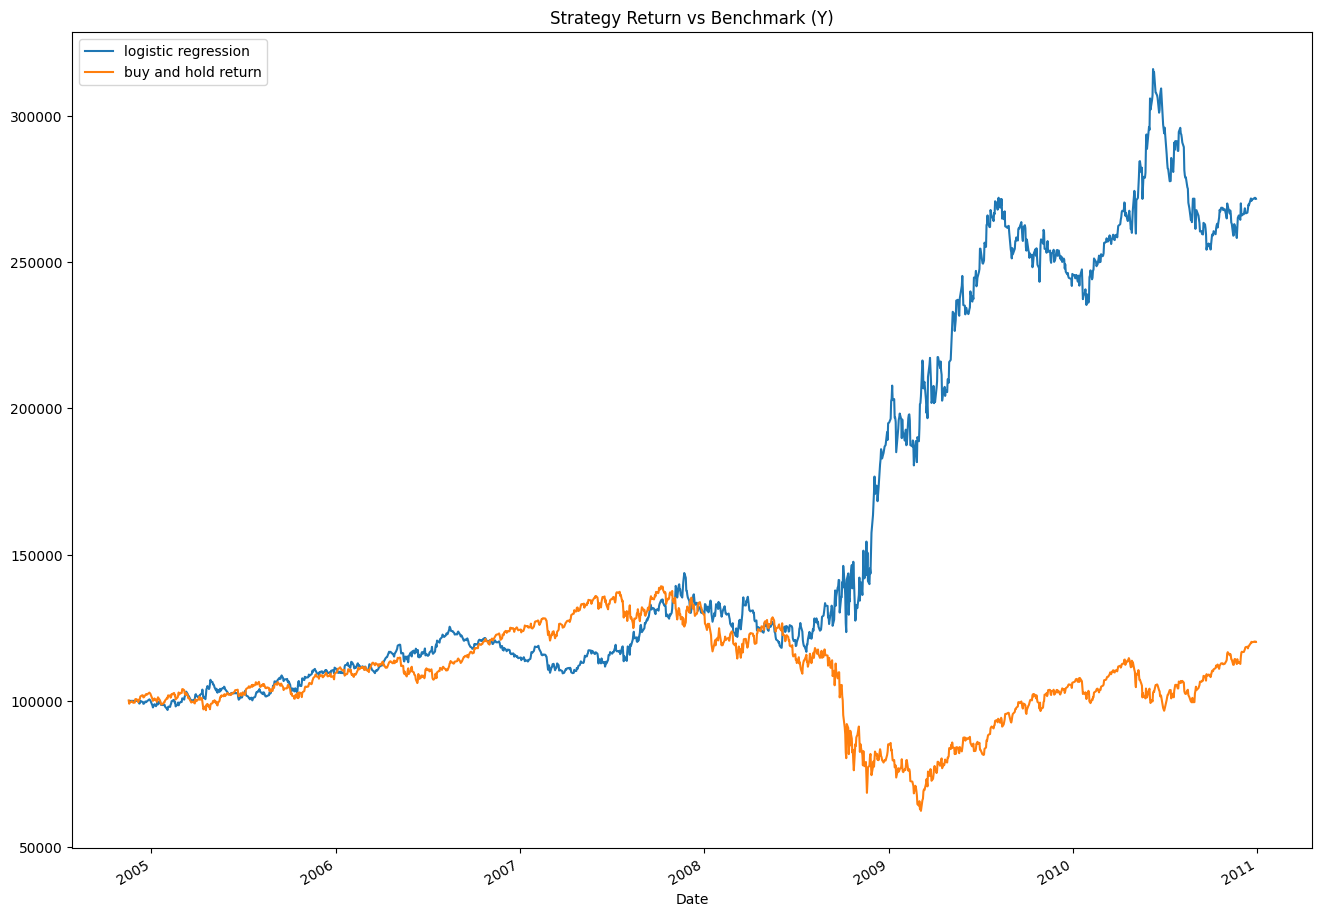

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.843e-01, tolerance: 3.730e-05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/var/folders/lh/jjjmlpfs4dlgcn8whsy2chhm0000gn/T/ipykernel_80926/757691479.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation:

intercept is 0.000 and coefficients are [-0.00010411  0.00018965 -0.00014045 -0.00205574  0.00125679 -0.00208781
 -0.00210028 -0.00208344 -0.00207912  0.00064168]
intercept is 1.432 and coefficients are [-0.00139299 -0.032065   -0.00172551 -0.02755965 -0.55447726 -0.02778693
 -0.02805993 -0.02752577 -0.58667206 -0.55852886]
Name of features used: ['x30' 'x36' 'x66' 'x94' 'x100' 'x132' 'x133' 'x134' 'x149' 'x150']
 
Accuracy : 0.28053541550474065
 
Precision : 0.3559322033898305
 
Recall : 0.38414634146341464


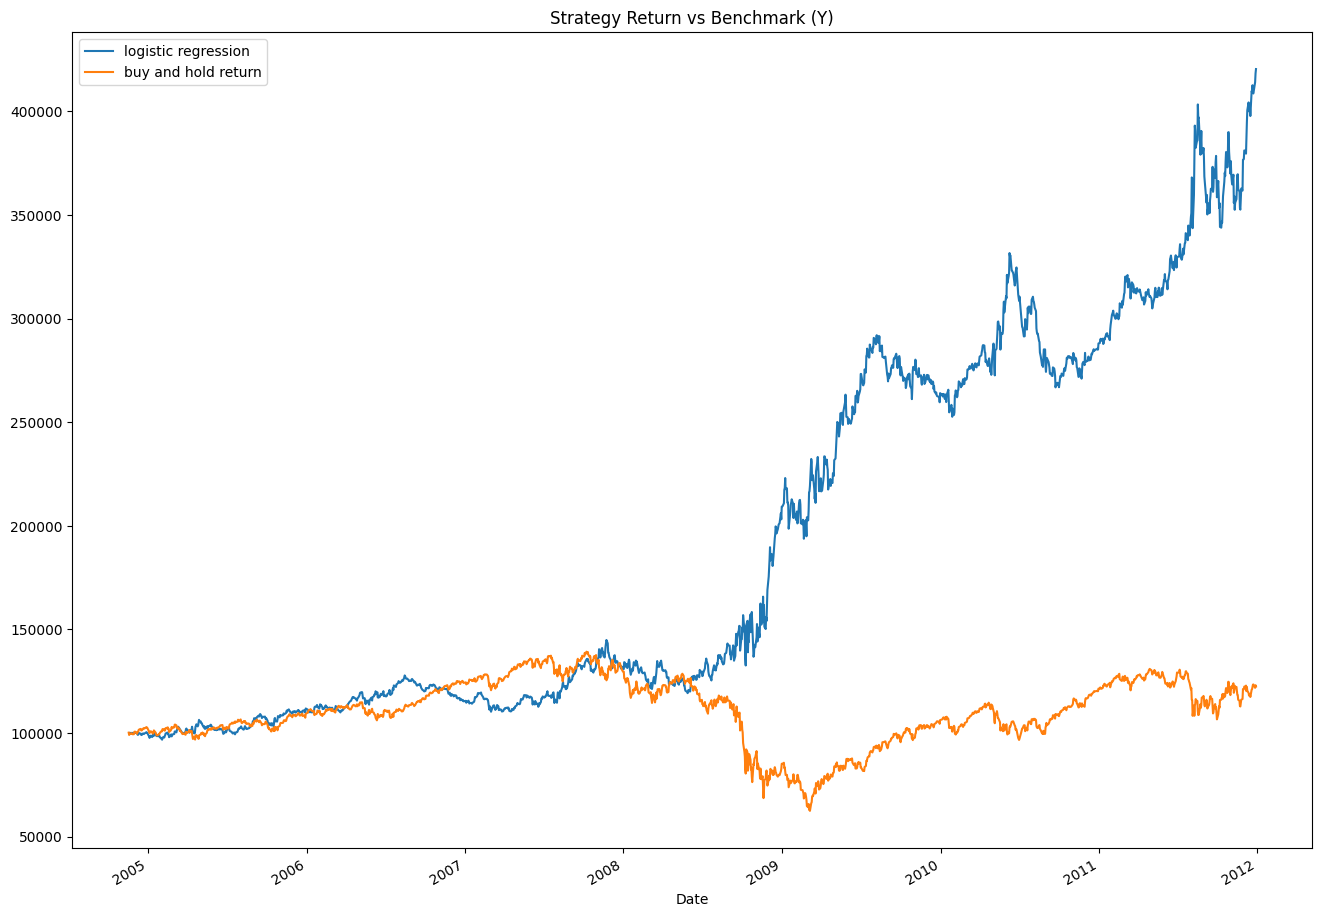

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.926e-01, tolerance: 3.895e-05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/var/folders/lh/jjjmlpfs4dlgcn8whsy2chhm0000gn/T/ipykernel_80926/757691479.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation:

intercept is 0.000 and coefficients are [-9.39619690e-05  2.25941953e-04 -1.26505796e-04 -1.85527075e-03
  1.22466936e-03 -1.88383617e-03 -1.89448475e-03 -1.87915338e-03
 -2.11261194e-03  7.15313624e-04]
intercept is 2.026 and coefficients are [-0.00127586 -0.02718685 -0.00156555 -0.02530872 -0.47209171 -0.0255019
 -0.02591683 -0.02524481 -0.53321818 -0.4826047 ]
Name of features used: ['x30' 'x36' 'x66' 'x94' 'x100' 'x132' 'x133' 'x134' 'x149' 'x150']
 
Accuracy : 0.30983847283406757
 
Precision : 0.3906131718395155
 
Recall : 0.46030330062444247


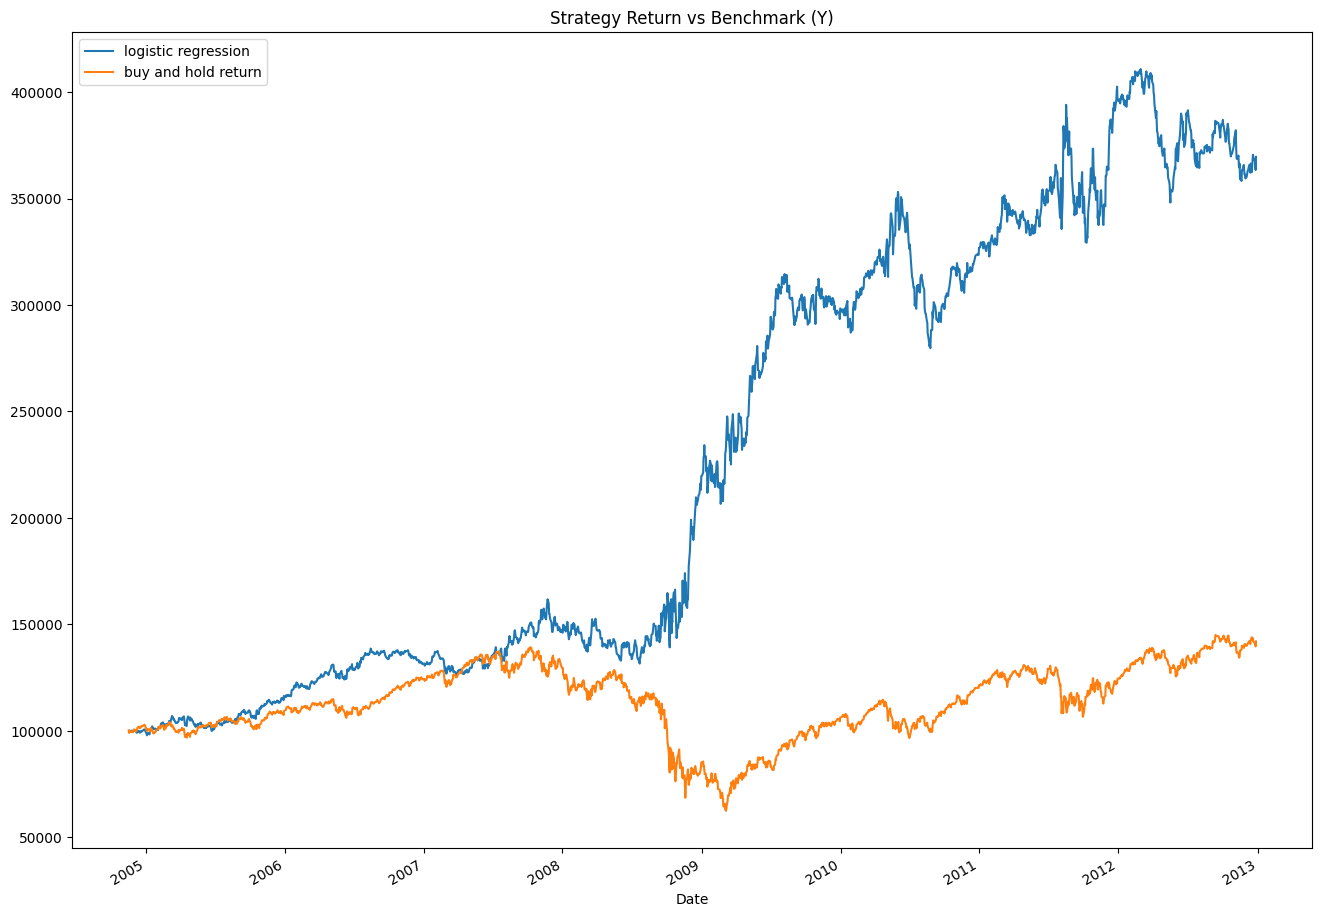

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.986e-01, tolerance: 4.013e-05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/var/folders/lh/jjjmlpfs4dlgcn8whsy2chhm0000gn/T/ipykernel_80926/757691479.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation:

intercept is 0.000 and coefficients are [-8.55508899e-05  2.30046117e-04 -1.15208507e-04 -1.68965442e-03
  1.14924714e-03 -1.71516233e-03 -1.72467517e-03 -1.71073728e-03
 -1.91236179e-03  5.93096858e-04]
intercept is 2.605 and coefficients are [-0.00082074 -0.02300452 -0.00100952 -0.01623757 -0.42854151 -0.01661615
 -0.01687036 -0.01631035 -0.50924595 -0.43824092]
Name of features used: ['x30' 'x36' 'x66' 'x94' 'x100' 'x132' 'x133' 'x134' 'x149' 'x150']
 
Accuracy : 0.33681917211328977
 
Precision : 0.4209547427154371
 
Recall : 0.5359116022099447


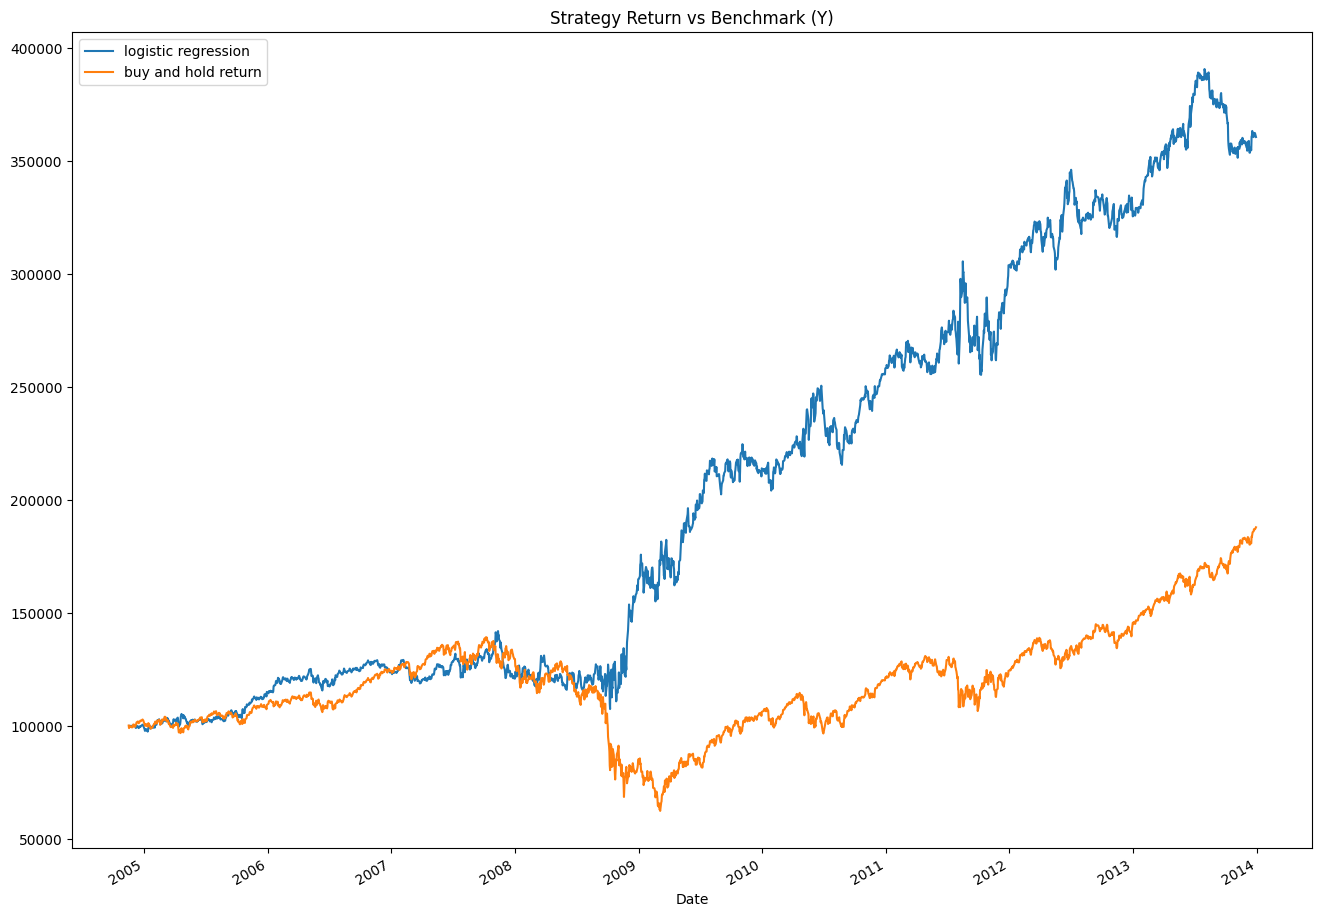

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.051e-01, tolerance: 4.139e-05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/var/folders/lh/jjjmlpfs4dlgcn8whsy2chhm0000gn/T/ipykernel_80926/757691479.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation:

intercept is 0.000 and coefficients are [-7.78609493e-05 -1.05068787e-04 -4.11674170e-04 -1.53809067e-03
  1.15297951e-03 -1.56143617e-03 -1.57019321e-03 -1.55767651e-03
 -1.83320821e-03  5.54498365e-04]
intercept is 2.860 and coefficients are [-0.00071458 -0.00094947 -0.03429428 -0.01417203 -0.41466157 -0.01451616
 -0.01476478 -0.0142587  -0.51449658 -0.43416123]
Name of features used: ['x30' 'x66' 'x72' 'x94' 'x100' 'x132' 'x133' 'x134' 'x149' 'x150']
 
Accuracy : 0.35217903415783275
 
Precision : 0.4366883116883117
 
Recall : 0.5699152542372882


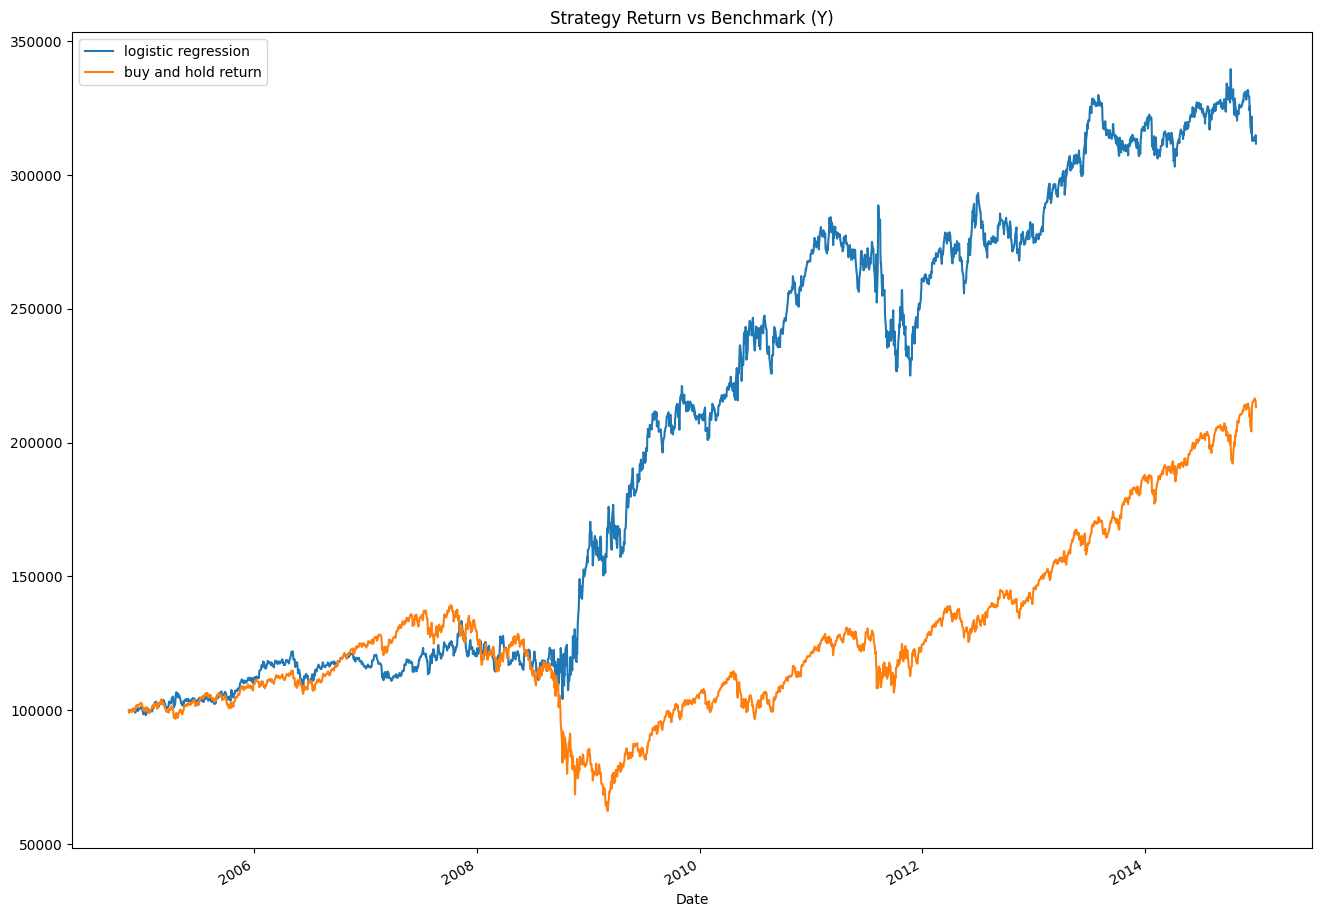

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.173e-01, tolerance: 4.379e-05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/var/folders/lh/jjjmlpfs4dlgcn8whsy2chhm0000gn/T/ipykernel_80926/757691479.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation:

intercept is 0.000 and coefficients are [-7.09278080e-05 -9.54843671e-05 -3.77595964e-04 -2.67986809e-04
 -1.39984937e-03 -1.42088584e-03 -1.43014649e-03 -1.41813190e-03
 -9.47929384e-04  8.41448155e-04]
intercept is 3.415 and coefficients are [-0.00117749 -0.00156273 -0.08039788 -0.07508399 -0.02328459 -0.02375311
 -0.02412901 -0.02340013 -0.91492345 -0.81728895]
Name of features used: ['x30' 'x66' 'x72' 'x73' 'x94' 'x132' 'x133' 'x134' 'x149' 'x150']
 
Accuracy : 0.3415505537692033
 
Precision : 0.42334669338677355
 
Recall : 0.549772283669486


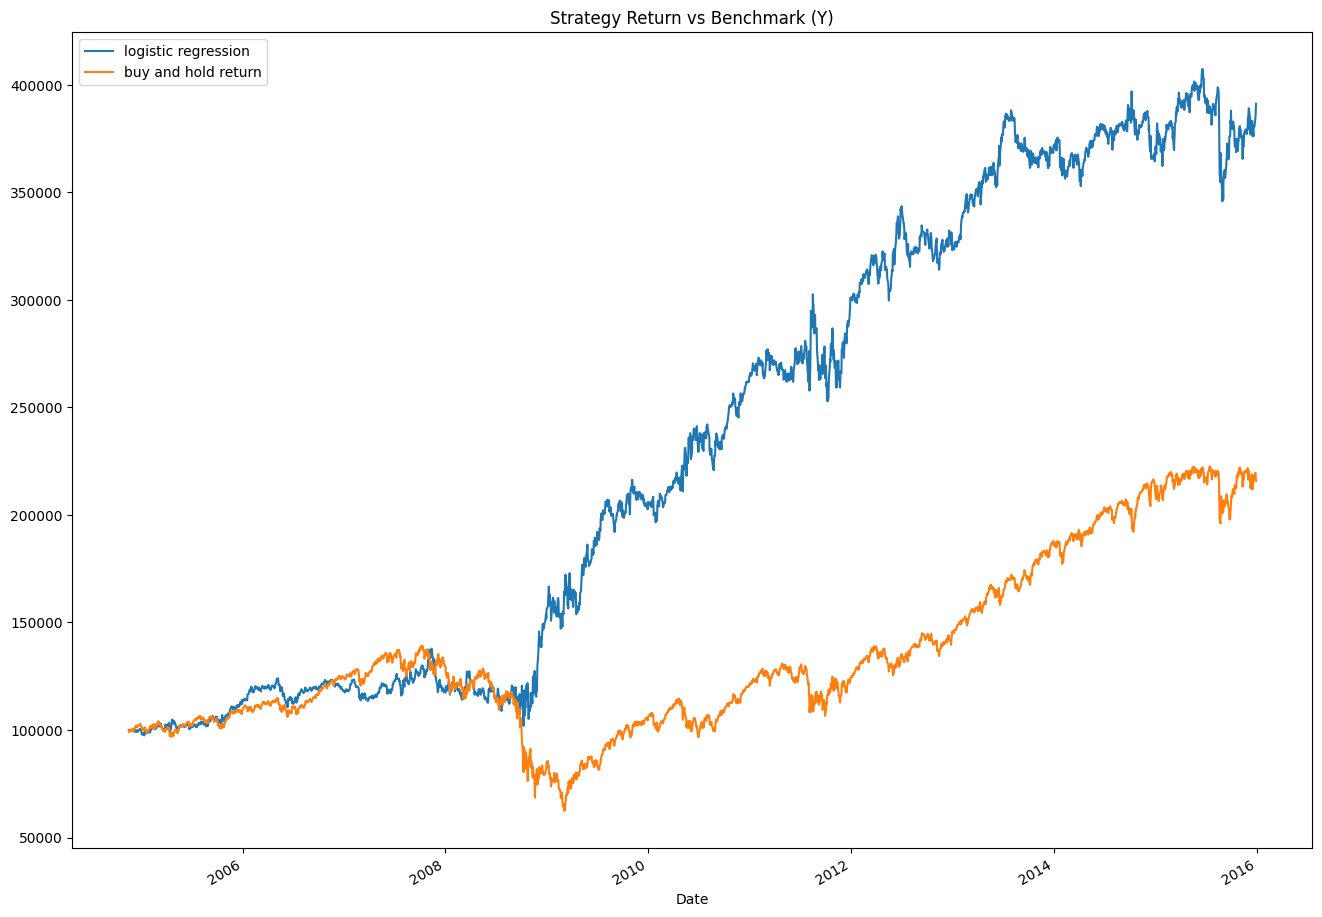

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.257e-01, tolerance: 4.548e-05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/var/folders/lh/jjjmlpfs4dlgcn8whsy2chhm0000gn/T/ipykernel_80926/757691479.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation:

intercept is 0.000 and coefficients are [-6.67088234e-05 -8.92442605e-05 -4.46009561e-04 -3.41338804e-04
 -1.31593239e-03 -1.33505055e-03 -1.34318649e-03 -1.33209091e-03
 -9.22964171e-04  8.25428841e-04]
intercept is 3.643 and coefficients are [-0.00119581 -0.00158738 -0.10468155 -0.0991265  -0.02362063 -0.02406363
 -0.02439848 -0.02371088 -0.88288595 -0.78007581]
Name of features used: ['x30' 'x66' 'x72' 'x73' 'x94' 'x132' 'x133' 'x134' 'x149' 'x150']
 
Accuracy : 0.3503769255981645
 
Precision : 0.43118856121537086
 
Recall : 0.5764635603345281


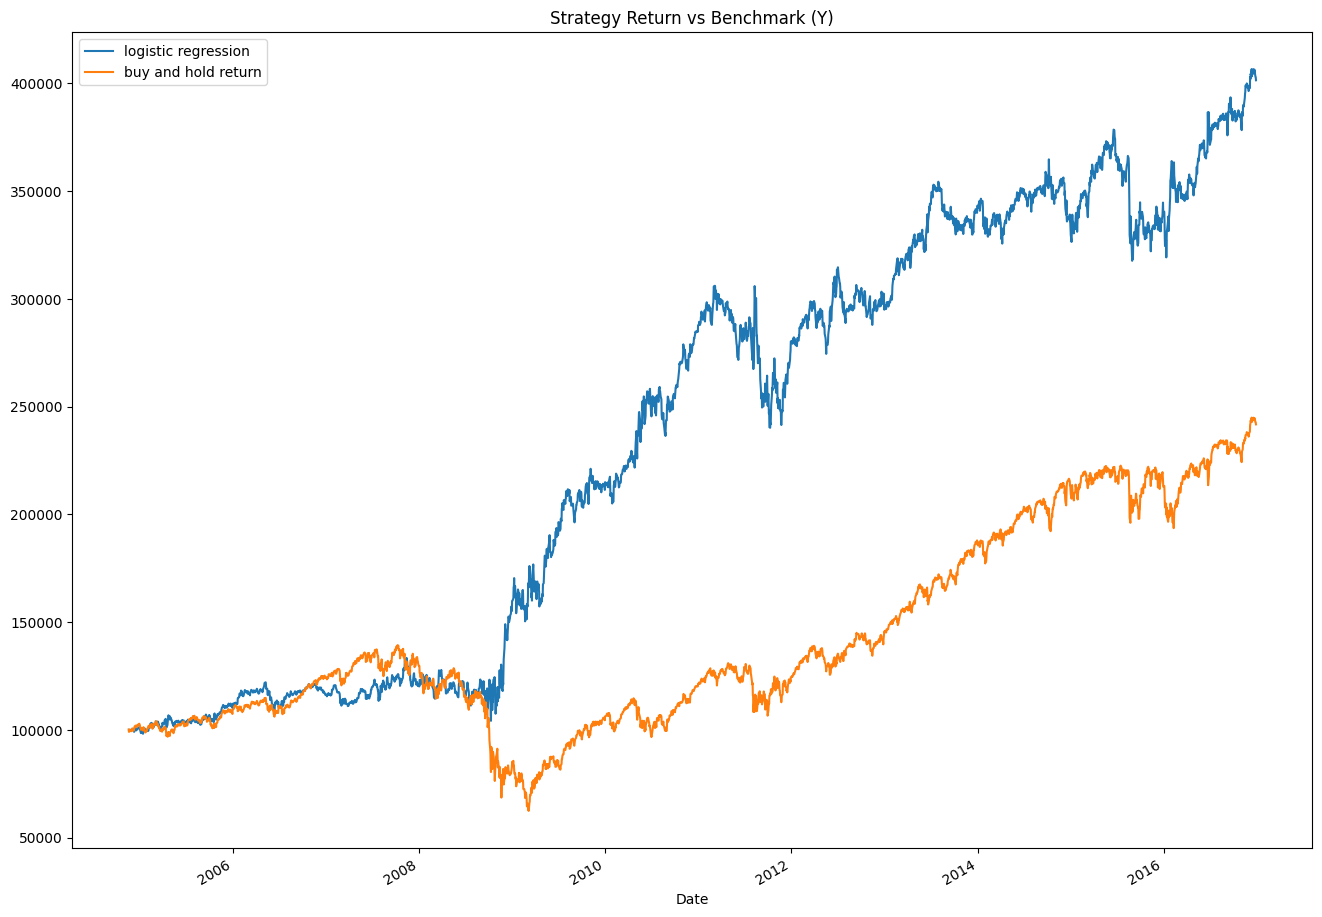

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.280e-01, tolerance: 4.593e-05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/var/folders/lh/jjjmlpfs4dlgcn8whsy2chhm0000gn/T/ipykernel_80926/757691479.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation:

intercept is 0.000 and coefficients are [-6.24098803e-05 -8.34027580e-05 -4.10038442e-04 -3.11369074e-04
 -1.23110649e-03 -1.24878379e-03 -1.25632716e-03 -1.24598705e-03
 -9.01390810e-04  7.98827753e-04]
intercept is 3.985 and coefficients are [-0.00113656 -0.00152002 -0.09954702 -0.09354868 -0.02242055 -0.02292534
 -0.02323945 -0.02245564 -0.87442877 -0.76633763]
Name of features used: ['x30' 'x66' 'x72' 'x73' 'x94' 'x132' 'x133' 'x134' 'x149' 'x150']
 
Accuracy : 0.3749242883101151
 
Precision : 0.4510115033716779
 
Recall : 0.6257567418822234


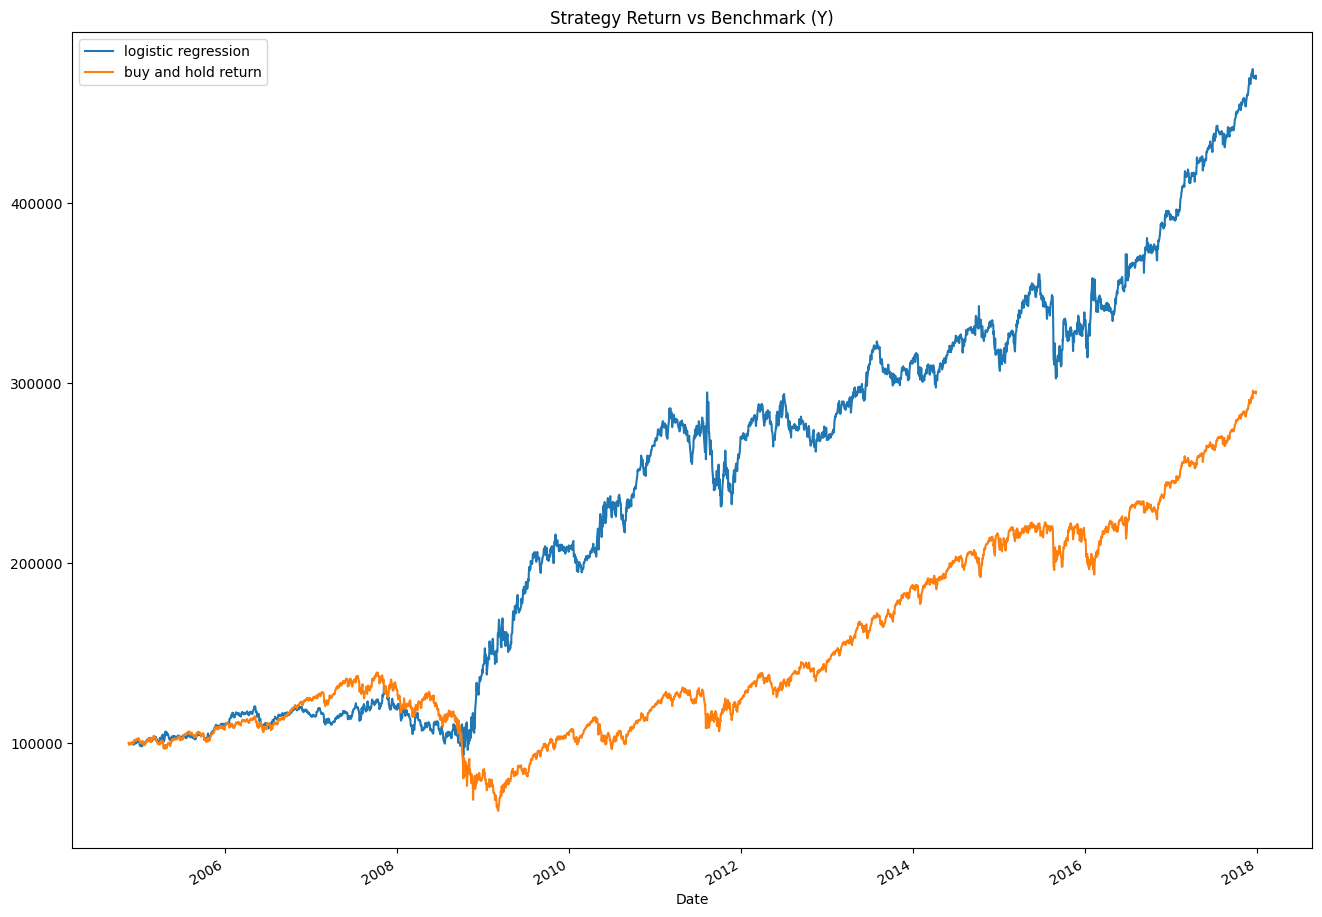

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.427e-01, tolerance: 4.883e-05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/var/folders/lh/jjjmlpfs4dlgcn8whsy2chhm0000gn/T/ipykernel_80926/757691479.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation:

intercept is 0.000 and coefficients are [-5.74611996e-05 -7.82539713e-05 -7.71253737e-05 -3.25138297e-04
 -1.83264812e-04 -1.13420179e-03 -1.15053418e-03 -1.15844701e-03
 -1.14785222e-03 -1.02549597e-04]
intercept is 4.961 and coefficients are [-0.00236116 -0.21439444 -0.00309759 -0.21387487 -0.21460469 -0.046464
 -0.04741483 -0.04827305 -0.04667033 -2.13433462]
Name of features used: ['x30' 'x56' 'x66' 'x72' 'x73' 'x94' 'x132' 'x133' 'x134' 'x149']
 
Accuracy : 0.3664508865747256
 
Precision : 0.4436118396403147
 
Recall : 0.6071794871794872


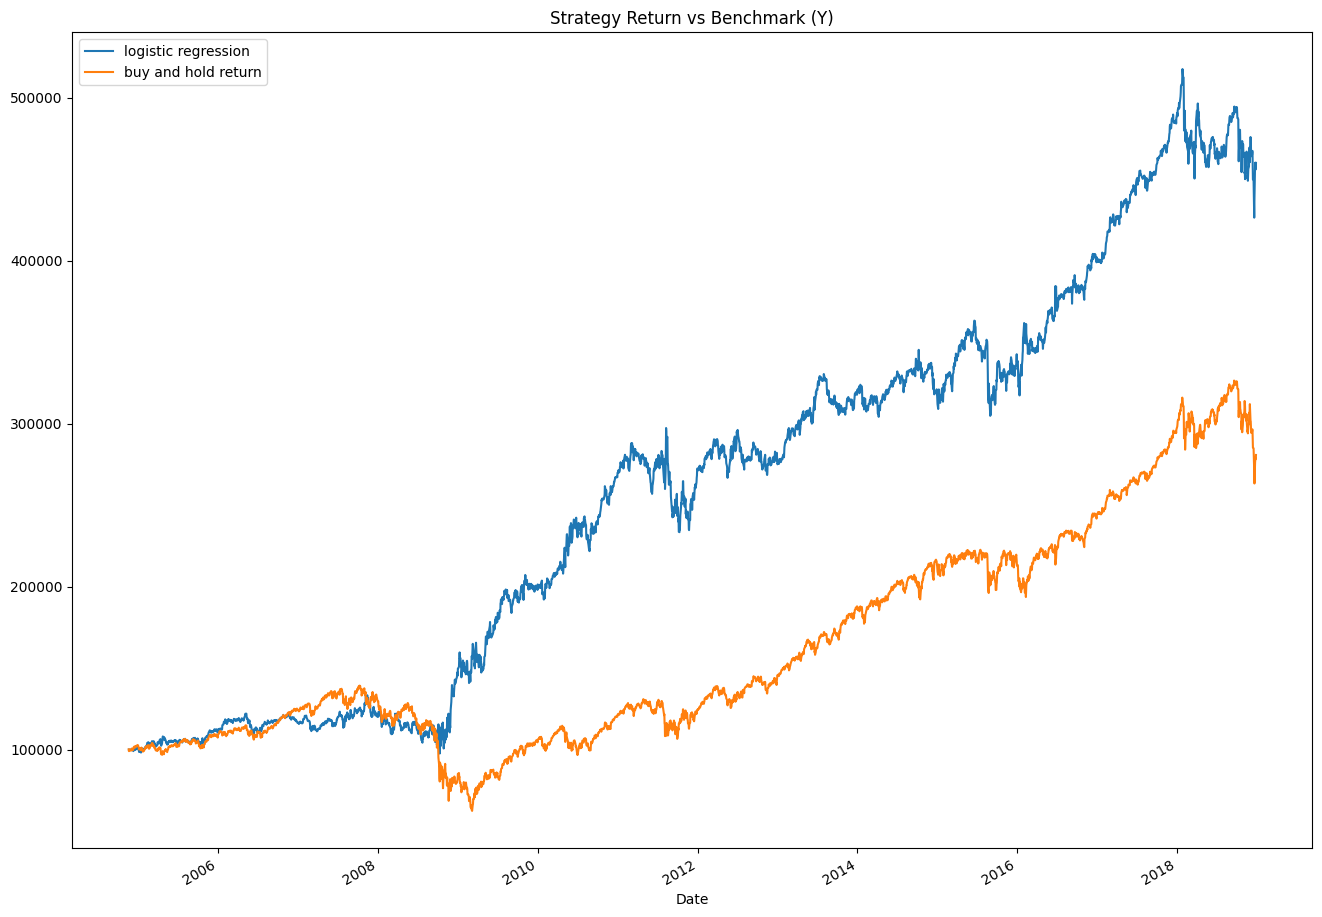

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.506e-01, tolerance: 5.041e-05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/var/folders/lh/jjjmlpfs4dlgcn8whsy2chhm0000gn/T/ipykernel_80926/757691479.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation:

intercept is 0.000 and coefficients are [-5.47795109e-05 -1.09855704e-04 -7.29807006e-05 -3.39552825e-04
 -2.03668967e-04 -1.08041343e-03 -1.09664507e-03 -1.10370959e-03
 -1.09331488e-03 -9.82294714e-05]
intercept is 5.345 and coefficients are [-0.00247569 -0.21453093 -0.00320071 -0.21322331 -0.21313476 -0.04861808
 -0.04947605 -0.05037137 -0.04865433 -1.95203493]
Name of features used: ['x30' 'x56' 'x66' 'x72' 'x73' 'x94' 'x132' 'x133' 'x134' 'x149']
 
Accuracy : 0.39053876478318
 
Precision : 0.46311889525092625
 
Recall : 0.6547619047619048


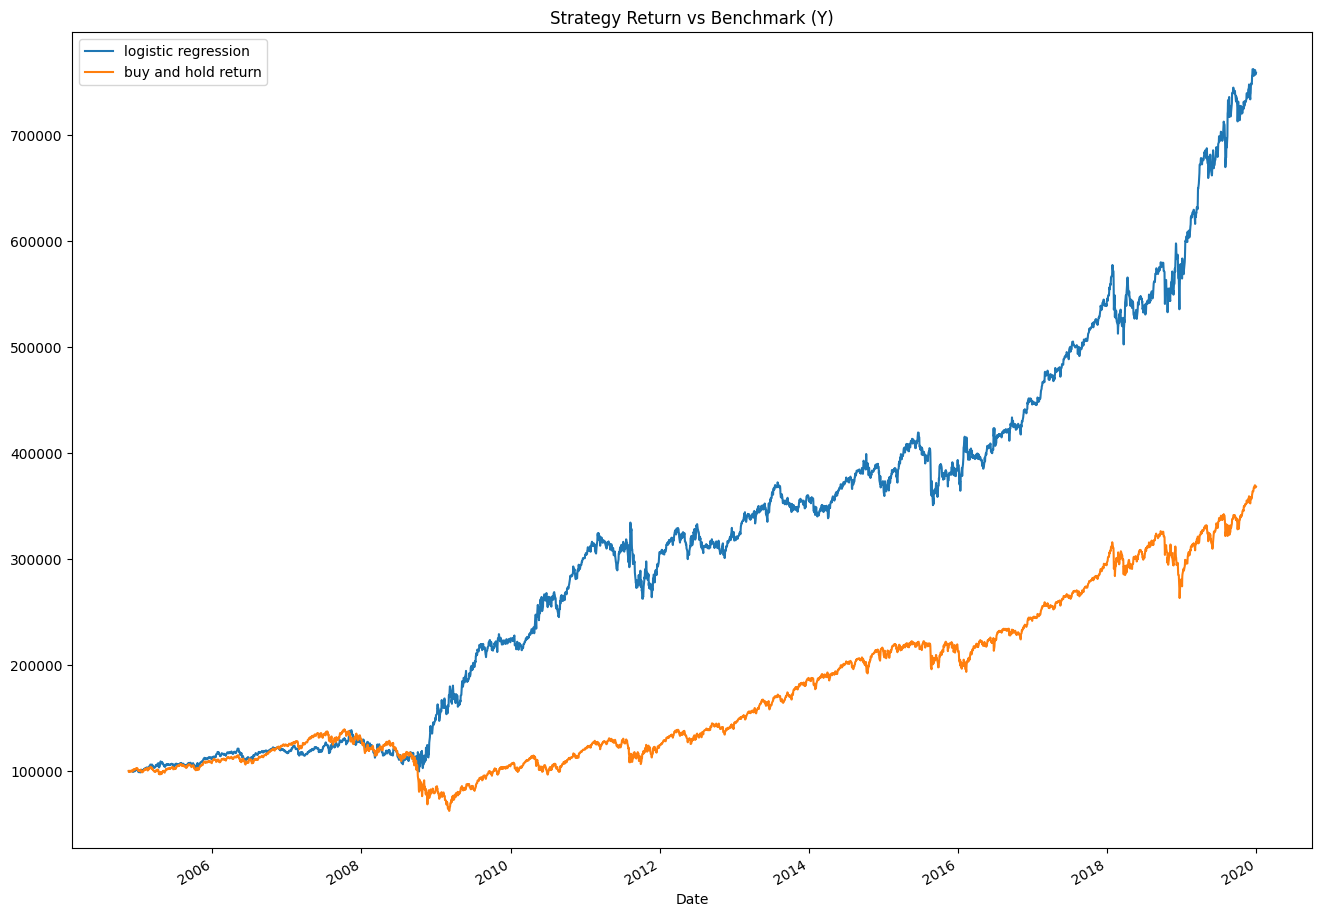

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.020e-01, tolerance: 6.175e-05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/var/folders/lh/jjjmlpfs4dlgcn8whsy2chhm0000gn/T/ipykernel_80926/757691479.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation:

intercept is 0.000 and coefficients are [-3.00739218e-06  1.49094939e-06 -2.49781437e-03 -5.11110457e-04
  9.51310862e-04  1.58824498e-03 -1.83613950e-03  5.29880946e-04
  1.52029512e-03  3.78061079e-05]
intercept is 1.735 and coefficients are [-0.00754052 -0.00670161 -0.17215071 -0.15703659 -0.11578002 -0.09100192
 -0.14115454 -0.10010324 -0.07526317 -0.05850792]
Name of features used: ['x19' 'x32' 'x83' 'x96' 'x97' 'x98' 'x139' 'x140' 'x141' 'x142']
 
Accuracy : 0.3518974864465254
 
Precision : 0.4337474120082816
 
Recall : 0.5596616206589492


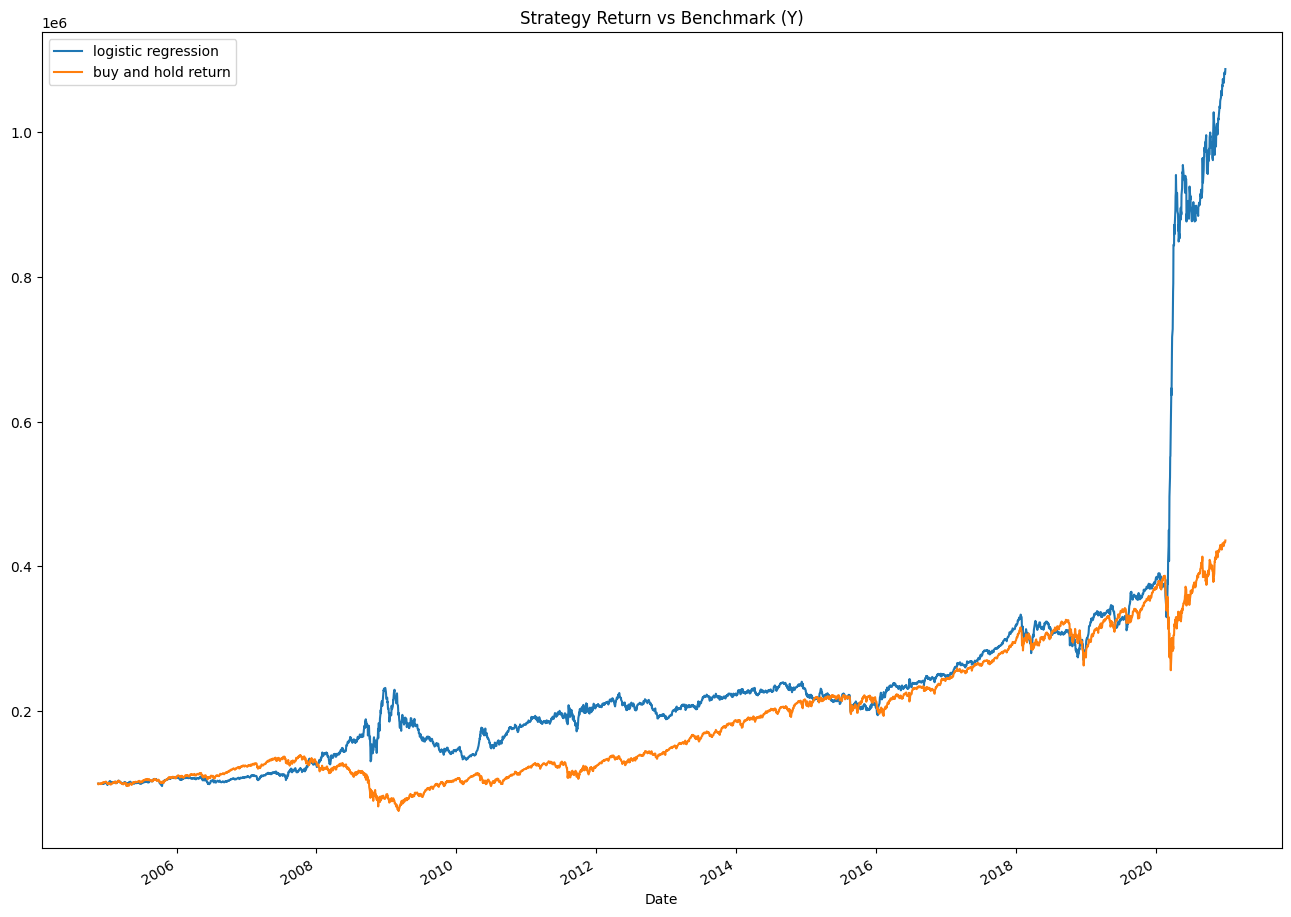

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.105e-01, tolerance: 6.342e-05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/var/folders/lh/jjjmlpfs4dlgcn8whsy2chhm0000gn/T/ipykernel_80926/757691479.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation:

intercept is 0.000 and coefficients are [ 6.97205333e-06  1.89849004e-05 -2.48031478e-03 -4.60098404e-04
  8.79966049e-04  1.57471619e-03 -1.67239803e-03  4.68278130e-04
  1.50528041e-03 -3.14460797e-05]
intercept is 1.859 and coefficients are [-0.00732197 -0.0062224  -0.17608145 -0.15610602 -0.11587535 -0.08540788
 -0.13549826 -0.09540179 -0.06479311 -0.05487315]
Name of features used: ['x19' 'x32' 'x83' 'x96' 'x97' 'x98' 'x139' 'x140' 'x141' 'x142']
 
Accuracy : 0.3617169373549884
 
Precision : 0.4432141727301487
 
Recall : 0.5857023411371237


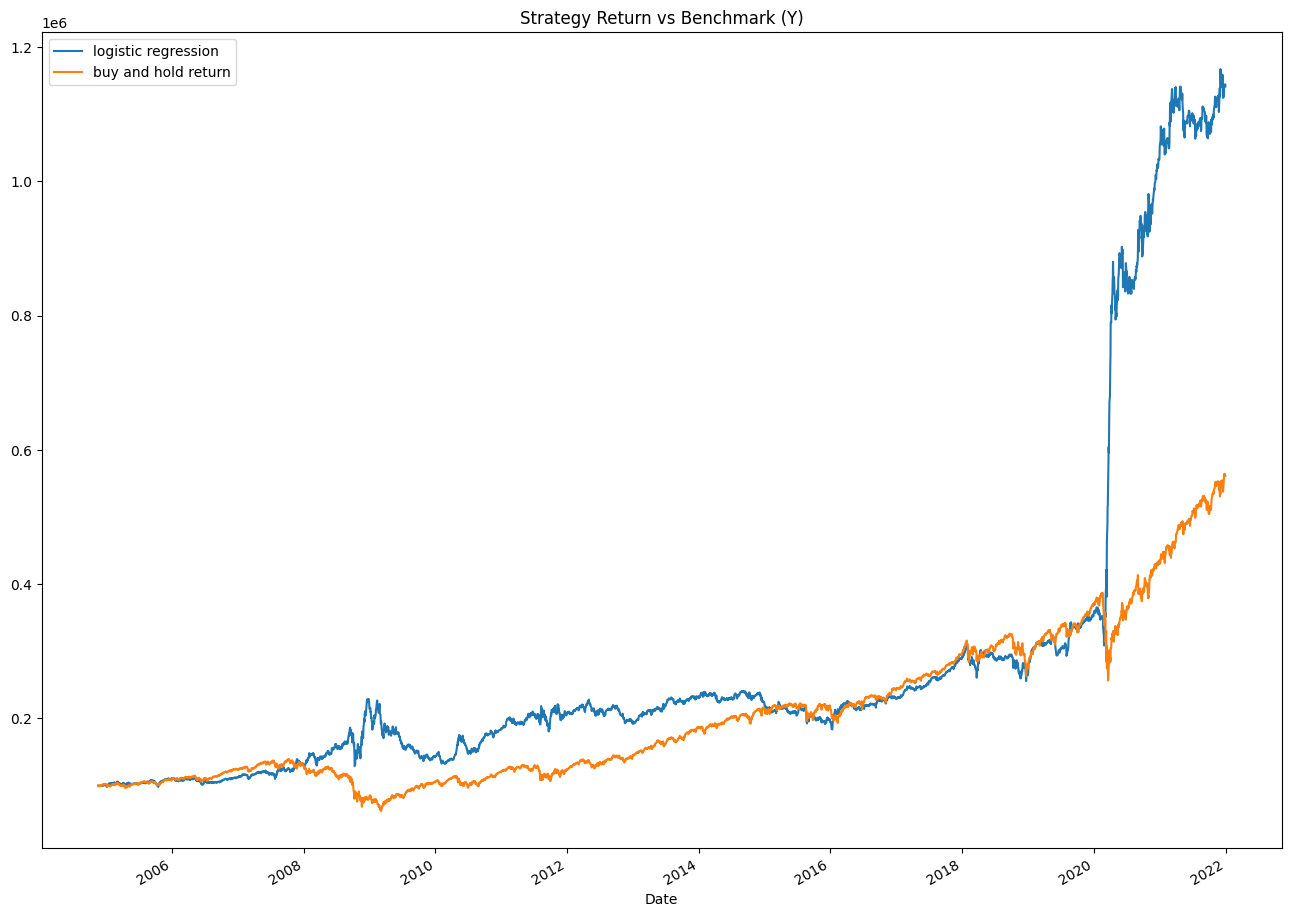

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.403e-01, tolerance: 6.930e-05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


intercept is 0.000 and coefficients are [ 6.40048353e-05  8.35232173e-05 -2.39061349e-03 -3.49767879e-04
  7.80959064e-04  1.58049285e-03 -1.53243748e-03  3.86723367e-04
  1.51856686e-03 -1.99939470e-04]
intercept is 1.826 and coefficients are [-0.00789409 -0.0067849  -0.18101865 -0.16090395 -0.12648146 -0.08886825
 -0.14010268 -0.1058174  -0.06810329 -0.07118705]
Name of features used: ['x19' 'x32' 'x83' 'x96' 'x97' 'x98' 'x139' 'x140' 'x141' 'x142']
 
Accuracy : 0.3499232624424468
 
Precision : 0.42879066912216085
 
Recall : 0.5585765693722511


/var/folders/lh/jjjmlpfs4dlgcn8whsy2chhm0000gn/T/ipykernel_80926/757691479.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_traintest3["signal"].iloc[:13] = 0


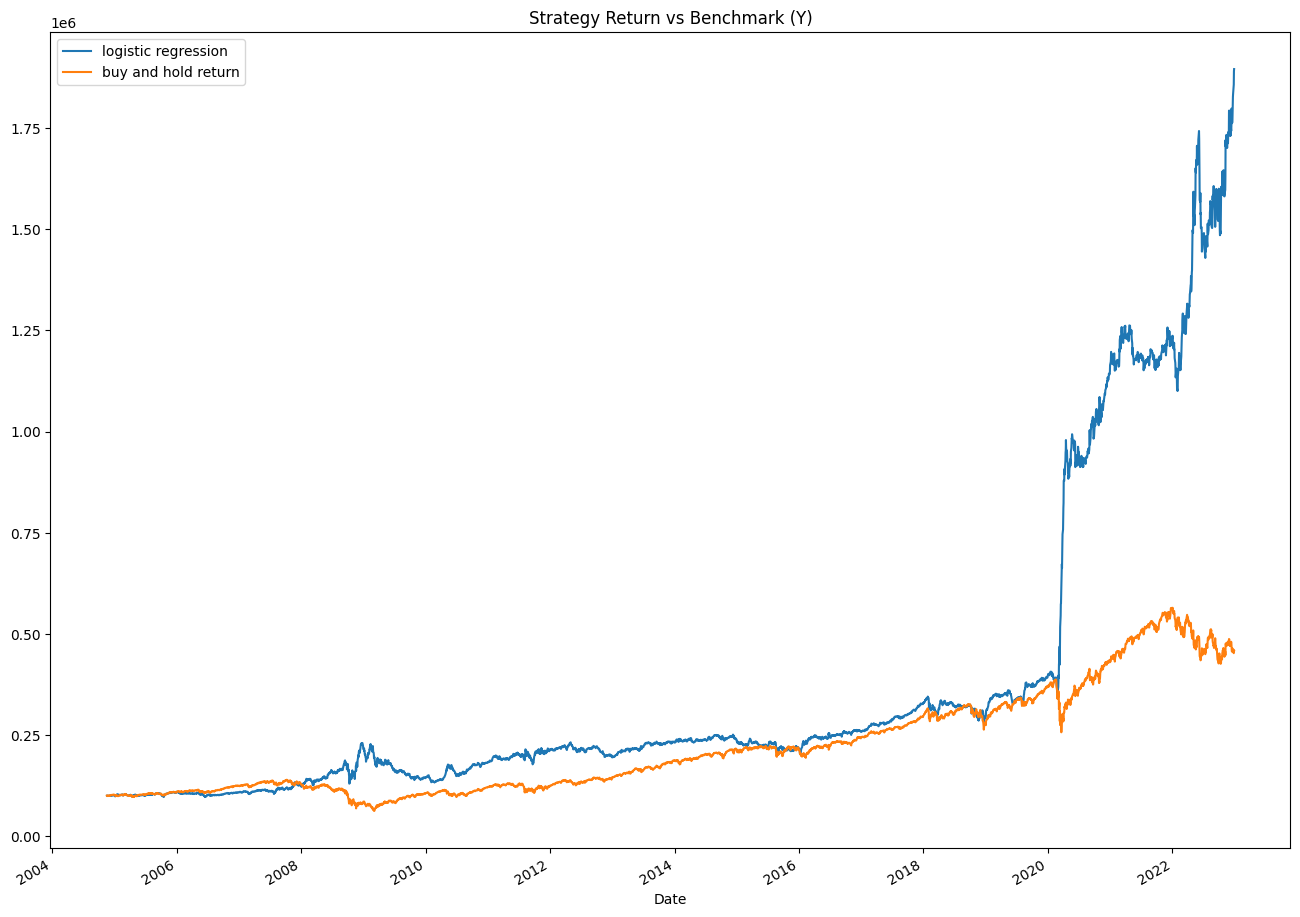

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.478e-01, tolerance: 7.079e-05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/var/folders/lh/jjjmlpfs4dlgcn8whsy2chhm0000gn/T/ipykernel_80926/757691479.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation:

intercept is 0.000 and coefficients are [ 7.66131911e-05  9.80817026e-05 -2.39247548e-03 -3.43330944e-04
  7.63550940e-04  1.58006876e-03 -1.48629917e-03  3.69931713e-04
  1.51663941e-03 -2.11843170e-04]
intercept is 1.880 and coefficients are [-0.00794169 -0.0067276  -0.18473906 -0.16270276 -0.12794482 -0.08971829
 -0.13996602 -0.10529449 -0.0669397  -0.07036092]
Name of features used: ['x19' 'x32' 'x83' 'x96' 'x97' 'x98' 'x139' 'x140' 'x141' 'x142']
 
Accuracy : 0.34598448312015095
 
Precision : 0.4255630301257678
 
Recall : 0.5574712643678161


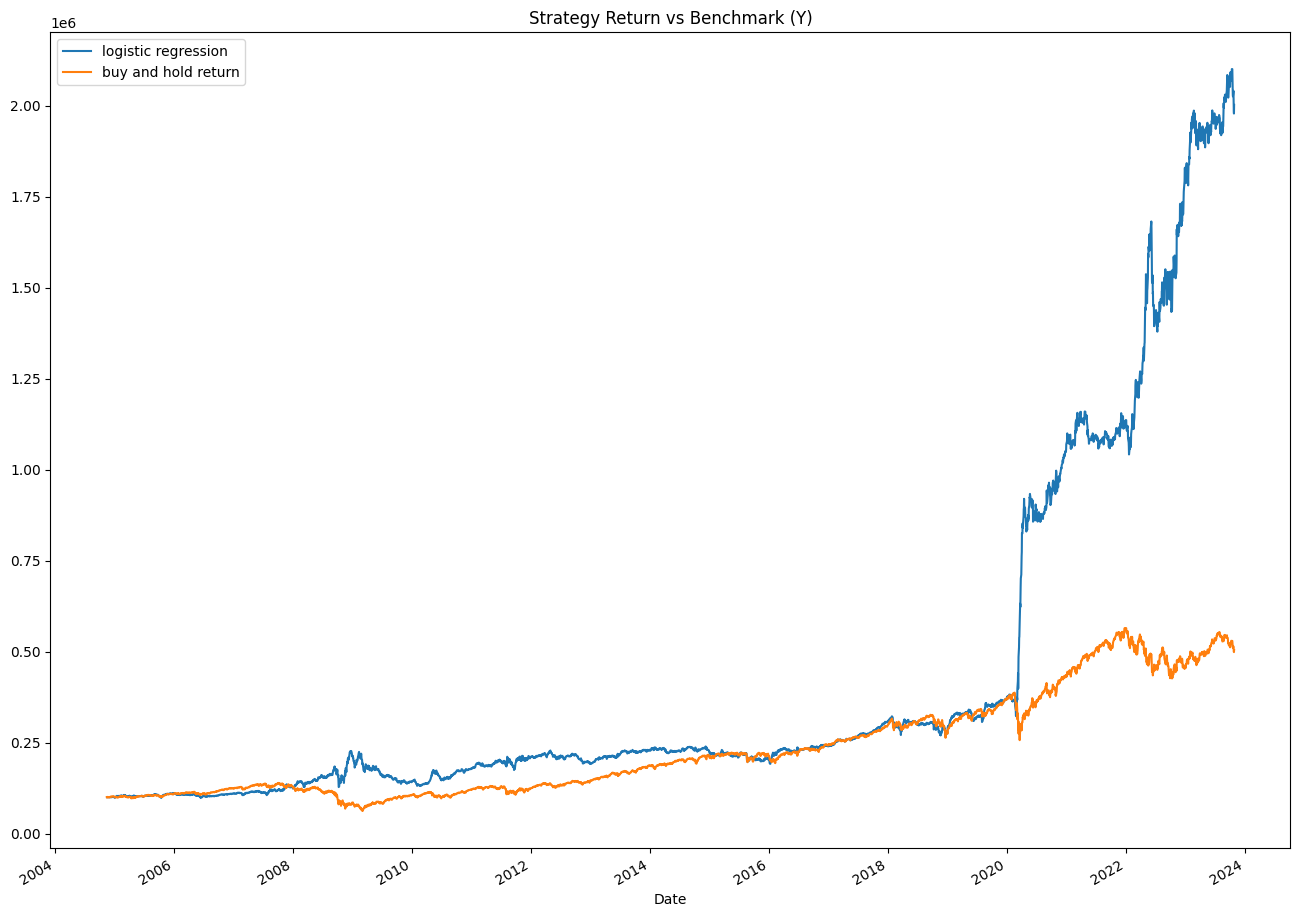

In [49]:
Y_traintest2 = Y_traintest.shift(-1).loc[index_]

params, X_traintest5= fit_and_predict_w_short(df_dict,Y_traintest2,penalty_)



In [50]:
(X_traintest5["strategy_return"].cumsum().apply(np.exp))

Date
2004-11-17          NaN
2004-11-18     1.000000
2004-11-19     1.000000
2004-11-22     1.000000
2004-11-23     1.000000
                ...    
2023-10-23    20.405166
2023-10-24    20.112308
2023-10-25    19.871470
2023-10-26    19.781398
2023-10-27    20.017900
Name: strategy_return, Length: 4769, dtype: float64

# CART (decision tree)

In [51]:
from sklearn.tree import DecisionTreeRegressor

DT_model = DecisionTreeRegressor() #can adjust the max depth


#X are the exogenous variables & y is the endogenous variable
DT_model.fit()


TypeError: DecisionTreeRegressor.fit() missing 2 required positional arguments: 'X' and 'y'

In [ ]:
# Model Specification

penalty_ = 0.0

def fit_and_predict_DT(df_dict,Y_traintest_series,penalty_):
    params_dict = {}
    
    for year_ in years_in_data:
        
        X_index = df_dict[year_].index 
        Y_traintest_series_fraction = Y_traintest_series.loc[X_index]

        DT_model = DecisionTreeRegressor(criterion = "squared_error")

        DT_model.fit(df_dict[year_], Y_traintest_series_fraction)

        DT_pred_train2 = DT_model.predict(df_dict[year_])
        
        train_result = mean_squared_error(DT_pred_train2, Y_traintest_series_fraction)

        DT_pred_train2_df = pd.DataFrame(DT_pred_train2, index = df_dict[year_].index)
        
        print("MSE is {}".format(train_result))

#         params_dict[f"EN_pred_{year_}"] = EN_pred_train2
#         params_dict[f"binary_pred_{year_}"] = Y_pred_binary2
#         params_dict[f"logistic_pred_{year_}"] = Y_pred_logistic2_df

#         params_dict[f"Accuracy_{year_}"] = metrics.accuracy_score(Y_traintest_binary.loc[X_index], Y_pred_logistic2)
#         params_dict[f"Precision_{year_}"] = metrics.precision_score(Y_traintest_binary.loc[X_index],Y_pred_logistic2)
#         params_dict[f"Recall_{year_}"] = metrics.recall_score(Y_traintest_binary.loc[X_index],Y_pred_logistic2)
                                                            
#         print("Name of features used: {}".format(elastic_net.feature_names_in_))
#         print(" ")
#         print("Accuracy :", metrics.accuracy_score(Y_traintest_binary.loc[X_index], Y_pred_logistic2))
#         print(" ")
#         print("Precision :", metrics.precision_score(Y_traintest_binary.loc[X_index],Y_pred_logistic2))
#         print(" ")
#         print("Recall :", metrics.recall_score(Y_traintest_binary.loc[X_index],Y_pred_logistic2))

        
        X_traintest3 = df_dict[year_].copy()
        X_traintest3["signal"] = DT_pred_train2_df
        X_traintest3["signal"].iloc[:12] = 0

        X_traintest3["strategy_return"] = X_traintest3["signal"].shift(1) * Y
        fig,ax = plt.subplots(nrows = 1, ncols = 1, figsize = [16,12])

        (X_traintest3["strategy_return"].cumsum().apply(np.exp) * capital).plot(ax=ax, label = "logistic regression")

        (Y.loc[X_index].cumsum().apply(np.exp) * capital).plot(ax=ax, label = "buy and hold return")

        ax.legend()
        ax.set_title('Strategy Return vs Benchmark (Y)')
        plt.show()
    
    return params_dict, X_traintest3

In [ ]:
dummy_df = fit_and_predict_DT(df_dict,Y_traintest,penalty_)[1]

In [ ]:
dummy_df["signal"].hist(bins=100)